# Overview

This started as a small notebook to scrape and compile the top songs from the websites and then turned into this massive collection of canonicalization logic, hydration code for more service coverage, ranking, visualization, and export code.

Hell is other people's notebook code, I'm sure. Please don't judge too harshly.

In [1]:
from bs4 import BeautifulSoup

import pandas
import numpy

from IPython.display import display

from sources import (
    WEBSITES,
    SOURCES,
    SOURCE_TO_OTHER_URL_PREFERENCE,
    SOURCE_TO_YOUTUBE_ID_PREFERENCE,
    SHADOW_RANKS,
    CLUSTER_METADATA,
    SOURCE_TO_YOUTUBE_ID_PREFERENCE_LIST,
)
import ranking_engine as gem_ranker

In [2]:
from importlib import reload
reload(gem_ranker)

<module 'ranking_engine' from '/Users/eea1/projects/consensus-best-songs-2025/python/notebooks/ranking_engine.py'>

# Sources setup and validation


In [3]:

sources_name_set = set(SOURCES.keys())

website_sources_name_set = set([ws["source"] for ws in WEBSITES])
website_sources_name_set.remove("New York Times")
website_sources_name_set.add("New York Times (Jon Caramanica)")
website_sources_name_set.add("New York Times (Lindsay Zoladz)")

assert (
    sources_name_set == website_sources_name_set
), f"Disjoint sources: {sources_name_set - website_sources_name_set} and {website_sources_name_set - sources_name_set}"

# +1 because I split the New York times lists for the 2 separate critics
assert len(SOURCES) == len(set([website["source"] for website in WEBSITES])) + 1

for source, shadow_rank in SHADOW_RANKS.items():
    assert source in SOURCES, f"Missing source: {source}"

In [4]:
# Ordering for the rank columns in our aligned dataframe
# This is just for display
SUFFIX_ORDER = [c["suffix"] for src, c in SOURCES.items()]

assert len(SUFFIX_ORDER) == len(set(SUFFIX_ORDER))

assert len(SUFFIX_ORDER) == len(SOURCES)

In [5]:
assert (
    set(SOURCE_TO_YOUTUBE_ID_PREFERENCE_LIST) == website_sources_name_set
), f"Disjoint sources: {set(SOURCE_TO_YOUTUBE_ID_PREFERENCE_LIST) - website_sources_name_set} and {website_sources_name_set - set(SOURCE_TO_YOUTUBE_ID_PREFERENCE_LIST)}"

In [6]:
from dataclasses import dataclass


@dataclass
class Song:
    name: str | None = None
    artist: str | None = None
    featuring: str | None = None

    # float due to The FADER including a rank "6.7"
    rank: float | None = None

    source: str | None = None
    description: str | None = None

    isrc: str | None = None
    youtube_id: str | None = None
    spotify_id: str | None = None
    other_url: str | None = None

    canonical_artist: str | None = None
    canonical_name: str | None = None

    spotify_is_playable: bool = True
    spotify_popularity: int = 0

    id: str | None = None
    is_manual_override: bool = False

    spotify_artist0_id: str | None = None
    spotify_artist0_name: str | None = None
    spotify_artist0_genres: str | None = None

    apple_music_genres: str | None = None
    apple_music_us_url: str | None = None

In [7]:
from playwright.async_api import async_playwright
import os


# Originally I was doing this via Playwright but I started to find cases
# with captchas, etc. I ended up navigating to later ones in Chrome and
# using devtools to copy outer HTML and save, instead. Thus disabling
# scraping. I'm not checking in the original content so you'll need
# to add corresponding files in scrapes/ to start over.
#
# It would be possible to improve the scraping code but doesn't seem
# worth it at this point and without more lists.
SKIP_SCRAPES = True


async def grab_dom(sites):
    async with async_playwright() as p:
        browser = await p.chromium.launch(headless=True)
        page = await browser.new_page()
        page.set_default_navigation_timeout(90000)
        for site in sites:
            filepath = os.path.join("scrapes", site["filename"])
            if os.path.exists(filepath) or SKIP_SCRAPES:
                print(f"Reloading {filepath} instead of fetching...")
                with open(filepath, "r", encoding="utf-8") as f:
                    site["dom"] = f.read()
                continue

            print(f"Trying to fetch {site}")

            url = site["url"]
            print(f"Visiting {url}...")
            await page.goto(url, wait_until="domcontentloaded")
            html = await page.content()
            with open(filepath, "w", encoding="utf-8") as f:
                f.write(html)
            print(f"Saved {url} -> {filepath}")
            site["dom"] = html
        await browser.close()

# Fetch webites


In [8]:
await grab_dom(WEBSITES)

Reloading scrapes/rollingstone_50_to_1.html instead of fetching...
Reloading scrapes/rollingstone_100_to_51.html instead of fetching...
Reloading scrapes/pitchfork_best_100.html instead of fetching...
Reloading scrapes/nme_best_50.html instead of fetching...
Reloading scrapes/guardian_best_20.html instead of fetching...
Reloading scrapes/paste_best_100.html instead of fetching...
Reloading scrapes/new_york_times_best_48.html instead of fetching...
Reloading scrapes/stereogum_best_50.html instead of fetching...
Reloading scrapes/consequence_best_200.html instead of fetching...
Reloading scrapes/npr_best_25_unranked.html instead of fetching...
Reloading scrapes/npr_best_125_unranked.html instead of fetching...
Reloading scrapes/billboard_staff_best_100.html instead of fetching...
Reloading scrapes/vulture_best_10.html instead of fetching...
Reloading scrapes/the_fader_best_2025.html instead of fetching...
Reloading scrapes/complex_best_2025.html instead of fetching...
Reloading scrapes/t

# Parse songs from sources

Use BeautifulSoup to poke through the quirks of each site's rendered HTML
and extract rankings, artist names, song names, links to music services,
and short review, if any.

Also fix any random misspellings that ended up breaking canonicalization
in Spotify's search API.

In retrospect, I could've thrown each of these into an AI call and have it
either write the code or just do the extraction into a Pydantic class.
It was a bit more reassuring to just have the code and see it manually,
I thought, but it was painful.

## Rolling Stone

All of these seem to have a YouTube video linked.


In [9]:
import re


RS_ARTIST_SONG_RE = re.compile(r"^(.*), ['‘’](.*)['‘’]$")

YOUTUBE_URL_ID_RE = re.compile(r"^http.*(?:v=|youtu\.be\/|embed\/)([a-zA-Z0-9_-]{11})")


def extract_youtube_id(url: str | None) -> str | None:
    if url is None or not url:
        return None
    m = YOUTUBE_URL_ID_RE.search(url)
    if m is None:
        return None
    return m.group(1)


def parse_rolling_stone_article(article):
    song = Song()
    song.source = "Rolling Stone"
    song.rank = int(
        article.find(
            "span", class_="c-gallery-vertical-featured-image__number"
        ).get_text()
    )
    artist_song = article.find(
        "h2", class_="c-gallery-vertical-featured-image__title"
    ).get_text()

    m = RS_ARTIST_SONG_RE.match(artist_song)
    assert m is not None
    song.artist = m.group(1)
    assert song.artist is not None
    song.name = m.group(2)
    song.description = article.find("p").get_text(strip=True, separator=" ")

    if " feat. " in song.artist:
        parts = song.artist.split(" feat. ")
        assert len(parts) == 2
        song.artist = parts[0]
        song.featuring = parts[1]
        # print(f'New: {song.artist} - {song.name} featuring {song.featuring}')

    iframe = article.find("iframe")
    if iframe is None:
        print(f"No iframe for YouTube link for {song.artist} {song.name}")
    else:
        iframe_url = iframe["data-src"]
        assert "youtube.com" in iframe_url, f"youtube.com not in {iframe_url}"
        youtube_id = extract_youtube_id(iframe_url)
        assert (
            youtube_id is not None
        ), f"Bad YouTube link for {song.artist} {song.name}: {iframe_url}"
        song.youtube_id = youtube_id

    return song


def parse_rolling_stone_site(html):
    soup = BeautifulSoup(html, "lxml")

    articles = soup.find_all("article")
    assert len(articles) == 51
    songs = list()
    for article in articles[1:]:
        songs.append(parse_rolling_stone_article(article))
    return songs


def parse_rolling_stone_sites(part1_html, part2_html):
    songs1 = parse_rolling_stone_site(part1_html)
    print(f"Songs in part 1: {len(songs1)}")
    songs2 = parse_rolling_stone_site(part2_html)
    print(f"Songs in part 2: {len(songs2)}")
    songs1.extend(songs2)
    return songs1

In [10]:
rs_websites = [ws for ws in WEBSITES if ws["source"] == "Rolling Stone"]

rs_songs = parse_rolling_stone_sites(rs_websites[0]["dom"], rs_websites[1]["dom"])

SOURCES["Rolling Stone"]["songs"] = rs_songs

No iframe for YouTube link for Chappell Roan The Subway
Songs in part 1: 50
Songs in part 2: 50


In [11]:
assert len(rs_songs) == 100
rs_songs.sort(key=lambda song: song.rank)
assert rs_songs[99].rank == 100

In [12]:
rs_songs[1].youtube_id

'7BUI9S6PEiI'

## Pitchfork

Most of these have YouTube links but not all


In [13]:
PITCHFORK_ARTIST_SONG_RE = re.compile(r"^(.*): [“](.*)[”](?: [[]ft. (.*)[]])?$")


def parse_pitchfork_songs(html):
    soup = BeautifulSoup(html, "lxml")
    songs = list()
    for h3_div in soup.find_all("div", class_="heading-h3"):
        song = Song()
        song.source = "Pitchfork"
        song.rank = int(h3_div.get_text(strip=True)[:-1])

        artist_song = h3_div.find_next("h2")
        assert artist_song is not None

        m = PITCHFORK_ARTIST_SONG_RE.match(artist_song.get_text(strip=True))
        if m is None:
            print(
                f"Error splitting artist and song from {artist_song.get_text(strip=True)} in {h3_div.prettify()}"
            )
        assert m is not None
        song.artist = m.group(1)
        song.name = m.group(2)
        if m.group(3):
            song.featuring = m.group(3)

        description1 = artist_song.find_next("p")
        assert description1 is not None
        song.description = description1.get_text(strip=True, separator=" ")
        songs.append(song)

        next_strong = artist_song.find_next("strong")
        assert (
            next_strong is not None
        ), f"Did not find strong for {song.rank} {song.name}"
        next_link = next_strong.find_next("a")
        assert next_link is not None, f"Did not find link for {song.rank} {song.name}"
        href = next_link["href"]
        if "youtube" not in href:
            print(f"Non-YouTube link for {song.rank} {song.name} {href}")
            song.other_url = str(href)
        else:
            youtube_id = extract_youtube_id(str(href))
            assert (
                youtube_id is not None
            ), f"Bad YouTube ID extraction for {song.rank} {song.name} {href}"
            song.youtube_id = youtube_id

    songs.sort(key=lambda s: s.rank)
    return songs

/var/folders/jf/lry9g9x122nclq95th6dsb1h0000gn/T/ipykernel_27529/1654338147.py:1: FutureWarning: Possible nested set at position 22
  PITCHFORK_ARTIST_SONG_RE = re.compile(r"^(.*): [“](.*)[”](?: [[]ft. (.*)[]])?$")


In [14]:
pitchfork_websites = [ws for ws in WEBSITES if ws["source"] == "Pitchfork"]

pitchfork_songs = parse_pitchfork_songs(pitchfork_websites[0]["dom"])

SOURCES["Pitchfork"]["songs"] = pitchfork_songs

Non-YouTube link for 92 Special Request to All Nice and Decent Real Niggaz (Stop Hatin) https://soundcloud.com/bmgmusix/stophatin
Non-YouTube link for 19 Breathe Kullawada Caporal E DJ edit https://chuquimamani-condori.bandcamp.com/track/breathe-kullawada-caporal-e-dj-edit


In [15]:
assert len(pitchfork_songs) == 100

## NME

All of these have Spotify links


In [16]:
SPOTIFY_URL_ID_RE = re.compile(r"spotify.*track/([a-zA-Z0-9]{22})")


def extract_spotify_id(url: str):
    """Extracts the 22-char ID from a Spotify URL"""
    match = SPOTIFY_URL_ID_RE.search(url)
    return match.group(1) if match else None


NME_RANK_ARTIST_SONG_RE = re.compile(r"^([0-9]+). (.*) – ‘(.*)’(?: [(](.*)[])])?$")


def parse_nme_songs(html):
    soup = BeautifulSoup(html, "lxml")
    songs = list()
    for article in soup.find_all("article")[1:]:
        h3 = article.find_next("h3")
        assert h3 is not None
        song = Song()
        song.source = "NME"

        m = NME_RANK_ARTIST_SONG_RE.match(h3.get_text(strip=True))
        if m is None:
            print(f"Error splitting artist and song from {h3.get_text(strip=True)}")
        assert m is not None
        song.rank = int(m.group(1))
        song.artist = m.group(2)
        song.name = m.group(3)
        if m.group(4):
            song.featuring = m.group(4)

        description1 = h3.find_next("p")
        song.description = description1.get_text(strip=True, separator=" ")

        listen_link = article.find_next(
            "a", attrs={"aria-label": re.compile(r"listen to the full song", re.I)}
        )
        assert (
            listen_link is not None
        ), f"Couldn't find listen link for {song.artist} {song.name}"
        href = str(listen_link["href"])
        spotify_id = extract_spotify_id(href)
        assert (
            spotify_id is not None
        ), f"Non-Spotify listen link: {href} for {song.artist} {song.name}"
        song.spotify_id = spotify_id

        songs.append(song)
    songs.sort(key=lambda s: s.rank)
    return songs

In [17]:
nme_websites = [ws for ws in WEBSITES if ws["source"] == "NME"]

nme_songs = parse_nme_songs(nme_websites[0]["dom"])

SOURCES["NME"]["songs"] = nme_songs

In [18]:
assert len(nme_songs) == 50

## Guardian

While The Guardian published a Spotify playlist with their songs, they don't link to the songs individually. So not extracting Spotify IDs or links for now.


In [19]:
GUARDIAN_ARTIST_SONG_RE = re.compile(r"^(.*) – (.*)$")


def parse_guardian_songs(html):
    soup = BeautifulSoup(html, "lxml")
    songs = list()
    for rank_div in soup.find_all(
        "p", class_="dcr-130mj7b list-item__number-paragraph"
    ):
        song = Song()
        song.source = "The Guardian"
        song.rank = int(rank_div.get_text(strip=True))

        artist_song_h2 = rank_div.find_next("h2")
        assert artist_song_h2 is not None

        m = GUARDIAN_ARTIST_SONG_RE.match(artist_song_h2.get_text(strip=True))
        if m is None:
            print(
                f"Error splitting artist and song from {artist_song_h2.get_text(strip=True)}"
            )
        assert m is not None
        song.artist = m.group(1)
        song.name = str(m.group(2))

        if " ft " in song.name:
            parts = song.name.split(" ft ")
            song.name = parts[0]
            song.featuring = parts[1]
        elif " (ft " in song.name:
            parts = song.name.split(" (ft ")
            assert parts[1].endswith(")")
            song.name = parts[0]
            song.featuring = parts[1][:-1]

        description1 = artist_song_h2.find_next("p")
        song.description = description1.get_text(strip=True, separator=" ")

        # They did some stuff where they allowed multiple songs
        if " / " in song.name:
            song_list = song.name.split(" / ")
            for song_name in song_list:
                new_song = Song()
                new_song.artist = song.artist
                new_song.name = song_name
                new_song.source = song.source
                new_song.description = song.description
                new_song.rank = song.rank
                songs.append(new_song)
        else:
            songs.append(song)

    songs.sort(key=lambda s: s.rank)
    return songs

In [20]:
guardian_websites = [ws for ws in WEBSITES if ws["source"] == "The Guardian"]
guardian_songs = parse_guardian_songs(guardian_websites[0]["dom"])
SOURCES["The Guardian"]["songs"] = guardian_songs

In [21]:
assert len(guardian_songs) == 22

In [22]:
guardian_songs

[Song(name='Berghain', artist='Rosalía', featuring=None, rank=1, source='The Guardian', description='There’s no more boring debate than arguing over whether a piece of music conforms to the traditions of a particular genre. All that hot air and high dudgeon lavished on Berghain and whether the dramatic thrusts of the London Symphony Orchestra constitute classical music or Rosalía’s coloratura is or isn’t opera – who cares? These petty concerns pale in comparison to marvelling at what the Catalan visionary is up to by smashing all this grandeur together, coupled with lyrics in German and Spanish, Björk offering “divine intervention”, Yves Tumor reprising Mike Tyson’s “I’ll fuck you till you love me” rant, and references to a 12th-century German abbess for good measure. The towering, gothic Berghain subsumes the listener in the same way the doomed relationship Rosalía sings about is swallowing her: being overwhelmed by a lover’s fear, anger, love and blood, dissolving like sugar in hot c

## Paste

This has a couple of YouTube links and one or two others but not enough to justify parsing I think


In [23]:
PASTE_RANK_ARTIST_SONG = re.compile(r"^([0-9]+)[.] (.*): “(.*)”$")


def parse_paste_songs(html):
    soup = BeautifulSoup(html, "lxml")
    songs = list()
    for h2 in soup.find_all("h2"):
        song = Song()
        song.source = "Paste"

        m = PASTE_RANK_ARTIST_SONG.match(h2.get_text(strip=True))
        if m is None:
            print(f"Error splitting artist and song from {h2.get_text(strip=True)}")
        assert m is not None
        song.rank = int(m.group(1))
        song.artist = m.group(2)
        song.name = m.group(3)

        assert song.artist is not None
        if " ft. " in song.artist:
            print(f"Splitting featured artists from {song.artist}")
            parts = song.artist.split(" ft. ")
            assert len(parts) == 2
            song.artist = parts[0]
            song.featuring = parts[1]

        description1 = h2.find_next("p")
        assert description1 is not None
        song.description = description1.get_text(strip=True, separator=" ")

        # Misspellings
        if song.artist == "mark williams lewis" and song.name == "Ecstatic Heads":
            song.artist = "mark william lewis"

        songs.append(song)
    songs.sort(key=lambda s: s.rank)
    return songs

In [24]:
paste_websites = [ws for ws in WEBSITES if ws["source"] == "Paste"]
paste_songs = parse_paste_songs(paste_websites[0]["dom"])
SOURCES["Paste"]["songs"] = paste_songs

Splitting featured artists from PinkPantheress ft. Zara Larsson
Splitting featured artists from Tyler, The Creator ft. Madison McFerrin
Splitting featured artists from Blood Orange ft. Caroline Polachek, Lorde, & Mustafa
Splitting featured artists from MAVI ft. Earl Sweatshirt
Splitting featured artists from billy woods ft. Yolanda Watson
Splitting featured artists from The Waterboys ft. Fiona Apple
Splitting featured artists from Saba & No ID ft. Love Mansuy, Ogi, & Smino
Splitting featured artists from Armand Hammer ft. Kapwani


In [25]:
paste_songs[0]

Song(name='Awila', artist='Los Thuthanaka', featuring=None, rank=1, source='Paste', description='I don’t know that there’s been a more important release in 2025 than Los Thuthanka —an album dedicated to Chuqi Chinchay, an Aymara “staff god” deity painted “all the colors” and considered to be a guardian to queer people. The Crampton siblings, Elysia and Joshua Chuquimia, revel in DJ tags, vocal samples, bit-crushed synths, experimental renditions of Bolivian music, dance-punk, and plunderphonics on a project where five of its eight tracks span eight minutes or more, all of which fester in the expanse of staggering digital collages. Like a wrestling arc, the Cramptons traffic in long-form storytelling in their Los Thuthanaka songs. “Awila” builds and confounds and builds and confounds; chaotic, gut-spilling percussion and riffs try to detonate through the swelling. We get 12 delirious minutes of a kullawada dance, and every second is spent reaching towards euphoria. When Joshua’s guitar 

## New York Times

Unlike the other sites, this is 2 lists from different reviewers.

The first 20 numbered headings are from Jon Caramanica and the second 20 are from Lindsay Zoladz. Caramanica included some unranked ones at the end but I'm not dealing with those.

These seem to have a "Listen on..." section that can include YouTube and Spotify.


In [26]:
# Regex pattern explanation:
# ^(?P<rank>\d+)\.          -> Start with digits (rank) followed by a dot
# \s+                       -> Followed by whitespace
# (?P<artist>.+?)           -> Capture artist name non-greedily...
# (?:\s+featuring\s+        -> ...until we hit " featuring " (optional group)
#   (?P<featured>.+?)       -> Capture featured artists inside this group
# )?                        -> Make the 'featuring' group optional
# ,\s+                      -> Match the comma and space separating artist and song
# [‘'](?P<name>.+)[’']      -> Capture song name inside either smart or straight quotes
NYTIMES_RANK_ARTIST_SONG = re.compile(
    r"^(?P<rank>\d+)\.\s?(?P<artist>.+?)(?:\s+featuring\s+(?P<featured>.+?))?,\s+[‘'](?P<name>.+)[’']"
)


def parse_nytimes_song_heading(h3_text):
    m = NYTIMES_RANK_ARTIST_SONG.match(h3_text)
    if m is None:
        print(f"Failed to extract rank, artist, and song name from {h3_text}")
    groups = m.groupdict()
    rank = groups["rank"]
    artist = groups["artist"]
    featuring = groups["featured"]
    name = groups["name"]

    return rank, artist, name, featuring


def parse_nytimes_songs(html):
    soup = BeautifulSoup(html, "lxml")
    song_lists = [list(), list()]
    total_count = 0
    for h3 in soup.find_all("h3", class_="css-15h6bi9 e1gnsphs0"):
        if h3.get_text(strip=True) == "And 10 More!":
            continue
        total_count += 1
        group = 1 if total_count > 20 else 0
        # print(f"total {total_count}, group {group}, text: {h3.get_text()}")

        song = Song()
        song.source = "New York Times " + (
            "(Jon Caramanica)" if group == 0 else "(Lindsay Zoladz)"
        )
        rank, artist, name, featuring = parse_nytimes_song_heading(
            h3.get_text(strip=True)
        )
        song.rank = int(rank)
        song.artist = artist
        song.name = str(name)
        if featuring:
            song.featuring = featuring

        song.description = h3.find_next("p", class_="css-ac37hb evys1bk0").get_text(
            strip=True, separator=" "
        )
        # Random corrections
        if song.artist == "Ian" and "Freestyle" in song.name:
            song.name = "Oh Ok - xxl freestyle"

        strong = h3.find_next("strong", string=re.compile("^Listen"))  # type: ignore
        assert (
            strong is not None
        ), f"Couldn't find strong Listen for {song.artist} {song.name}"

        anchors = strong.find_next_siblings("a", class_="css-yywogo")
        assert (
            anchors is not None and len(anchors) > 0
        ), f"Couldn't find links for {song.artist} {song.name}"
        for anchor in anchors:
            if "spotify" in anchor["href"]:
                spotify_id = extract_spotify_id(str(anchor["href"]))
                if spotify_id is None:
                    print(
                        f'Failed to extract spotify ID from {anchor["href"]} for {song.artist} {song.name}'
                    )
                    continue
                song.spotify_id = spotify_id
            elif "youtube" in anchor["href"]:
                youtube_id = extract_youtube_id(str(anchor["href"]))
                if youtube_id is None:
                    print(
                        f'Failed to extract youtube ID from {anchor["href"]} for {song.artist} {song.name}'
                    )
                    continue
                song.youtube_id = youtube_id
            elif "music.apple.com" in anchor["href"]:
                continue
            else:
                print(f'Skipping unknown anchor: {anchor["href"]}')

        song_lists[group].append(song)

    for songs in song_lists:
        songs.sort(key=lambda s: s.rank)
    return song_lists

In [27]:
nytimes_websites = [ws for ws in WEBSITES if ws["source"] == "New York Times"]

nyt_caramanica_songs, nyt_zoladz_songs = parse_nytimes_songs(nytimes_websites[0]["dom"])

print(f"nyt_caramanica_songs: {len(nyt_caramanica_songs)}")
print(
    f"   with YouTube links: {sum([1 for s in nyt_caramanica_songs if s.youtube_id])}"
)
print(
    f"   with Spotify links: {sum([1 for s in nyt_caramanica_songs if s.spotify_id])}"
)

print(f"nyt_zoladz_songs: {len(nyt_zoladz_songs)}")
print(f"   with YouTube links: {sum([1 for s in nyt_zoladz_songs if s.youtube_id])}")
print(f"   with Spotify links: {sum([1 for s in nyt_zoladz_songs if s.spotify_id])}")

SOURCES["New York Times (Jon Caramanica)"]["songs"] = nyt_caramanica_songs

SOURCES["New York Times (Lindsay Zoladz)"]["songs"] = nyt_zoladz_songs

Failed to extract spotify ID from https://open.spotify.com/episode/0CkVk98RZtm958CHO4LAka?si=VFmt9MaKTA6tlemYPMO38g for Timothée Chalamet Outlaw Blues/Three Angels’ (Live on ‘S.N.L.
nyt_caramanica_songs: 20
   with YouTube links: 20
   with Spotify links: 19
nyt_zoladz_songs: 20
   with YouTube links: 20
   with Spotify links: 20


In [28]:
nyt_caramanica_songs

[Song(name='Caramel', artist='Sleep Token', featuring=None, rank=1, source='New York Times (Jon Caramanica)', description='A huge, gloriously silly and brutally effective amalgam of abandoned styles ripe for reinvigorating — rap-metal, dream-prog, pop-reggaeton, backpack hip-hop, cosplay rock, metalcore and more.', isrc=None, youtube_id='4iSvoQNfrrk', spotify_id='1QrbZhFYlViXd60g130vw1', other_url=None, canonical_artist=None, canonical_name=None, spotify_is_playable=True, spotify_popularity=0, id=None, is_manual_override=False, spotify_artist0_id=None, spotify_artist0_name=None, spotify_artist0_genres=None, apple_music_genres=None, apple_music_us_url=None),
 Song(name='Gnarly', artist='Katseye', featuring=None, rank=2, source='New York Times (Jon Caramanica)', description='The sound of K-pop collapsing? This symphony of skronks and whirs is about experimentation, globalization, decimation and celebration.', isrc=None, youtube_id='R2-yomhYAj4', spotify_id='1j15Ar0qGDzIR0v3CQv3JL', other

## Stereogum

Seems to have Spotify, Apple, and Bandcamp links


In [29]:
STEREOGUM_ARTIST_SONG_RE = re.compile(r'^(.*) - "(.*)".*(?:[(][fF]eat. (.*)[)])?.*')


def parse_stereogum_songs(html):
    soup = BeautifulSoup(html, "lxml")
    songs = list()
    for section in soup.find_all(
        "section", class_="FlexListItem_wrapper__7p2Eh FlexListItem_hideBorder__yDVGk"
    ):
        song = Song()
        song.source = "Stereogum"

        song.rank = int(
            section.find_next("span", class_="FlexListItem_marker__21iDx").get_text(
                strip=True
            )
        )

        artist_song_h2 = section.find_next(
            "h2", class_="wp-block-heading has-heading-base-font-size"
        )
        artist_song_text = artist_song_h2.get_text(strip=True)

        m = STEREOGUM_ARTIST_SONG_RE.match(artist_song_text)
        if m is None:
            print(f"Error splitting artist and song from {artist_song_text}")
        assert m is not None
        song.artist = m.group(1)
        song.name = m.group(2)

        if m.group(3):
            song.featuring = m.group(3)

        description1 = artist_song_h2.find_next("p")
        song.description = " ".join(
            description1.get_text(separator=" ", strip=True).split()
        )

        spotify_link = section.find("a", string="Spotify")  # type: ignore
        if spotify_link is None:
            print(f"No spotify link for {song.rank} {song.artist} {song.name}")
        else:
            spotify_id = extract_spotify_id(spotify_link["href"])
            assert (
                spotify_id is not None
            ), f"Bad spotify ID extraction from {spotify_link['href']} for {song.artist} {song.name}"
            song.spotify_id = spotify_id

        bandcamp_link = section.find("a", string="Bandcamp")  # type: ignore
        if bandcamp_link is not None:
            song.other_url = bandcamp_link["href"]

        songs.append(song)

    songs.sort(key=lambda s: s.rank)
    return songs

In [30]:
stereogum_websites = [x["dom"] for x in WEBSITES if x["source"] == "Stereogum"]

stereogum_songs = parse_stereogum_songs(stereogum_websites[0])

SOURCES["Stereogum"]["songs"] = stereogum_songs

print(f"Total songs: {len(stereogum_songs)}")
print(f"   with Spotify links: {sum([1 for s in stereogum_songs if s.spotify_id])}")
print(f"   with other links: {sum([1 for s in stereogum_songs if s.other_url])}")

No spotify link for 34 Hotline TNT Julia's War
Total songs: 50
   with Spotify links: 49
   with other links: 30


In [31]:
s = stereogum_songs[49]
print(f"{s.rank}. {s.artist} - {s.name}")
if s.spotify_id is not None:
    print(f"   Spotify: {s.spotify_id}")
if s.other_url is not None:
    print(f"   Other: {s.other_url}")

50. Lorde - Man Of The Year
   Spotify: 1gvOEwQbIEjkpLdcZwtBoB


## Consequence

Decided to limit to just the top 100 since none of the other lists have 200.

Looks like these only have Amazon Music links so not retrieving them for now


In [32]:
CONSEQUENCE_ARTIST_SONG_RE = re.compile(r'^(.*) — "(.*)".*(?:[(]feat. (.*)[)])?$')


def parse_consequence_songs(html):
    soup = BeautifulSoup(html, "lxml")
    songs = list()
    song_ranks = soup.find_all("span", class_="list_number")
    assert len(song_ranks) == 200

    for rank_tag in song_ranks:
        song = Song()
        song.source = "Consequence"

        song.rank = int(rank_tag.get_text(strip=True))

        artist_song_h2 = rank_tag.find_next("h2", class_="list_title")
        artist_song_text = artist_song_h2.get_text(strip=True)

        m = CONSEQUENCE_ARTIST_SONG_RE.match(artist_song_text)
        if m is None:
            print(f"Error splitting artist and song from {artist_song_text}")
        assert m is not None
        song.artist = m.group(1)
        song.name = m.group(2)

        if m.group(3) is not None:
            song.featuring = m.group(3)

        description1 = artist_song_h2.find_next("p")

        song.description = " ".join(
            description1.get_text(separator=" ", strip=True).split()
        )

        # Misspellings that sadly screw up the Spotify search
        if song.artist == "Algernon Cadwaller" and song.name == "Hawk":
            song.artist = "Algernon Cadwallader"
        if song.artist == "Cardboard" and song.name.endswith("Realize"):
            song.name = song.name.replace("Realize", "Realise")
        if song.artist == "Floodlights" and song.name.startswith("The Light"):
            song.name = "The Light Won't Shine Forever"

        songs.append(song)
    songs.sort(key=lambda s: s.rank)
    return songs

In [33]:
consequence_websites = [x["dom"] for x in WEBSITES if x["source"] == "Consequence"]

consequence_songs = parse_consequence_songs(consequence_websites[0])

SOURCES["Consequence"]["songs"] = consequence_songs

In [34]:
consequence_songs[100:110]

[Song(name='Canopy of Eden', artist='Circuit des Yeux', featuring=None, rank=101, source='Consequence', description='"I can make a radio break," Haley Fohr sings on "Canopy of Eden," and with the brooding, darkwave instrumental, we believe her. — J. Krueger', isrc=None, youtube_id=None, spotify_id=None, other_url=None, canonical_artist=None, canonical_name=None, spotify_is_playable=True, spotify_popularity=0, id=None, is_manual_override=False, spotify_artist0_id=None, spotify_artist0_name=None, spotify_artist0_genres=None, apple_music_genres=None, apple_music_us_url=None),
 Song(name="..THUS IS WHY (I DON'T SPRING 4 LOVE)", artist='Saya Gray', featuring=None, rank=102, source='Consequence', description='Saya Gray\'s experimental impulses are a joy to follow, but "..THUS IS WHY" is a rewarding shift to a more accessible, anthemic sound. — P. Ragusa', isrc=None, youtube_id=None, spotify_id=None, other_url=None, canonical_artist=None, canonical_name=None, spotify_is_playable=True, spotify

## NPR

NPR decided to publish two _unranked_ lists, one its "distilled" top 25 and the other its full 125.

I'm dealing with this by using tiered shadow ranks. (See constants below for actual values.)

The top 25 site seems to have YouTube links to videos but the top 125 site doesn't. They have links to Tiny Desk concerts, which would be cool but not quite what I need here so not extracting them.


In [35]:
def strip_quotes_if_present(s):
    if s.startswith('"') and s.endswith('"'):
        return s[1:-1]
    else:
        return s


def split_artist_and_featured(s):
    if " feat. " in s:
        return tuple(s.split(" feat. "))
    else:
        return (s, None)


# NPR has two sites -- one a top 25 and one a top 125. They're unranked.
# Unfortunately, their layout is also a bit inconsistent. Sometimes
# featured artists are in their own <p> and sometimes they're in
# the <h2> with the artist.


def parse_npr_songs_no_rank(html, source_name):
    soup = BeautifulSoup(html, "lxml")
    artist_h2s = soup.find_all("h2", class_="edTag")
    songs_list = list()
    for artist_h2 in artist_h2s:
        song = Song()
        song.source = source_name
        song.artist, featured = split_artist_and_featured(
            artist_h2.get_text(strip=True)
        )

        next_to_last_p = None

        if featured is not None:
            # Assume the next <p> is the song name and then the <p> after that
            # is the description.
            song_name_p = artist_h2.find_next("p")
            assert song_name_p is not None
            song.name = strip_quotes_if_present(song_name_p.get_text(strip=True))
            next_to_last_p = song_name_p
        else:
            # The next <p> could either be a string like (feat. X) or the song name.
            next_p = artist_h2.find_next("p")
            assert next_p is not None
            song_name_or_featuring_text = next_p.get_text(strip=True, separator=" ")
            if song_name_or_featuring_text.startswith("(feat. "):
                featured = song_name_or_featuring_text[7:-1]
                song_name_p = next_p.find_next("p")
                assert song_name_p is not None
                song.name = strip_quotes_if_present(song_name_p.get_text(strip=True))
                next_to_last_p = song_name_p
            elif (
                song_name_or_featuring_text
                == "(Sarah Jarosz, Aoife O'Donovan and Sara Watkins)"
            ):
                # One other odd case where the is a subtitle under the artist name
                # that is like (artist 1, artist 2) who are in that group. Just
                # dropping these for now.
                song_name_p = next_p.find_next("p")
                assert song_name_p is not None
                song.name = strip_quotes_if_present(song_name_p.get_text(strip=True))
                next_to_last_p = song_name_p
            else:
                song.name = strip_quotes_if_present(song_name_or_featuring_text)
                next_to_last_p = next_p

        if featured is not None:
            song.featuring = featured

        description_p = next_to_last_p.find_next("p")
        assert description_p is not None
        song.description = description_p.get_text(strip=True, separator=" ")

        # Couple of errors in and inconsistencies between NPR's sites
        if song.artist == "Madison McFerrin" and song.name == "Never Felt Better":
            song.name = "Ain't It Nice"
        if song.artist == "Nourished By Time":
            song.artist = "Nourished by Time"

        if "feat" in song.artist:
            print(song.artist)

        songs_list.append(song)

    return songs_list


def get_npr_bottom_100_songs(npr_top_25_songs, npr_top_125_songs):
    top_songs_set = set()
    for top_song in npr_top_25_songs:
        top_songs_set.add((top_song.name, top_song.artist))
    assert len(top_songs_set) == 25
    bottom_songs_list = list()
    excluded = 0
    for song in npr_top_125_songs:
        if (song.name, song.artist) in top_songs_set:
            print(f"Excluding {song.artist} - {song.name}")
            excluded += 1
            continue
        bottom_songs_list.append(song)
    print(len(bottom_songs_list))
    print(f"Excluded number: {excluded}")
    return bottom_songs_list


def add_shadow_rank(songs, shadow_rank):
    for song in songs:
        song.rank = shadow_rank

In [36]:
npr_best_25_website = [
    x["dom"] for x in WEBSITES if x["filename"] == "npr_best_25_unranked.html"
][0]
npr_best_125_website = [
    x["dom"] for x in WEBSITES if x["filename"] == "npr_best_125_unranked.html"
][0]

In [37]:
npr_top_25_songs = parse_npr_songs_no_rank(npr_best_25_website, "NPR Top 25")
assert len(npr_top_25_songs) == 25

npr_top_125_songs = parse_npr_songs_no_rank(npr_best_125_website, "NPR Top 125")
assert len(npr_top_125_songs) == 125

npr_bottom_100_songs = get_npr_bottom_100_songs(npr_top_25_songs, npr_top_125_songs)
assert len(npr_bottom_100_songs) == 100

add_shadow_rank(npr_top_25_songs, SHADOW_RANKS["NPR Top 25"])
add_shadow_rank(npr_bottom_100_songs, SHADOW_RANKS["NPR Top 125"])

npr_songs = npr_top_25_songs + npr_bottom_100_songs

assert len(npr_songs) == 125

SOURCES["NPR Top 25"]["songs"] = npr_top_25_songs
SOURCES["NPR Top 125"]["songs"] = npr_bottom_100_songs

Excluding Bad Bunny - BAILE INoLVIDABLE
Excluding Bon Iver - Everything Is Peaceful Love
Excluding Tyler Childers - Bitin' List
Excluding Lucy Dacus - Ankles
Excluding Dijon - Yamaha
Excluding Fust - Spangled
Excluding Geese - Taxes
Excluding S.G. Goodman - Snapping Turtle
Excluding HAIM - Relationships
Excluding Marc-André Hamelin - Tip
Excluding Jim Legxacy - Stick
Excluding Kehlani - Folded
Excluding Natalia Lafourcade - Como Quisiera Quererte
Excluding Ledisi - BLKWMN
Excluding Madison McFerrin - Ain't It Nice
Excluding Metro Boomin - Take Me Thru Dere
Excluding Nourished by Time - Max Potential
Excluding Oklou - blade bird
Excluding RAYE - WHERE IS MY HUSBAND!
Excluding Rico Nasty - ON THE LOW
Excluding Zach Top - Between the Ditches
Excluding Wednesday - Townies
Excluding Hayley Williams - True Believer
Excluding yeule - Dudu
Excluding Brandee Younger - Gadabout Season
100
Excluded number: 25


In [38]:
assert len([s for s in npr_top_125_songs if "feat." in s.artist]) == 0

In [39]:
assert len([s for s in npr_top_125_songs if s.name.startswith("(")]) == 0

## Billboard Staff Top 100

Some of these have YouTube links.

They seem to have a more Spotify-like way of displaying artists, too.


In [40]:
# They seem to put the featured artists after the artist with "feat. "
# as a separator and the song name in these types of quote characters at the
# end.
#
# For a couple of songs, both from KPop Demon Hunters, they have the
# name of the fictional band followed by a colon and then the name of
# the real artists. I'm putting the real artists as featured artists
# because I think the main names will be sufficient.
BILLBOARD_STAFF_ARTIST_SONG_RE = re.compile(
    r"^(.*?)(?:(?: feat\.|[:]) (.*))?, [“](.*)[”]$"
)


def parse_billboard_staff_songs(html):
    soup = BeautifulSoup(html, "lxml")
    songs = list()

    articles = soup.find_all("article", class_="c-gallery-vertical-featured-image")
    assert len(articles) == 100

    for article in articles:
        rank_span = article.find(
            "span", class_="c-gallery-vertical-featured-image__number"
        )
        assert rank_span is not None
        song_artist_h2 = article.find(
            "h2", class_="c-gallery-vertical-featured-image__title"
        )
        assert song_artist_h2 is not None
        m = BILLBOARD_STAFF_ARTIST_SONG_RE.match(song_artist_h2.get_text(strip=True))
        assert (
            m is not None
        ), f"Failed to match regex for {song_artist_h2.get_text(strip=True)}"
        song = Song()
        song.rank = int(rank_span.get_text(strip=True))
        song.artist = m.group(1)
        song.featuring = m.group(2)
        song.name = m.group(3)
        song.source = "Billboard (Staff Picks)"

        description_p = article.find("p", class_=re.compile("paragraph larva"))
        assert description_p is not None
        song.description = description_p.get_text(strip=True, separator=" ")

        video_container_div = article.find(
            "div", class_="c-list__picture_video_container"
        )
        if video_container_div is not None:
            iframe = video_container_div.find("iframe")
            if iframe is not None:
                src = iframe["src"]
                if "youtube" in src:
                    song.youtube_id = extract_youtube_id(src)

        # A few fixes to make Spotify search work better
        if song.name == "P–sy Palace":
            song.name = "Pussy Palace"
        if song.artist == "Ca7riel y Paco Amoroso":
            song.artist = "Ca7riel & Paco Amoroso"
        if song.artist == "G3LO":
            song.artist = "GELO"

        songs.append(song)

    songs.sort(key=lambda s: s.rank)
    return songs

In [41]:
billboard_staff_website = [
    x["dom"] for x in WEBSITES if x["filename"] == "billboard_staff_best_100.html"
][0]
billboard_staff_songs = parse_billboard_staff_songs(billboard_staff_website)

SOURCES["Billboard (Staff Picks)"]["songs"] = billboard_staff_songs

In [42]:
assert len(billboard_staff_songs) == 100

In [43]:
print(billboard_staff_songs[50].description)

“Safe to say, I’m the biggest, the largest” was one hell of an opening declaration for BigXthaPlug when he bulldozed his way into stardom in 2024 with “The Largest.” Powered by a sample of War’s “Slippin’ into Darkness,” Big X treats the 1971 classic like a demolition derby, steamrolling past his haters with brute, unapologetic force. “The Largest” not only found a home on the Hot 100 — peaking at No. 71 — but even earned the Texas powerhouse a well-deserved cameo during Beyoncé’s Cowboy Carter Tour. — C.L.


## Vulture

There are only 10 of these so I've just done them manually.


In [44]:
vulture_songs = [
    Song(
        rank=10,
        artist="PinkPantheress x Bladee",
        name="Stateside (Remix)",
        youtube_id="7anvFAEmavQ",
        description="While the remixes on the singer and producer’s Fancy Some More? a tend to nudge her out of contemporary context and into history, revealing a timeline of the art that informs her anachronous dance-pop deal, the best reimaginings are like Saturday morning cartoon crossovers. The original “Stateside” was an ideological goddaughter to Estelle’s “American Boy,” a song about a UK woman keeping a beau in the US that does not ache to sound like the country it’s visiting. But working with Stockholm Drain Gang veteran Bladee on the remix turns the song into a hyper-pop boss fight, with frenetic and bleating synths piling on the duo’s vocals. The first version celebrated big beat and French house music, but this one reminds us that PinkPantheress emerged from an age of preoccupation with digital realms and video-game soundtracks.",
    ),
    Song(
        rank=9,
        artist="Blood Orange",
        featuring="Lorde, Caroline Polachek, and Mustafa",
        name="Mind Loaded",
        youtube_id="a_0DYKvcjCE",
        description="The wan and ephemeral “Mind Loaded” displays a few of the intersecting skills of its chief songwriter, Dev Hynes. His latest Blood Orange album, Essex Honey, reflects on growing up in East England, inspired by the death of his mother. The single is steeped in ’90s folk and dance music, acting as a road map of his career, which veered from scrappy indie-rock jams to R&B and classical scores. The guest list — indie-pop troubadour Caroline Polachek, earnest folkie Mustafa, and pop star Lorde — displays Hynes’s gift for putting the right people together. This yarn about parental loss features the “Royals” singer interpolating the chorus of Elliott Smith’s “Everything Means Nothing to Me,” showcasing not just Dev’s pain but also his taste.",
    ),
    Song(
        rank=8,
        artist="Cardi B",
        name="Bodega Baddie",
        youtube_id="xaW48sjI-JU",
        description="The best Cardi B songs honor the muchness of New York City neighborhoods that brim with diffuse but complementary cultures. This year’s Am I the Drama? ended a lengthy wait for the sequel to the Bronx rap star’s highly regarded 2018 debut Invasion of Privacy, proving she hadn’t lost her drive; if anything, she’d stockpiled a few too many tracks. The bustling “Bodega Baddie” pulls from sounds you’d hear on a trip out of Washington Heights and over the George Washington Bridge: Jersey club drums, merengue licks, and blunt drill-rap phrasing showcase a versatility of taste that honors all the Zip Codes Cardi came up close to.",
    ),
    Song(
        rank=7,
        artist="Arca",
        name="Puta",
        youtube_id="DXUoMJs80RQ",
        description="The Venezuelan auteur has long established her comfort in pop and experimental lanes. Her best jams, like 2021’s thumper “Tiro,” mix and match ideas, applying the textures of avant-garde music to familiar song structures. This year’s “Puta” is a reggaeton scorcher on the surface, a confident display of “high-femme shit.” But as increasingly smothering noise greets images of guns and stilettos, the lacerating beats of the late producer Sophie and the devious robotics of mecha anime jump out as inspirations. “Puta” is a song about looking and feeling fantastic that sounds like what a JPG file goes through as it gets copied, cropped, heavily compressed, and reborn as a deep-fried meme. It is both limitlessly self-sure and almost physically crushing, like the cyborgs Arca embodies in her album art.",
    ),
    Song(
        rank=6,
        artist="billy woods",
        featuring="Despot and El-P",
        name="Corinthians",
        youtube_id="OfpHdp6fgSA",
        description="Looking through a glass darkly like the apostle Paul in the New Testament, the New York rhymer and enigma muses on hopelessness on this highlight from his ninth album, Golliwog. It’s a tense survey of American financial and military malfeasance and the citizen’s scarecrowlike ability to watch but not stop a war machine. Production by El-P and a bleak verse from Despot reunite purveyors of the ominous sci-fi rap of New York’s Definitive Jux. “Corinthians” finds its Brooklyn, Queens, and (sometimes) Harlem troupe basking in the future shock and fatalism of indie-rap milestones like Mr. Lif’s I Phantom. Pulsating electronics take after horror films; current-events dispatches suggest we live in one.",
    ),
    Song(
        rank=5,
        artist="Bon Iver",
        featuring="Danielle Haim",
        name="I’ll Be There",
        youtube_id="m1tZUp9gR04",
        description="Justin Vernon’s midwestern charm and pliable falsetto has always endeared him to indie-rock dads raised on Michael McDonald, but starting a family himself between Bon Iver projects turned this year’s Sable, Fable into a deep examination of the fatherly adult contemporary figure in popular music. “I’ll Be There” is cruising down the same folkie-moonlighting-in-soul paths as its predecessors dating back to the ’60s, demonstrating how session work in hip-hop has made Vernon a more agile vocalist. His duet with the middle Haim sister is descended from the era when James Taylor giddily and respectfully covered Marvin Gaye, but it also flexes a flair for the melismatic showboating of gospel and the psychedelic airiness of modern R&B.",
    ),
    Song(
        rank=4,
        artist="Jim Legxacy",
        name="Stick",
        youtube_id="qfDIhj8UIfc",
        description="“Stick” stands out among the two-minute wonders on the 25-year-old U.K. rapper-producer’s third project, Black British Music — a brisk, ambitious survey of trap, Afrobeats, R&B, rock, and boom bap — as a near origin story. With utility player Joe Stanley (Central Cee, Jeezy) in tow after producing most of 2023’s Homeless Nigga Pop Music himself, Jim surveys tough times sweetly. The urgency of his rhymes recounting past drug deals and evictions almost dramatizes a feeling of pitting hunger, but mirth, humor, and hooks put it in perspective. Struggles are a passing rain in the confines of the song. “Stick” doesn’t want your sympathy for a history of “selling Charli to the brats.” Like the rest of the pantheon of great rap songs about wresting success from adversity, this one is just filling in the context for why the artist tries so hard, synths cooing while we scrape over the lows Jim arose from.",
    ),
    Song(
        rank=3,
        artist="Rosalía",
        featuring="Estrella Morente and Silvia Pérez Cruz",
        name="La Rumba del Perdón",
        youtube_id="aobwPVZfuSQ",
        description="Nestled deep within the twisting metaphysical narratives and international wandering of Lux is a quick trip back to home base. “La Rumba del Perdón” sees the folk-music historian of 2017’s Los Ángeles coming to grips with betrayal amid the gravitas of a rumba flamenca tune. Exchanging fluttering notes of closure with Spanish flamenco veterans Estrella Morente and Silvia Pérez Cruz, Rosalía makes amends on her terms. She offers absolution only after outlining the contours of her displeasure, letting the planet know she was wronged and getting coddled through pain by commiserating elders. Like much of the rest of Lux, “Perdón” dresses everyday emotional distress in the sonics of ancient monasteries and bazaars. The breakup is treated like a study project; it honors centuries of women whose mate stepped out “for cigarettes.”",
    ),
    Song(
        rank=2,
        artist="Deftones",
        name="Ecdysis",
        youtube_id="B8qbrHS3yTQ",
        description="Each song on the band’s new album Private Music is a nesting doll of hooks, with new melodies bursting unexpectedly from an already bright display. “Ecdysis” is a highlight: Singer Chino Moreno waxes grimly about climate change drawing the curtains on society while bristling, beautiful riff after riff unfurls under him. Those riffs are almost catchy enough to distract from lyrics that anticipate a post-human Earth: “This town becomes a lake!” But once you catch the images of cleansing fire and flooding, it feels like the scorching guitar work and aqueous effects are all just as interested in painting a picture of apocalypse.",
    ),
    Song(
        rank=1,
        artist="Bad Bunny",
        name="DTMF",
        youtube_id="4X4uckVyk9o",
        description="The title track and wistful heart of Bad Bunny’s Debí Tirar Más Fotos details an experience that’s become all too common in the 2020s. Unexpected pangs of mourning nip at the heels of a great night as the singer-rapper is beset during an idyllic San Juan sunset by thoughts of people he can no longer share the view with. The viral TikTok smash drips with regret about not having more recorded memories to look back on. But the moral of this gossamer recollection isn’t that we should whip our phones out more often to film people we care about; it’s that missing someone doesn’t have to kill the party. “Fotos” is not “Wish You Were Here.” It’s a pour-one-out-for-the-dead-homies classic dressed in stately, bucolic folk. It’s a grief bender. Ancestors are memorialized but then assured that the rum still flows as drunkenness overtakes our narrator. Pain is inescapable and pops in to claim a seat at our tables whenever it pleases, this song tells us, but we don’t need to let it define or consume us. It can just be an onus for us to carry on tradition.",
    ),
]

for song in vulture_songs:
    song.source = "Vulture"

vulture_songs.sort(key=lambda s: s.rank)

SOURCES["Vulture"]["songs"] = vulture_songs

## Complex


In [45]:
COMPLEX_RANK_ARTIST_SONG = re.compile(
    r'^(?P<rank>\d+)\.\s?(?P<artist>.+?)(?:\s+(?:Feat|ft).\s+(?P<featured>.+?))?,\s+["“](?P<name>.+)["”]'
)


def parse_complex_songs(html):
    soup = BeautifulSoup(html, "lxml")
    songs = list()

    container_divs = soup.find_all(
        "div", class_="Slide__SlideContainer-sc-6fe14743-0 jozLCY"
    )
    assert len(container_divs) == 50

    for container_div in container_divs:
        h2 = container_div.find(
            "h2", class_="Slide__SlideHeader-sc-6fe14743-1 hevUSc slide-header"
        )
        assert h2 is not None
        m = COMPLEX_RANK_ARTIST_SONG.search(h2.get_text(strip=True))
        assert m is not None, f"No regexp match for {h2.get_text(strip=True)}"
        groups = m.groupdict()

        featuring = groups["featured"]

        song = Song()
        song.rank = int(groups["rank"])
        song.artist = groups["artist"]
        song.name = groups["name"]
        if featuring is not None:
            song.featuring = featuring
        song.source = "Complex"

        # Manual corrections
        if song.name == "DMTF":
            song.name = "DtMF"
        if song.artist == "HUNTRIX":
            song.artist = "HUNTR/X"

        youtube_link = container_div.find("lite-youtube")
        if youtube_link is not None:
            song.youtube_id = youtube_link["videoid"]

        paragraphs = container_div.find_all("p")
        if paragraphs[0].get_text(strip=True).startswith("Album:"):
            paragraphs = paragraphs[1:]

        review_paragraphs = list()
        for paragraph in paragraphs:
            review_paragraphs.append(paragraph.get_text(strip=True, separator=" "))
        if review_paragraphs:
            song.description = "\n\n".join(review_paragraphs)

        songs.append(song)

    songs.sort(key=lambda s: s.rank)
    return songs

In [46]:
complex_website = [ws["dom"] for ws in WEBSITES if ws["source"] == "Complex"][0]

complex_songs = parse_complex_songs(complex_website)

assert len(complex_songs) == 50

SOURCES["Complex"]["songs"] = complex_songs

## The Quietus


In [47]:
SIMPLE_THE_QUIETUS_NAME_RE = re.compile(r"^[‘'](.+)['’]")


def parse_the_quietus_page(html):
    soup = BeautifulSoup(html, "lxml")
    songs = list()

    container_divs = soup.find_all(
        "div", class_="chart-item align wp-block-tqblock-chart-entry"
    )

    for container_div in container_divs:
        song = Song()
        song.source = "The Quietus"

        rank_span = container_div.find("span", class_="number")
        assert rank_span is not None
        song.rank = int(rank_span.get_text(strip=True).split(".")[0])

        h2 = container_div.find("h2")
        assert h2 is not None
        artist_a = h2.find("a")
        assert artist_a is not None
        song.artist = artist_a.get_text(strip=True)

        name_em = h2.find("em")
        assert name_em is not None
        # Random fix where the initial quote in the song got turned into
        # a backwards double quote somehow
        if name_em.get_text(strip=True) == "”06 wayne rooney’":
            song.name = "'06 wayne rooney"
        else:
            m = SIMPLE_THE_QUIETUS_NAME_RE.search(name_em.get_text(strip=True))
            assert (
                m is not None
            ), f"Failed ot match quoted name regexp for {name_em.get_text(strip=True)}"
            song.name = m.group(1)

        # A few manual corrections because their "featuring" seems
        # inconsistent and it's too bothersome to write for only a few songs.
        if song.name.startswith("MEGA SUICIDIO AUDITIVO"):
            song.name = "MEGA SUICIDIO AUDITIVO"
            song.featuring = "DJ KADU"
        elif song.name.startswith("Enter Claim"):
            song.name = "Enter Claim"
            song.featuring = "Angel Seka, Divine Earth & Tamar Osborn"
        elif song.name.startswith("Canaan Land"):
            song.name = "Canaan Land"
            song.featuring = "Dennis Bovell"
        elif song.name.startswith("Berghain"):
            song.name = "Berghain"
            song.featuring = "Björk & Yves Tumor"

        youtube_span = container_div.find("span", class_="flying-press-youtube")
        if youtube_span is not None:
            data_src = youtube_span["data-src"]
            song.youtube_id = extract_youtube_id(data_src)

        inner_block_div = container_div.find("div", class_="acf__innerblocks")
        inner_ps = inner_block_div.find_all("p")
        for inner_p in inner_ps:
            if inner_p.find("iframe"):
                continue
            if not inner_p.get_text(strip=True):
                continue
            song.description = inner_p.get_text(strip=True, separator=" ")

        songs.append(song)

    return songs


def parse_the_quietus_pages(htmls: list):
    songs = list()
    for html in htmls:
        songs.extend(parse_the_quietus_page(html))
    songs.sort(key=lambda s: s.rank)
    return songs

In [48]:
the_quietus_websites = [ws["dom"] for ws in WEBSITES if ws["source"] == "The Quietus"]

the_quietus_songs = parse_the_quietus_pages(the_quietus_websites)

SOURCES["The Quietus"]["songs"] = the_quietus_songs

In [49]:
assert len(the_quietus_songs) == 50

In [50]:
for qs in the_quietus_songs:
    if qs.description is not None:
        print(qs)

Song(name='Berghain', artist='Rosalía', featuring='Björk & Yves Tumor', rank=1, source='The Quietus', description='There are big creative swings, and then there’s Rosalía’s decision to follow-up 2022’s world-conquering pop smash MOTOMAMI with an all-cylinders blast of booming orchestral baroque and operatic vocals. Guest spots from Björk and Yves Tumour only add to the considerable power of ‘Berghain’, the lead single from latest album LUX , contrasting not only that classical elegance but juxtaposing with one another – the former offering a desperate plea for divine intervention, the latter repeating the starkly violent proclamation of Mike Tyson before his fight with Lennox Lewis, “I’ll fuck you ‘til you love me.” An intricate, rapturous triumph of a comeback, it’s one that redraws the boundaries of what’s possible in modern pop music.', isrc=None, youtube_id='htQBS2Ikz6c', spotify_id=None, other_url=None, canonical_artist=None, canonical_name=None, spotify_is_playable=True, spotify_

## The FADER

Looks like they consistently put featuring at the end when present.


In [51]:
# They put a rank "6.7" entry in for that song. I'm going to just treat it
# as another rank 7 song.
THE_FADER_RANK_ARTIST_SONG_FEATURING_RE = re.compile(
    r'^(?P<rank>(?:\d+|6\.7))\.\s+(?P<artist>.+?),\s+["“](?P<name>.+)["”](?:\s+\(feat.\s+(?P<featured>.+)\))?\s*$'
)


def parse_fader_website(html):
    soup = BeautifulSoup(html, "lxml")
    divs = soup.find_all("div", class_="content_inner_wrapper")
    songs = list()

    for div in divs:
        h5 = div.find("h5", class_="headline")
        if h5 is None:
            continue

        song = Song()
        song.source = "The FADER"

        m = THE_FADER_RANK_ARTIST_SONG_FEATURING_RE.match(h5.get_text(strip=True))
        assert m is not None, f"Regexp failed for {h5.get_text(strip=True)}"
        groups = m.groupdict()

        song.rank = float(groups["rank"])
        song.artist = groups["artist"]
        song.name = groups["name"]
        song.featuring = groups["featured"]

        wrapper_div = div.find("div", class_="paragraph_wrapper center_align")
        assert wrapper_div is not None
        paragraphs = wrapper_div.find_all("p")
        assert paragraphs is not None

        iframe = wrapper_div.find("iframe")
        if iframe is not None:
            song.youtube_id = extract_youtube_id(iframe["src"])

        description_paragraphs = list()
        for paragraph in paragraphs:
            description_paragraphs.append(paragraph.get_text(strip=True, separator=" "))

        if song.artist == "Metro Boomin, Quavo, Breskii, YKNEICE, DJ Spinz":
            song.artist = "Metro Boomin, Quavo, Breskii, YKNIECE, & DJ Spinz"

        song.description = "\n\n".join([d for d in description_paragraphs if d])
        songs.append(song)

    songs.sort(key=lambda s: s.rank)
    return songs

In [52]:
fader_website = [ws["dom"] for ws in WEBSITES if ws["source"] == "The FADER"][0]

fader_songs = parse_fader_website(fader_website)

assert len(fader_songs) == 51

SOURCES["The FADER"]["songs"] = fader_songs

## Crack Magazine


In [53]:
def parse_crack_website(html):
    soup = BeautifulSoup(html, "lxml")
    songs = list()

    divs = soup.find_all(
        "div", class_=re.compile(r"^wjh__block wjh__block--\d+ wjh__block--normal")
    )
    for div in divs:
        rank_span = div.find("span", class_="wjh__number")
        if rank_span is None:
            continue
        song = Song()
        song.source = "Crack Magazine"
        song.rank = float(rank_span.get_text(strip=True))

        details_div = div.find("div", class_="wjh__details")
        assert details_div is not None
        artist_h2 = details_div.find("h2")
        song.artist = artist_h2.get_text(strip=True)
        assert artist_h2 is not None
        name_h3 = details_div.find("h3")
        assert name_h3 is not None
        song.name = name_h3.get_text(strip=True)

        paragraphs = details_div.find_all("p")
        assert len(paragraphs) >= 2, f"Missing p for {song.rank}"

        # Unfortunately this seems to end up messy with whitespace between
        # places where there were markup tags. Yet not using separator=" "
        # leads to some spots where there's missing whitespace.
        description_text = list()
        for p in paragraphs:
            if p.find("iframe") is not None:
                continue
            p_text = p.get_text(strip=True, separator=" ").strip()
            if p_text:
                description_text.append(p_text)
        song.description = "\n\n".join(description_text[0:-1])
        song.description = f"{song.description} -- {description_text[-1]}"

        iframe = details_div.find("iframe")
        if iframe is not None:
            # Other links are embedded bandcamp ones I don't know how to recreate.
            # Several spotify links are to the album but extract_spotify_id returns
            # None for those
            if "spotify" in iframe["src"]:
                song.spotify_id = extract_spotify_id(iframe["src"])
                if song.spotify_id is not None:
                    print(f"{song.rank} found {song.spotify_id}")

        songs.append(song)

    songs.sort(key=lambda s: s.rank)
    return songs

In [54]:
crack_website = [ws["dom"] for ws in WEBSITES if ws["source"] == "Crack Magazine"][0]

crack_songs = parse_crack_website(crack_website)

SOURCES["Crack Magazine"]["songs"] = crack_songs

25.0 found 5UW4tA4j23YL6kDfRw3rWT
22.0 found 22vRKcdPjVW7Q6ydLNcYBV
17.0 found 2SsY5k7UWFqgye3PUMG3Oq
10.0 found 5OLMwH0OXQigJThzKIjOAG
9.0 found 1efXUbx5gsLd2sqjszBtx1
7.0 found 0yYQbFuqvXyZc46e2QEqI7
3.0 found 4JxgNwic9PMF1c87TKWZOr
2.0 found 0k9JIBszlCqCa4SpXI353F


In [55]:
print(crack_songs[3].description)

Elias Rønnenfelt’ s woozy Tears on His Rings and Chains unfurls with a disarmingly gentle acoustic guitar intro. The soft-paced ballad, elegantly produced by Dean Blunt and Vegyn , feels like slipping into sleep, its stripped-back, cinematic rhythm lulling the listener into a place of safety. With his Bowie-esque vocals, Rønnenfelt darkly mulls over a fraying relationship: “ It’s just a thing/ How we co-exist/ A joint pair of wings ,” he drawls, his spiky reflections against tender instrumentation both zingy and effortless. The track’s finesse comes as no surprise after Blunt, Rønnenfelt and Vegyn teamed up earlier in the year for Lucre , a mesmerising experimental EP. Together again here, the trio share more of their magic chemistry. As the song closes, Rønnenfelt washes the scene out like movie credits, as if knowing their time is up, with a soothing refrain of “ yeah, yeah, yeahs ”. -- Zee Raza-Sheikh


## Gorilla vs Bear

Oh geesh. They posted it all in a p tag without markup structure.


In [56]:
def parse_gorilla_vs_bear_best_songs_site(html):
    soup = BeautifulSoup(html, "lxml")

    div1 = soup.find("div", class_="single-post-image")
    assert div1 is not None
    p1 = div1.find_next_sibling("p", string="GORILLA VS. BEAR'S SONGS OF 2025")
    assert p1 is not None
    p2 = p1.find_next_sibling("p")
    assert p2 is not None

    songs = list()
    pos = 0
    while len(songs) < 33:
        song = Song()
        song.source = "Gorilla vs. Bear"

        song.rank = int(p2.contents[pos].get_text(strip=True))
        pos += 1

        artist_strong = p2.contents[pos]
        pos += 1
        assert artist_strong.name == "strong"
        song.artist = artist_strong.get_text(strip=True)

        pos += 1  # Skip |

        a_song = p2.contents[pos]
        pos += 1
        assert a_song.name == "a"
        if "youtube" in a_song["href"]:
            song.youtube_id = extract_youtube_id(a_song["href"])
        elif "bandcamp.com/track/" in a_song["href"]:
            song.other_url = a_song["href"]
        else:
            print(f"{song.rank} unknown link type: {a_song['href']}")
        song.name = a_song.get_text(strip=True)

        # Skip </br>
        pos += 1

        songs.append(song)

    songs.sort(key=lambda s: s.rank)
    return songs

In [57]:
gvsb_website = [ws["dom"] for ws in WEBSITES if ws["source"] == "Gorilla vs. Bear"][0]

gvsb_songs = parse_gorilla_vs_bear_best_songs_site(gvsb_website)

SOURCES["Gorilla vs. Bear"]["songs"] = gvsb_songs

gvsb_songs

24 unknown link type: https://www.gorillavsbear.net/mackeeper-oh-canada/
23 unknown link type: https://www.gorillavsbear.net/snuggle-woman-lake/
22 unknown link type: https://www.gorillavsbear.net/jessy-lanza-slapped-by-my-life/
13 unknown link type: https://www.gorillavsbear.net/stream-erika-de-casiers-exquisite-new-surprise-album-lifetime/
11 unknown link type: https://www.gorillavsbear.net/tops-chlorine/
9 unknown link type: https://www.gorillavsbear.net/jim-legxacy-06-wayne-rooney/
7 unknown link type: https://www.gorillavsbear.net/maria-somerville-announces-new-album-luster-coming-this-spring-on-4ad-shares-new-single-garden/
4 unknown link type: https://www.gorillavsbear.net/sophia-stel-everyone-falls-asleep-in-their-own-time/
3 unknown link type: https://www.gorillavsbear.net/james-k-play/
1 unknown link type: https://nourishedbytime.bandcamp.com/album/the-passionate-ones


[Song(name='Max Potential', artist='NOURISHED BY TIME', featuring=None, rank=1, source='Gorilla vs. Bear', description=None, isrc=None, youtube_id=None, spotify_id=None, other_url=None, canonical_artist=None, canonical_name=None, spotify_is_playable=True, spotify_popularity=0, id=None, is_manual_override=False, spotify_artist0_id=None, spotify_artist0_name=None, spotify_artist0_genres=None, apple_music_genres=None, apple_music_us_url=None),
 Song(name='You got time and I got money', artist='SMERZ', featuring=None, rank=2, source='Gorilla vs. Bear', description=None, isrc=None, youtube_id='LzEzE3cpuvg', spotify_id=None, other_url=None, canonical_artist=None, canonical_name=None, spotify_is_playable=True, spotify_popularity=0, id=None, is_manual_override=False, spotify_artist0_id=None, spotify_artist0_name=None, spotify_artist0_genres=None, apple_music_genres=None, apple_music_us_url=None),
 Song(name='Play', artist='JAMES K', featuring=None, rank=3, source='Gorilla vs. Bear', descriptio

## Variety


In [58]:
VARIETY_ARTIST_FEAT_SONG_RE = re.compile(
    r"^(?P<artist>.+?)(?:\s+feat\.\s+(?P<featuring>.+?))?,\s+[‘’′'](?P<name>.+)[’’'′]$"
)


def parse_variety_website(html):
    soup = BeautifulSoup(html, "lxml")
    songs = list()

    articles = soup.find_all("article", class_="c-gallery-vertical-featured-image")
    for article in articles:
        h2 = article.find("h2", class_="c-gallery-vertical-featured-image__title")
        assert h2 is not None, f"No h2 to for article: {article.get_text()}"
        m = VARIETY_ARTIST_FEAT_SONG_RE.match(h2.get_text(strip=True))
        assert m is not None, f"No match for h2: {h2.get_text(strip=True)}"
        groups = m.groupdict()
        # print(f"{groups['artist']} -- {groups['name']}")
        # if groups["featuring"] is not None:
        #    print(f'     featuring: {groups["featuring"]}')

        song = Song()
        song.artist = groups["artist"]
        song.name = groups["name"]

        if song.artist == "Marina" and song.name == "C—issimo":
            song.name = "CUNTISSIMO"

        song.featuring = groups["featuring"]
        song.source = "Variety"

        iframe = h2.find_next("iframe")
        assert iframe is not None, f"No iframe for {h2.get_text()}"
        assert "youtube.com" in iframe["src"], f"No youtube iframe src for {iframe}"
        youtube_id = extract_youtube_id(iframe["src"])
        assert youtube_id is not None
        song.youtube_id = youtube_id

        p = iframe.find_next("p", class_=re.compile(r"^paragraph larva.*"))
        assert p is not None
        song.description = p.get_text(strip=True, separator=" ")
        songs.append(song)

    return songs

In [59]:
variety_website = [ws["dom"] for ws in WEBSITES if ws["source"] == "Variety"][0]

variety_songs = parse_variety_website(variety_website)

add_shadow_rank(variety_songs, SHADOW_RANKS["Variety"])

SOURCES["Variety"]["songs"] = variety_songs

assert len(variety_songs) == 61

variety_songs

[Song(name='Pussy Palace', artist='Lily Allen', featuring=None, rank=31.0, source='Variety', description='No one did true confessionals in 2025 like Lily Allen, with her “West End Girl” concept album, which had this bracing pop gem as its uneasy centerpiece. But If you listened to the song only for its splendid melody and arrangement, and not Allen’s comically horrified words, you could almost imagine that “Pussy Palace” was a song of rapture, rather than emotional wreckage. Of course, there is no overlooking these lyrics, in which the singer visits her husband’s secondary apartment and comes across love letters, hundreds of condoms and other fairly certain signs that the “dojo” has been rented for one very singularly horny reason. Yet, after the sin-cataloguing revelations of the verses, why is there such a weird feeling of uplift in Allen’s grand sing-along of a chorus? Maybe it’s because even when these kinds of realizations are that rough, there can still an underlying relief, if n

## The Independent


In [60]:
INDEPENDENT_ARTIST_NAME_RE = re.compile(r'^(?P<artist>.+)\s+–\s+[“"](?P<name>.+)[”"]$')


def parse_the_independent_website(independent_website):
    soup = BeautifulSoup(independent_website, "lxml")
    songs = list()

    song_divs = soup.find_all("div", class_="sc-kk992l-0 dDVXDN")
    for song_div in song_divs:
        song = Song()

        h2 = song_div.find("h2")
        assert h2 is not None
        m = INDEPENDENT_ARTIST_NAME_RE.match(h2.get_text(strip=True))
        assert m is not None

        song.source = "The Independent"
        song.name = m["name"]
        song.artist = m["artist"]

        description_p = song_div.find_next("p")
        assert description_p is not None
        song.description = description_p.get_text(strip=True, separator=" ")
        songs.append(song)

    return songs

In [61]:
independent_website = [
    ws["dom"] for ws in WEBSITES if ws["source"] == "The Independent"
][0]

independent_songs = parse_the_independent_website(independent_website)
assert len(independent_songs) == 10

add_shadow_rank(independent_songs, SHADOW_RANKS["The Independent"])

SOURCES["The Independent"]["songs"] = independent_songs

independent_songs

[Song(name='The Subway', artist='Chappell Roan', featuring=None, rank=5.5, source='The Independent', description='This year, away from the sudden whale-swallow that was her 2024 fame, Chappell Roan toured, wore outrageously elaborate costumes on international stages, and released this one-shot dream-pop triumph. “The Subway” is an open-hearted, grandiose slice of big-city yearning, with jangly production fluttering around Roan’s vocal as she mourns a lost love. We hear the chug of the underground, a choir, withering asides (“I made a promise if in four months, this feeling ain’t gone / Well, f*** this city, I’m moving to Saskatchewan”). It sounds a little like something the late Dolores O’Riordan could have made, which only adds to its sublime melancholy. And what a sheer flex it is: four and a bit minutes long, with half of it Roan repeating, with tiny, mellifluous variations, the words “she got away”. Only someone coming off a year of such stratospheric success could make something l

## Slant


In [62]:
SLANT_RANK_ARTIST_FEAT_NAME = re.compile(
    r'^(?P<rank>\d+?).\s+(?P<artist>.+?)(?:\s+featuring\s+(?P<featuring>.+?))?,\s+[““"“](?P<name>.+?)[”””"]$'
)


def parse_slant_website(html):
    soup = BeautifulSoup(html, "lxml")
    songs = list()

    h2s = soup.find_all("h2")

    for h2 in h2s:
        song = Song()
        song.source = "Slant"

        m = SLANT_RANK_ARTIST_FEAT_NAME.match(h2.get_text(strip=True))
        assert m is not None
        song.rank = int(m["rank"])
        song.name = m["name"]
        song.artist = m["artist"]
        song.featuring = m["featuring"]

        description_p = h2.find_next_sibling("p")
        song.description = description_p.get_text(strip=True, separator=" ")

        noscript = h2.find_previous_sibling("noscript")
        assert noscript is not None
        iframe = noscript.find("iframe")
        assert iframe is not None
        title_casefold = iframe["title"].casefold()
        assert (
            m["artist"].casefold() in title_casefold
            or m["name"].casefold() in title_casefold
        ), f"{m['artist']} or {m['name']} not in {iframe['title']}"
        youtube_id = extract_youtube_id(iframe["src"])
        assert youtube_id is not None
        # Should maybe also drop lyric videos?
        if "visualizer" not in title_casefold:
            song.youtube_id = youtube_id

        songs.append(song)

    songs.sort(key=lambda s: s.rank)

    return songs

In [63]:
slant_website = [ws["dom"] for ws in WEBSITES if ws["source"] == "Slant"][0]

slant_songs = parse_slant_website(slant_website)

assert len(slant_songs) == 50

SOURCES["Slant"]["songs"] = slant_songs

slant_songs

[Song(name='Tonight', artist='PinkPantheress', featuring=None, rank=1, source='Slant', description='In an odd twist of fate, the stickiest and steamiest hook of the year—“You want sex with me? Uh-huh/Come talk to me, come on”—wasn’t written by Sabrina Carpenter, but by a former TikToker. Zipping between giddy excitement and quiet panic, with the ever-posh PinkPantheress coquettishly verbalizing every impish impulse darting through her head, the supercharged “Tonight” is a glittering surge of heart-flip anxiety that hits like a spike of adrenaline. Great pop records can leave you breathless. This one rewires your entire nervous system. Attard', isrc=None, youtube_id='IrEFKJnl1H8', spotify_id=None, other_url=None, canonical_artist=None, canonical_name=None, spotify_is_playable=True, spotify_popularity=0, id=None, is_manual_override=False, spotify_artist0_id=None, spotify_artist0_name=None, spotify_artist0_genres=None, apple_music_genres=None, apple_music_us_url=None),
 Song(name='Cindere

## Dazed


In [64]:
DAZED_RANK_ARTIST_SONG_FEAT_RE = re.compile(
    r'^(?P<rank>\d+).\s+(?P<artist>.+?)(?:,\s+[“"“]|\s+[“"“])(?P<name>.+?)(?:\s+FEAT. (?P<featuring>.+))?[””"]$'
)


def parse_dazed_website(dazed_website):
    soup = BeautifulSoup(dazed_website, "lxml")
    songs = list()

    h1s = soup.find_all("h1")
    for h1 in h1s[1:]:
        m = DAZED_RANK_ARTIST_SONG_FEAT_RE.match(h1.get_text(strip=True))
        assert m is not None, f"Failed"

        song = Song()
        song.source = "Dazed"
        song.rank = int(m["rank"])
        song.artist = str(m["artist"]).title()
        song.name = str(m["name"]).title()

        if song.name == "27A Pitfield Street":
            song.name = "27a Pitfield St"

        if m["featuring"] is not None:
            song.featuring = str(m["featuring"]).title()

        iframe = h1.find_next("iframe")
        assert iframe is not None
        iframe_title_folded = iframe["title"].casefold()

        assert (
            song.artist.casefold() in iframe_title_folded
            or song.name.casefold() in iframe_title_folded
        ), f"Can't find {song.artist} or {song.name} in {iframe['title']}"

        youtube_link = iframe["data-src"] if "data-src" in iframe else iframe["src"]
        youtube_id = extract_youtube_id(youtube_link)
        assert youtube_id is not None
        if "visualizer" not in iframe_title_folded:
            song.youtube_id = youtube_id

        description_p = iframe.find_next("p")
        assert description_p is not None
        song.description = description_p.get_text(strip=True, separator=" ")
        songs.append(song)

    songs.sort(key=lambda s: s.rank)
    return songs

In [65]:
dazed_website = [ws["dom"] for ws in WEBSITES if ws["source"] == "Dazed"][0]

dazed_songs = parse_dazed_website(dazed_website)

SOURCES["Dazed"]["songs"] = dazed_songs

dazed_songs

[Song(name='Lv Sandals', artist='Esdeekid, Fakemink, Rico Ace', featuring=None, rank=1, source='Dazed', description='Call us ‘newgens’ if you want, the fact is that “LV Sandals” singlehandedly changed both Fakemink and EsDeeKid’s careers for a reason: it’s a banger. It’s a union of distinct styles, from Fakemink’s left-field ‘dirty luxury’ sound, to EsDeeKid’s explosive Scouse fricatives, to Rico Ace’s more traditional UK rap approach. But particular credit needs to be given Wraith 9 and DJ Ess’ production, with their central backwards loop and burst 808s creating an eerie, liminal space in which all of the aforementioned styles can mesh together. What’s particularly special about this track is that, given the astronomic success that both EsDeeKid and Fakemink have enjoyed since, it is the sort of breakthrough moment that can only ever happen once. (SPM)', isrc=None, youtube_id='K6QjQeKfmUs', spotify_id=None, other_url=None, canonical_artist=None, canonical_name=None, spotify_is_playab

## LA Times


In [66]:
LATIMES_RANK_ARTIST_FEAT_NAME_DESC_RE = re.compile(
    r'^(?P<rank>\d+?).\s+(?P<artist>.+?)(?:\s+featuring\s+(?P<featuring>.+?))?,\s+[““"](?P<name>.+?)[””"]\s+(?P<description>.*)$'
)


def parse_latimes_website(html):
    soup = BeautifulSoup(html, "lxml")
    first_sibling_div = soup.find("div", class_="enhancement")
    assert first_sibling_div is not None
    song_ps = first_sibling_div.find_next_siblings("p")
    assert song_ps is not None

    songs = list()

    for song_p in song_ps:
        text = song_p.get_text(strip=True, separator=" ")
        m = LATIMES_RANK_ARTIST_FEAT_NAME_DESC_RE.match(text)
        assert m is not None, f"Didn't match: {text}"
        data = m.groupdict()

        song = Song()
        song.source = "LA Times"
        song.rank = int(data["rank"].strip())
        song.artist = data["artist"].strip()
        if data["featuring"] is not None:
            song.featuring = data["featuring"].strip()
        song.name = data["name"].strip()
        song.description = data["description"].strip()
        songs.append(song)

    songs.sort(key=lambda s: s.rank)
    return songs

In [67]:
latimes_website = [ws["dom"] for ws in WEBSITES if ws["source"] == "LA Times"][0]

latimes_songs = parse_latimes_website(latimes_website)

assert len(latimes_songs) == 25

SOURCES["LA Times"]["songs"] = latimes_songs

latimes_songs

[Song(name='Baile Inolvidable', artist='Bad Bunny', featuring=None, rank=1, source='LA Times', description='Bad Bunny has made it clear: Everything he does is tied to Puerto Rico. Here, in what he’s dubbed “Benito’s take on salsa,” he sings about the dance of a lifetime over an orchestra of synthesizers, congas, trumpets and an isolated piano — a six-minute ode to the island’s roots and influence on the genre. And just like that, salsa has become cool once again. — Cerys Davies', isrc=None, youtube_id=None, spotify_id=None, other_url=None, canonical_artist=None, canonical_name=None, spotify_is_playable=True, spotify_popularity=0, id=None, is_manual_override=False, spotify_artist0_id=None, spotify_artist0_name=None, spotify_artist0_genres=None, apple_music_genres=None, apple_music_us_url=None),
 Song(name='Ivonny Bonita', artist='Karol G', featuring=None, rank=2, source='LA Times', description='Karol’s history-minded, history-making “Tropicoqueta” LP lovingly combs through the generatio

## Entertainment Weekly


In [68]:
from urllib.parse import unquote


EW_RANK_ARTIST_NAME_RE = re.compile(
    r'^(?P<rank>\d+?).\s+(?P<artist>.+),\s+[""](?P<name>.+)["”]$'
)


def parse_ew_website(ew_website):
    soup = BeautifulSoup(ew_website, "lxml")
    songs = list()

    h3s = soup.find_all(
        "h3",
        class_="comp mntl-sc-block ew-sc-block-subheading mntl-sc-block-subheading",
    )
    assert len(h3s) == 10
    for h3 in h3s:
        song = Song()
        song.source = "Entertainment Weekly"
        m = EW_RANK_ARTIST_NAME_RE.match(h3.get_text(strip=True))
        assert m is not None, f"Failed to parse h3: {h3.get_text(strip=True)}"

        song.rank = int(m["rank"])
        song.artist = str(m["artist"])
        song.name = str(m["name"])

        if song.name == "P---y Palace":
            song.name = "Pussy Palace"

        iframe = h3.find_next("iframe")
        assert iframe is not None
        iframe_title_casefold = str(iframe["title"]).casefold()
        assert (
            song.artist.casefold() in iframe_title_casefold
            or song.name.casefold() in iframe_title_casefold
        ), f"Need {song.artist.casefold()} or {song.name.casefold()} in {iframe_title_casefold}"

        youtube_id = extract_youtube_id(
            unquote(iframe["data-src"][len("/embed?url=") :])
        )
        assert youtube_id is not None
        song.youtube_id = youtube_id

        description_p = iframe.find_next(
            "p", class_="comp mntl-sc-block mntl-sc-block-html"
        )
        assert description_p is not None
        song.description = description_p.get_text(strip=True, separator=" ")
        songs.append(song)

    songs.sort(key=lambda s: s.rank)
    return songs

In [69]:
ew_website = [ws["dom"] for ws in WEBSITES if ws["source"] == "Entertainment Weekly"][0]

ew_songs = parse_ew_website(ew_website)

assert len(ew_songs) == 10

SOURCES["Entertainment Weekly"]["songs"] = ew_songs

ew_songs

[Song(name='Abracadabra', artist='Lady Gaga', featuring=None, rank=1, source='Entertainment Weekly', description='In this year\'s most welcome comeback, Gaga once again clawed her way to pop\'s forefront with one of her strongest singles to date. "Abracadabra" harkens back to the beloved early hits that launched her army of Little Monsters ("Bad Romance," "Judas"), serving up a lethal cocktail of gothic theatricality, powerhouse vocals, club-tailored production (the lyrics "feel the beat under your feet, the floor\'s on fire" couldn’t be more apt), and an impish, nonsensical chorus that only she could concoct. The track also spawned one of 2025\'s most exhilarating music videos, boasting immaculately jittery choreography and a nightmarish atmosphere that looks as sinister and fun as the song sounds. In the battle between the lady in white and the lady in red, we were the winners. —Wesley Stenzel', isrc=None, youtube_id='vBynw9Isr28', spotify_id=None, other_url=None, canonical_artist=No

## USA Today


In [70]:
USA_TODAY_RANK_ARTIST_NAME_RE = re.compile(
    r"^(?P<rank>\d+).\s*(?P<artist>[^\s].+),\s+[‘'’](?P<name>.+)[’'‘]$"
)


def parse_usa_today_website(website):
    soup = BeautifulSoup(website, "lxml")
    songs = list()

    h2s = soup.find_all("h2", class_="gnt_ar_b_h2")
    print(len(h2s))
    for h2 in h2s:
        m = USA_TODAY_RANK_ARTIST_NAME_RE.match(h2.get_text(strip=True))
        assert m is not None, f"Failed to match: {h2.get_text(strip=True)}"
        data = m.groupdict()

        song = Song()
        song.source = "USA Today"
        song.rank = int(data["rank"])
        song.artist = str(data["artist"])
        song.name = str(data["name"])

        a = h2.find_next("a", class_="gnt_em_vp_a gnt_em_vp__yt_a")
        assert "youtube" in a["href"], f"Not YouTube link: {a}"
        song.youtube_id = extract_youtube_id(a["href"])
        assert song.youtube_id is not None

        description_p = a.find_next("p", class_="gnt_ar_b_p")
        assert description_p is not None
        song.description = description_p.get_text(strip=True, separator=" ")

        songs.append(song)

    songs.sort(key=lambda s: s.rank)
    return songs

In [71]:
usa_today_website = [ws["dom"] for ws in WEBSITES if ws["source"] == "USA Today"][0]

usa_today_songs = parse_usa_today_website(usa_today_website)

assert len(usa_today_songs) == 10

SOURCES["USA Today"]["songs"] = usa_today_songs

usa_today_songs

10


[Song(name='Opalite', artist='Taylor Swift', featuring=None, rank=1, source='USA Today', description='The queen of everything invited us to join her in pre-wedded bliss on her "The Life of a Showgirl" album. But this standout has everything that makes a Swift song classic – an unshakable melody, glorious chord changes, a patented Swiftian bridge and a title that sent us all scurrying to the dictionary. It’s also the favorite of her dad, Scott, and fiancé, Travis Kelce, as she told us at a screening of her “End of An Era” documentary . As Swift reminds us, "life is a song, it ends when it ends” so "don\'t you sweat it baby." Who are we to argue?', isrc=None, youtube_id='4FUIEcnvT04', spotify_id=None, other_url=None, canonical_artist=None, canonical_name=None, spotify_is_playable=True, spotify_popularity=0, id=None, is_manual_override=False, spotify_artist0_id=None, spotify_artist0_name=None, spotify_artist0_genres=None, apple_music_genres=None, apple_music_us_url=None),
 Song(name='The

## Rough Trade


In [72]:
def parse_rough_trade_website(website):
    soup = BeautifulSoup(website, "lxml")
    songs = list()

    h2s = soup.find_all("h2")
    for h2 in h2s[1:-3]:
        song = Song()
        song.source = "Rough Trade"
        song.name = h2.get_text(strip=True)

        first_p = h2.find_next("p")
        assert first_p is not None

        artist_strong = first_p.find("strong")
        assert artist_strong is not None

        artist_text = artist_strong.get_text(strip=True)
        if " ft." in artist_text:
            parts = artist_text.split(" ft. ")
            song.artist = parts[0]
            song.featuring = parts[1]
        else:
            song.artist = artist_text

        if song.artist == "Saiming, styllunkown":
            song.artist = "Saiming, styllunknown"

        pre_desc_br = first_p.find("br")
        if pre_desc_br is not None:
            description = " ".join(
                [
                    tag.get_text(strip=True, separator=" ")
                    for tag in pre_desc_br.next_siblings
                ]
            )
            last_p = first_p
        else:
            last_p = first_p.find_next_sibling("p")
            assert last_p is not None
            description = last_p.get_text(strip=True, separator=" ")

        reviewer_p = last_p.find_next_sibling("p")
        assert reviewer_p is not None
        song.description = f"{description} -- {reviewer_p.get_text(strip=True)}"

        songs.append(song)

    return songs

In [73]:
rough_trade_website = [ws["dom"] for ws in WEBSITES if ws["source"] == "Rough Trade"][0]

rough_trade_songs = parse_rough_trade_website(rough_trade_website)

print(len(rough_trade_songs))

add_shadow_rank(rough_trade_songs, SHADOW_RANKS["Rough Trade"])

SOURCES["Rough Trade"]["songs"] = rough_trade_songs

for song in rough_trade_songs:
    print(f"{song.artist} -- {song.name}")
    print(f"   {song.description}")

63
Little Simz -- Thief
   A fearless exercise in autonomy, it’s a sleek, swaggering reminder of Simz ’ unmatched musical instinct. Thief is effortlessly cool, technically tight and entirely her own. -- Emily, Rough Trade Office
Turnstile -- BIRDS
   "Finally I can see it, these birds not meant to fly alone" feels like the new "I want to thank you for letting me see myself... for letting me be myself". The band continue to create anthemic, community moments with this standout track, which has seen every single soul bouncing to BIRDS live. -- Hope, Rough Trade Liverpool
Wednesday -- Pick Up That Knife
   This song is insanely addictive. As a weird Southern girl, Karly makes me feel seen. -- Jess, Rough Trade NYC
Jim Legxacy -- '06 Wayne Rooney
   "Kids today will never understand how great Rooney actually was." Except Jim Legxacy . Whilst no explicit reference to Wayne Rooney throughout these lyrics, this track is the perfect example of Jim's power in evoking an era, producing nostalgia

## Associated Press


In [74]:
AP_NAME_ARTIST_RE = re.compile(r'^[“"”](?P<name>.*),[“"”]\s+(?P<artist>.*)$')


def parse_ap_website(ap_website):
    soup = BeautifulSoup(ap_website, "lxml")
    songs = list()

    main_div = soup.find("div", class_="RichTextStoryBody RichTextBody")
    assert main_div is not None

    h2s = main_div.find_all("h2")
    for h2 in h2s:
        m = AP_NAME_ARTIST_RE.match(h2.get_text(strip=True))
        assert m is not None, f"Failed to match {h2.get_text()}"
        data = m.groupdict()

        song = Song()
        song.source = "Associated Press"
        song.name = str(data["name"])
        artist = data["artist"]
        if " ft. " in artist:
            parts = str(artist).split(" ft. ")
            song.artist = parts[0]
            song.featuring = parts[1]
        else:
            song.artist = str(artist)

        description_p = h2.find_next_sibling("p")
        assert description_p is not None
        song.description = description_p.get_text(strip=True, separator=" ")

        player_div = h2.find_next_sibling("div", class_="Enhancement")
        if player_div is not None:
            iframe = player_div.find("iframe")
            assert iframe is not None
            player_title_casefold = iframe["title"].casefold()
            assert (
                song.artist.casefold() in player_title_casefold
                or song.name.casefold() in player_title_casefold
            ), f'{song.artist} or {song.name} not in {iframe["title"]}'
            song.youtube_id = extract_youtube_id(iframe["src"])
            assert song.youtube_id is not None, f'No youtube_id in {iframe["src"]}'

        songs.append(song)

    return songs

In [75]:
ap_website = [ws["dom"] for ws in WEBSITES if ws["source"] == "Associated Press"][0]

ap_songs = parse_ap_website(ap_website)

print(len(ap_songs))

for song in ap_songs:
    print(f"{song.artist} -- {song.name} | {song.youtube_id}")


add_shadow_rank(ap_songs, SHADOW_RANKS["Associated Press"])

SOURCES["Associated Press"]["songs"] = ap_songs

ap_songs

10
Bad Bunny -- Lo que le pasó a Hawaii | uvfDaZ4ZT80
Lady Gaga -- Abracadabra | vBynw9Isr28
Chappell Roan -- The Subway | woLfAvD5iXI
Wednesday -- Elderberry Wine | uE0waEdE2Pw
dexter in the newsagent -- Special | 6vLZjyKuWEY
Feeble Little Horse -- This is Real | ZZ5ARgm--Ok
BigXthaPlug -- All the Way | 7kyHvPNbugk
Kehlani -- Folded | KFMYx1TibeQ
Doechii -- Anxiety | riCP9x31Kuk
Playboi Carti -- Evil J0rdan | VcRc2DHHhoM


[Song(name='Lo que le pasó a Hawaii', artist='Bad Bunny', featuring=None, rank=5.5, source='Associated Press', description='Selecting just one song from Bad Bunny’s pivotal 2025 album “Debí Tirar Más Fotos” is a fool’s errand. Most would likely select one of the ubiquitous, up-tempo hits: “DtMF,” “Baile Inolvidable,” “NuevaYol.” And they’d be just as right. But at its heart, this album is both Benito Antonio Martínez Ocasio’s love letter to Puerto Rico and his fierce protection of it. Nowhere is that made more apparent than on “Lo que le pasó a Hawaii” (“What happened to Hawaii”), a rallying cry for Puerto Rico’s cultural autonomy in an era of neocolonialization. It begins with a somber Bad Bunny lamenting over the scrape of a güiro — a folkloric percussive instrument made of a hollow gourd. It sounds like inherited history and modernity all in one, a kind of political, timeless tune from an artist so accustomed to being the sound of the moment.', isrc=None, youtube_id='uvfDaZ4ZT80', s

## Buzzfeed


In [76]:
BUZZFEED_ARTIST_NAME_RE = re.compile(r'^(?P<artist>.*),\s+[""](?P<name>.*)[""]$')


def parse_buzzfeed_website(buzzfeed_website):
    soup = BeautifulSoup(buzzfeed_website, "lxml")
    songs = list()

    wrapper_divs = soup.find_all("div", class_="js-subbuzz-wrapper")
    for wrapper_div in wrapper_divs:
        h2 = wrapper_div.find("h2")
        assert h2 is not None
        rank_span = h2.find("span", class_="subbuzz__number")
        if rank_span is None:
            continue

        song = Song()
        song.source = "Buzzfeed"
        song.rank = int(rank_span.get_text(strip=True).split(".")[0])

        artist_name_span = rank_span.find_next_sibling("span")
        assert artist_name_span is not None
        m = BUZZFEED_ARTIST_NAME_RE.match(artist_name_span.get_text(strip=True))
        assert m is not None, f"Failed to match {artist_name_span.get_text()}"
        data = m.groupdict()
        song.artist = str(data["artist"])
        song.name = str(data["name"])

        description_div = wrapper_div.find("div", class_="subbuzz__description")
        assert description_div is not None
        song.description = description_div.get_text(strip=True, separator=" ")
        songs.append(song)

    songs.sort(key=lambda s: s.rank)

    return songs

In [77]:
buzzfeed_website = [ws["dom"] for ws in WEBSITES if ws["source"] == "Buzzfeed"][0]

buzzfeed_songs = parse_buzzfeed_website(buzzfeed_website)

print(len(buzzfeed_songs))

SOURCES["Buzzfeed"]["songs"] = buzzfeed_songs

for song in buzzfeed_songs:
    print(f"{song.rank}: {song.artist} -- {song.name}")
    print(f"   {song.description}")

buzzfeed_songs

25
1: Zara Larsson -- Midnight Sun
   Words can’t describe how much this song had a hold on me this year. From the opening synths to the vivid imagery to the absolutely mind-blowing notes in the chorus, Zara Larsson takes you on a full journey from start to finish. Between opening for Tate McRae, the viral resurgence of her 2015 hit “Lush Life,” releasing the excellent album Midnight Sun , announcing a 2026 headlining tour , and earning her first Grammy nomination, Zara has had an incredible year.
2: Reneé Rapp -- Shy
   Reneé’s vocals never cease to amaze me, and she absolutely sings her face off on "Shy." I can't remember the last time a chorus was stuck in my head for so long; songs like "Shy" have that "x-factor" where you can remember every note after a single listen. Hearing it live on the Bite Me Tour at Madison Square Garden was easily one of the highlights of my year.
3: RAYE -- Where Is My Husband!
   "I would like a ring!" If you're on TikTok, chances are you've been unable 

[Song(name='Midnight Sun', artist='Zara Larsson', featuring=None, rank=1, source='Buzzfeed', description='Words can’t describe how much this song had a hold on me this year. From the opening synths to the vivid imagery to the absolutely mind-blowing notes in the chorus, Zara Larsson takes you on a full journey from start to finish. Between opening for Tate McRae, the viral resurgence of her 2015 hit “Lush Life,” releasing the excellent album Midnight Sun , announcing a 2026 headlining tour , and earning her first Grammy nomination, Zara has had an incredible year.', isrc=None, youtube_id=None, spotify_id=None, other_url=None, canonical_artist=None, canonical_name=None, spotify_is_playable=True, spotify_popularity=0, id=None, is_manual_override=False, spotify_artist0_id=None, spotify_artist0_name=None, spotify_artist0_genres=None, apple_music_genres=None, apple_music_us_url=None),
 Song(name='Shy', artist='Reneé Rapp', featuring=None, rank=2, source='Buzzfeed', description='Reneé’s voca

## ELLE


In [78]:
ELLE_TITLE_ARTIST_FEATURED_RE = re.compile(
    r"^[“](?P<name>.+)[”]\s+by\s+(?P<artist>.+?)(?:\s+featuring\s+(?P<featuring>.+))?$"
)


def parse_elle_website(elle_website):
    soup = BeautifulSoup(elle_website, "lxml")
    songs = list()

    title_h2s = soup.find_all("h2", attrs={"title": True})
    for title_h2 in title_h2s:
        song = Song()
        song.source = "ELLE"

        title_h2_text = title_h2.get_text(strip=True)
        m = ELLE_TITLE_ARTIST_FEATURED_RE.match(title_h2_text)
        assert m is not None, f"Failed to match: {title_h2_text}"
        data = m.groupdict()

        song.name = str(data["name"])
        song.artist = str(data["artist"])

        assert song.name in title_h2["title"] and song.artist in title_h2["title"]

        if data["featuring"] is not None:
            song.featuring = str(data["featuring"])

        youtube_a = title_h2.find_next("a", href=re.compile(".*youtube.*"))
        assert (
            youtube_a is not None
        ), f"Failed to find YouTube video for: {song.artist} {song.name}"
        song.youtube_id = extract_youtube_id(youtube_a["href"])
        assert (
            song.youtube_id is not None
        ), f'Failed to extract YouTube ID from {youtube_a["href"]}'

        description_p = youtube_a.find_next("p", class_="css-6wxqfj emevuu60")
        assert description_p is not None
        song.description = str(description_p.get_text(strip=True, separator=" "))

        songs.append(song)

    return songs

In [79]:
elle_website = [ws["dom"] for ws in WEBSITES if ws["source"] == "ELLE"][0]

elle_songs = parse_elle_website(elle_website)

assert len(elle_songs) == 48

add_shadow_rank(elle_songs, SHADOW_RANKS["ELLE"])

SOURCES["ELLE"]["songs"] = elle_songs

elle_songs

[Song(name='Abracadabra', artist='Lady Gaga', featuring=None, rank=24.5, source='ELLE', description='As featured in ELLE’s best songs of February 2025 : “Whatever witchcraft Lady Gaga put in ‘Abracadabra,’ it’s working, and I want more. Ever since the song debuted in a (checks notes) Mastercard commercial at the Grammys, I have been under its spell, unable to go about my day without chanting a little ‘ooh nana’ and ‘morta-ooh-Gaga’ under my breath. Its hypnotic quality is so Gaga: the made-up language, the gothic folklore themes, the sublime melody. It’s the Mother Monster you know and love, but also evolved, making this the perfect lead-up to Mayhem . Everyone’s saying Gaga is so back, but in my house? She never left.” —Erica Gonzales, deputy editor, digital content', isrc=None, youtube_id='vBynw9Isr28', spotify_id=None, other_url=None, canonical_artist=None, canonical_name=None, spotify_is_playable=True, spotify_popularity=0, id=None, is_manual_override=False, spotify_artist0_id=None

# Combine songs lists


In [80]:
from collections import Counter


all_songs_lists = list()
for source_name, config in SOURCES.items():
    assert "songs" in config, f"Missing songs for {source_name}"
    all_songs_lists.append(config["songs"])
    config["song_count"] = len(config["songs"])


print(f"Total song lists: {len(all_songs_lists)}")
print(f"Total song listings: {sum(len(s) for s in all_songs_lists)}")

# Rolling Stone had 2 sites that were collapsed to 1
# New York Times had 1 site that epxanded to 2
# The Quietus had 3 that collapsed into 1
assert len(all_songs_lists) == len(WEBSITES) - 1 + 1 - 2
assert len(all_songs_lists) == len(SOURCES)

id_stats = Counter()
observed_song_sources = set()
for song_list in all_songs_lists:
    for song in song_list:
        assert (
            song.artist is not None and song.artist
        ), f"Missing artist for Song: {song}"
        assert song.name is not None and song.name, f"Missing name for Song: {song}"
        assert (
            song.source is not None and song.source
        ), f"Missing source for Song: {song}"
        assert song.rank is not None and song.rank > 0, f"Missing rank for Song: {song}"
        observed_song_sources.add(song.source)

        assert (
            len(song.artist) < 70
        ), f"Unexpected long artist name: {song.artist} from {song.source}"
        assert (
            len(song.name) < 70
        ), f"Unexpected long song name: {song.name} from {song.source}"

        if song.spotify_id is not None:
            id_stats["spotify_id"] += 1
        if song.youtube_id is not None:
            id_stats["youtube_id"] += 1
        if song.other_url is not None:
            id_stats["other_url"] += 1

sources_names = set(SOURCES.keys())
assert (
    sources_names == observed_song_sources
), f"Disjoint sources: {sources_names - observed_song_sources} and {observed_song_sources - sources_names}"

print(id_stats)

Total song lists: 29
Total song listings: 1438
Counter({'youtube_id': 573, 'spotify_id': 146, 'other_url': 37})


# Canonicalize

Originally I'd tried to do this manually with heuristics and spent hours on rules, but the different formatting of song and artist names was just too much to deal with.

This switches to using the Spotify search API to try to identify the song, which turns out to be pretty quirky to deal with!

I added a bunch of fuzzy checks to point out possible issues and added manual overrides to solve some.

If a source had a link to Spotify for a song, we can use that ID to look it up directly, instead.

## Spotify API setup and query code


In [81]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import os
from dotenv import load_dotenv


# 1. Load the environment variables from the .env file
load_dotenv()


# --- CONFIGURATION ---
SPOTIFY_CLIENT_ID = os.getenv("SPOTIPY_CLIENT_ID")
assert SPOTIFY_CLIENT_ID is not None
SPOTIFY_CLIENT_SECRET = os.getenv("SPOTIPY_CLIENT_SECRET")
assert SPOTIFY_CLIENT_SECRET is not None


# Setup Spotify Client (No user login required, just data access)
auth_manager = SpotifyClientCredentials(
    client_id=SPOTIFY_CLIENT_ID, client_secret=SPOTIFY_CLIENT_SECRET
)
sp = spotipy.Spotify(auth_manager=auth_manager)

In [82]:
import re
import json
from collections import Counter


SINGLE_CHAR_ACRONYM_RE = re.compile(r"(?:[a-zA-Z]\.){2,}")


def fix_single_character_acronyms(text):
    """
    Converts 's.n.c.' or 'R.E.M.' to 'snc' and 'REM'.
    Pattern: Single letter followed by a dot, repeated 2 or more times.
    """
    # Pattern explanation:
    # (?:        -> Start non-capturing group
    #   [a-zA-Z] -> Any single letter
    #   \.       -> A literal dot
    # ){2,}      -> Repeat the whole group 2 or more times

    # We find the match (e.g., "s.n.c.") and replace it with itself minus dots
    # as Spotify search doesn't like those.
    return re.sub(
        SINGLE_CHAR_ACRONYM_RE, lambda match: match.group(0).replace(".", ""), text
    )


BRACKETS_RE = re.compile(r"[\(\[].*?[\)\]]")

STRIP_FEATURING_RE = re.compile(r"(?i)\b(feat|ft|featuring)\b.*")

# When we use the year filter, the artist and name search becomes
# more stringent and can't sem to handle stuff like "Pinkpantheress x Bladee"
STRIP_ARTIST_COMBINERS_RE = re.compile(r"(?i)\s+([x]|[+]|w/)\s+")


# Maybe should add back remix?
def create_clean_spotify_query(artist, song, include_year_filter=True):
    def clean_string(text):
        text = text.replace("’", "'")
        text = text.replace("’", "'")
        text = text.replace("…", "...")
        text = text.replace("’", "'")

        # 1. Remove things in brackets/parentheses like (feat. X) or [Remix]
        text = re.sub(BRACKETS_RE, "", text)
        # 2. Remove "feat" or "featuring" and everything after it (case insensitive)
        text = re.sub(STRIP_FEATURING_RE, "", text)

        text = re.sub(STRIP_ARTIST_COMBINERS_RE, " ", text)

        text = fix_single_character_acronyms(text)

        # 3. Strip whitespace
        text = text.strip()

        # Seems like 'and' may act as an operator, not sure about 'or'
        text = text.casefold().replace(" and ", " & ")

        text = (
            text.replace("f*ck", "fuck")
            .replace("p*ssy", "pussy")
            .replace("sh*t", "shit")
        )

        return text

    song = clean_string(song)
    artist = clean_string(artist)

    if include_year_filter:
        # Looks like a couple of songs were actually released at end of 2024
        return f"year:2024-2025 {artist} {song}"

    # This will be a much looser match! Probably need to request
    # more items and post-filter
    return f"{artist} {song}"


SPOTIFY_JSON_CACHE_FILE = "caches/spotify_cache.json"


def load_spotify_cache(filename):
    print("Reading spotify cache")
    with open(filename, "r", encoding="utf-8") as f:
        spotify_cache = json.load(f)
    print(f"Total keys: {len(spotify_cache)}")
    return spotify_cache


def save_spotify_cache(filename, spotify_cache):
    with open(filename, "w", encoding="utf-8") as f:
        print("Writing spotify cache")
        json.dump(spotify_cache, f, indent=4)


def print_spotify_item(item):
    print(f"  name: {item['name']}")
    print(f"  artists: {make_canonical_artist_from_spotify_item(item)}")
    print(f"  spotify id: {item['id']}")
    print(f"  isrc: {item['external_ids']['isrc']}")
    print(f"  is playable: {item['is_playable']}")
    print(f"  type: {item['album']['album_type']}")
    print(f"  released: {item['album']['release_date']}")
    print(f"  artist0_id: {item['artists'][0]['id']}")


def print_spotify_results(results, query=None, artist=None, name=None):
    print("=== Spotify results ===")
    if query is not None:
        print(f"  query: {query}")
    elif artist is not None and name is not None:
        print(f"  artist: {artist} name: {name}")
        query = create_clean_spotify_query(artist, name)
        print(f"  query: {query}")

    if results is None or not results["tracks"] or not results["tracks"]["items"]:
        print("No results")
        return
    for item in results["tracks"]["items"]:
        print()
        print_spotify_item(item)


def make_spotify_id_query(id: str):
    return f"id:{id}"


def update_spotify_cache(
    spotify_cache, results, artist=None, name=None, query=None, id=None
):
    assert (
        query is not None or (artist is not None and name is not None) or id is not None
    )
    if query is None and artist is not None and name is not None and artist and name:
        query = create_clean_spotify_query(artist, name)
    elif query is None and id is not None and id:
        query = make_spotify_id_query(id)
    elif query is None:
        raise ValueError("One of query, (artist, name), or id must be provided")

    if query not in spotify_cache:
        if "2 lungs" in query:
            print("updating cache with 2 lungs")
            print("   problem? " + str("tracks" in results["tracks"]["items"][0]))
        spotify_cache[query] = results


def item_to_full_search_result_format(item_result):
    results = {"tracks": {"items": [item_result]}}
    return results


def oxford_comma_join(items):
    """
    Formats a list of strings into a human-readable string with an Oxford comma.
    """
    if not items:
        return ""
    elif len(items) == 1:
        return items[0]
    elif len(items) == 2:
        return f"{items[0]} & {items[1]}"
    else:
        # Join all but the last item with commas, then add ", and" before the last item
        return ", ".join(items[:-1]) + ", & " + items[-1]


def make_canonical_artist_from_spotify_item(spotify_item):
    return oxford_comma_join([artist["name"] for artist in spotify_item["artists"]])


def update_spotify_cache_from_results(spotify_cache, results):
    for item in results["tracks"]["items"]:
        item_results = item_to_full_search_result_format(item)
        update_spotify_cache(spotify_cache, item_results, id=item["id"])
        update_spotify_cache(
            spotify_cache,
            item_results,
            artist=make_canonical_artist_from_spotify_item(item),
            name=item["name"],
        )


def search_spotify_with_query(
    query,
    spotify_cache,
    stats: Counter,
):
    """
    Queries Spotify to find the 'Official' canonical identity of a song.
    """
    try:
        cache_result = spotify_cache.get(query, None)
        if cache_result is not None:
            stats["main_cache_hits"] += 1
            return cache_result

        stats["main_api_queries"] += 1
        print(f"Querying for {query}")
        results = sp.search(q=query, type="track", market="US", limit=1)

        if results and results["tracks"] and results["tracks"]["items"]:
            update_spotify_cache(spotify_cache, results, query=query)
            update_spotify_cache_from_results(spotify_cache, results)
            return results

        print(f"No results found for {query}")
        stats["main_api_queries_not_found"] += 1
        return None

    except Exception:
        print(f"Error querying Spotify for: {query}")
        raise


def search_spotify(
    artist,
    song,
    spotify_cache,
    stats: Counter,
    include_year_filter=True,
    limit=1,
):
    query = create_clean_spotify_query(
        artist, song, include_year_filter=include_year_filter
    )
    return search_spotify_with_query(query, spotify_cache, stats)


def search_spotify_by_id(spotify_id: str, spotify_cache: dict, stats: Counter):
    spotify_cache_id_query = make_spotify_id_query(spotify_id)
    id_cache_results = spotify_cache.get(spotify_cache_id_query, None)
    if id_cache_results is not None:
        stats["id_cache_hits"] += 1
        return id_cache_results

    stats["id_api_queries"] += 1
    print(f"Querying for ID {spotify_id}")
    item = sp.track(spotify_id, market="US")
    if item is None or not "id" in item:
        print(f"No results for spotify ID {spotify_id}")
        stats["id_queries_not_found"] += 1
        return None
    item_results = item_to_full_search_result_format(item)
    update_spotify_cache(spotify_cache, item_results, query=spotify_cache_id_query)
    item_artist = make_canonical_artist_from_spotify_item(item)
    item_name = item["name"]
    update_spotify_cache(
        spotify_cache, item_results, artist=item_artist, name=item_name
    )

    # Not quite sure why this happens. Should we return the new ID and replace
    # the value of song.spotify_id? For now, just cache the new id results too.
    if spotify_id != item["id"]:
        print(f'IDs changed. queried: {spotify_id}, response: {item["id"]}')
        update_spotify_cache(spotify_cache, item_results, id=item["id"])

    return item_results

## Load manual overrides and set values on songs


In [83]:
manual_overrides_df = pandas.read_csv("manual_overrides.csv", encoding="utf-8")

manual_overrides_df

,original_artist,original_name,query,canonical_artist,canonical_name,isrc,spotify_id,spotify_artist0_id,spotify_artist0_name,youtube_id,other_url
0,Chuquimamani-Condori,Breathe Kullawada Caporal E DJ edit,year:2024-2025 chuquimamani-condori breathe ku...,Chuquimamani-Condori,Breathe Kullawada Caporal E DJ edit,NaN,NaN,NaN,NaN,NaN,https://chuquimamani-condori.bandcamp.com/trac...
1,Hotline TNT,Candle,year:2024-2025 hotline tnt candle,Hotline TNT,Candle,NaN,NaN,5DDuwU1X2Aqdp3CxfXstRe,Hotline TNT,En1aA0Xi4p8,https://hotlinetnt.bandcamp.com/track/candle
2,Hotline TNT,Julia's War,year:2024-2025 hotline tnt julia's war,Hotline TNT,Julia's War,NaN,NaN,5DDuwU1X2Aqdp3CxfXstRe,Hotline TNT,RylVTdo6sMc,https://hotlinetnt.bandcamp.com/track/julias-war
3,Hotline TNT,Julia’s War,year:2024-2025 hotline tnt julia's war,Hotline TNT,Julia's War,NaN,NaN,5DDuwU1X2Aqdp3CxfXstRe,Hotline TNT,RylVTdo6sMc,https://hotlinetnt.bandcamp.com/track/julias-war
4,Life Without Buildings,Love Trinity,year:2024-2025 life without buildings love tri...,Life Without Buildings,Love Trinity,NaN,NaN,16tbi6bWXBzJ9pOMZ5gIC7,Life Without Buildings,zechDq_VNk4,https://errolshotwax.bandcamp.com/album/love-t...
5,Los Thuthanaka,Awila,year:2024-2025 los thuthanaka awila,Los Thuthanaka,Awila,NaN,NaN,NaN,NaN,NaN,https://losthuthanaka.bandcamp.com/track/kulla...
6,Timothée Chalamet,Outlaw Blues/Three Angels’ (Live on ‘S.N.L.,year:2024-2025 timothée chalamet outlaw blues/...,Timothée Chalamet,Outlaw Blues/Three Angels (Live on ‘S.N.L.),NaN,NaN,6XowGYJnrtyso0fKDfK7xb,Timothée Chalamet,v6dCTnnoVsI,NaN
7,james K,Play,year:2024-2025 james k play,james K,Play,DEG932501778,4EbKAHT7I23BeXQFJ041Ls,25BObiRSDCMwVrBGIVaLIf,james K,2chmQiR8R10,NaN
8,JAMES K,Play,year:2024-2025 james k play,james K,Play,DEG932501778,4EbKAHT7I23BeXQFJ041Ls,25BObiRSDCMwVrBGIVaLIf,james K,2chmQiR8R10,NaN
9,Babyfxce E,PTP (Remix),year:2024-2025 babyfxce e ptp,"Babyfxce E, Monaleo",PTP (Remix) (ft. Monaleo),USAT22500052,5nZ73ycbCA2lkEyuM1K6zB,7a8ZndeHGrkS7xIM8060Xw,Babyfxce E,03AZjPWL7zo,NaN


In [84]:
manual_override_queries = set(manual_overrides_df["query"].values)

In [85]:
manual_overrides_df.loc[manual_overrides_df["query"] == "year:2024-2025 fine i could"]

,original_artist,original_name,query,canonical_artist,canonical_name,isrc,spotify_id,spotify_artist0_id,spotify_artist0_name,youtube_id,other_url
25,Fine,I Could,year:2024-2025 fine i could,Fine,I could,FR96X2561175,5EmtveGyjsE023P8atahBQ,2356dfnXmbn9pH0xE2sYQ5,Fine,Mso9hxqnZgk,https://finefinefinefine.bandcamp.com/track/i-...


In [86]:
# Apply manual overrides
for song_list in all_songs_lists:
    for song in song_list:
        found_rows_df = manual_overrides_df.loc[
            (manual_overrides_df["original_artist"] == song.artist)
            & (manual_overrides_df["original_name"] == song.name)
        ]
        if len(found_rows_df) == 0:
            continue
        found_rows = found_rows_df.to_dict(orient="records")
        assert (
            len(found_rows) == 1
        ), f"Unexpected found multiple matching rows for {song.artist} - {song.name}"
        override = found_rows[0]
        song.is_manual_override = True
        if pandas.notna(override["spotify_id"]):
            song.spotify_id = override["spotify_id"]
            song.spotify_is_playable = True
            song.spotify_popularity = 100
        if pandas.notna(override["youtube_id"]):
            song.youtube_id = override["youtube_id"]
        if pandas.notna(override["isrc"]):
            song.isrc = override["isrc"]
        if pandas.notna(override["other_url"]):
            song.other_url = override["other_url"]
        if pandas.notna(override["spotify_artist0_id"]):
            song.spotify_artist0_id = override["spotify_artist0_id"]
        if pandas.notna(override["spotify_artist0_name"]):
            song.spotify_artist0_name = override["spotify_artist0_name"]
        assert pandas.notna(override["canonical_name"])
        assert pandas.notna(override["canonical_artist"])
        song.canonical_name = override["canonical_name"]
        song.canonical_artist = override["canonical_artist"]
        print(f'Applied manual override for "{song.artist}" - "{song.name}"')

Applied manual override for "Pluto" - "WHIM WHAMIEE"
Applied manual override for "Timothée Chalamet" - "Outlaw Blues/Three Angels’ (Live on ‘S.N.L."
Applied manual override for "Hotline TNT" - "Julia’s War"
Applied manual override for "Playboi Carti & YoungBoy Never Broke Again" - "ALIVE"
Applied manual override for "Pluto & YK Niece" - "WHIM WHAMIEE"
Applied manual override for "Hotline TNT" - "Candle"
Applied manual override for "Prima Queen" - "The Prize"
Applied manual override for "Circuit des Yeux" - "Canopy of Eden"
Applied manual override for "TAKAAT" - "Amidinin"
Applied manual override for "Credit" - "Anywhere"
Applied manual override for "JAMES K" - "Play"
Applied manual override for "RAT HEART" - "L I H T"
Applied manual override for "DANIA" - "On a Grassy Knoll"
Applied manual override for "NINA" - "Idol Time"
Applied manual override for "Los Thuthanaka" - "Awila"
Applied manual override for "Chuquimamani-Condori" - "Breathe Kullawada Caporal E DJ edit"
Applied manual over

In [87]:
for manual_override_spotify_id in manual_overrides_df["spotify_id"].unique():
    if pandas.isna(manual_override_spotify_id):
        continue
    print(manual_override_spotify_id)

4EbKAHT7I23BeXQFJ041Ls
5nZ73ycbCA2lkEyuM1K6zB
2ytshALEfnlzn9xV08Q9pD
4eULTkHVLAhn5J5DOSNbdP
3kz5XjngoS57hV9rU2gRH6
0IRtsYqlZrATSdxuRS90Ip
24kIbzb70Cc8GX09mC6k4U
6CfIuRhcPnq0JmRmGlCv7a
7cVpZrMlixJSqkWyzPq30F
5EmtveGyjsE023P8atahBQ
0R0u3JffYWFrIjfiC2qDQ1
3yBx8j3hVNawnmlrBf3EHR
7Fc7XdmrmTUQBoeU8MXIbN
49CMjBtwoyRXae8Mth2LF2
6gyHCgEVoldMjf2n3mEGj0


## Query Spotify


In [88]:
# spotify_cache = dict()
# spotify_id_to_item = dict()

# spotify_cache is spotify query to a dict with the full results response
# spotify_id_to_item is Spotify ID to the item's sub-part of the response
if os.path.exists(SPOTIFY_JSON_CACHE_FILE):
    spotify_cache = load_spotify_cache(SPOTIFY_JSON_CACHE_FILE)
else:
    spotify_cache = dict()

not_found_songs = set()

stats = Counter()
songs_found = 0


# Hydrate manual overrides in caches so we can look at metadata later
for manual_override_spotify_id in manual_overrides_df["spotify_id"].unique():
    if pandas.isna(manual_override_spotify_id):
        continue
    results = search_spotify_by_id(manual_override_spotify_id, spotify_cache, stats)
    assert (
        results is not None
    ), f"Missing Spotify data for manual override with spotify id {manual_override_spotify_id}"


# Look up all songs
for song_list in all_songs_lists:
    for song in song_list:
        if song.is_manual_override:
            print(
                f"Skipping manual override: {song.canonical_artist} - {song.canonical_name} with spotify_id: {song.spotify_id}"
            )
            songs_found += 1
            continue

        results = None
        if song.spotify_id is not None:
            results = search_spotify_by_id(song.spotify_id, spotify_cache, stats)

        if results is None:
            # We could also try to fallback to not using the year filter, which seems to engage
            # a much looser match. Could request 5 items and filter by date after. But may lead
            # to messier results we'll need to manually inspect
            results = search_spotify(song.artist, song.name, spotify_cache, stats)

        if results is None:
            print(
                f"No results for {song.artist} - {song.name} with spotify_id: {song.spotify_id}"
            )
            not_found_songs.add(
                (
                    song.artist,
                    song.name,
                    create_clean_spotify_query(song.artist, song.name),
                )
            )
        else:
            songs_found += 1
            # Should we override if it's different or keep the same?
            song.spotify_id = results["tracks"]["items"][0]["id"]
            song.isrc = results["tracks"]["items"][0]["external_ids"]["isrc"]
            song.canonical_artist = make_canonical_artist_from_spotify_item(
                results["tracks"]["items"][0]
            )
            song.spotify_artist0_id = results["tracks"]["items"][0]["artists"][0]["id"]
            song.spotify_artist0_name = results["tracks"]["items"][0]["artists"][0]["name"]
            song.canonical_name = results["tracks"]["items"][0]["name"]
            song.spotify_is_playable = results["tracks"]["items"][0].get(
                "is_playable", True
            )
            song.spotify_popularity = results["tracks"]["items"][0].get("popularity", 0)


print(f"Total song listings: {sum(len(s) for s in all_songs_lists)}")
print(f"Total listings found: {songs_found}")
print(f"Spotify cache size (unique queries): {len(spotify_cache)}")
print(f"Not found: {len(not_found_songs)}")
print(stats)

Reading spotify cache
Total keys: 1888
Skipping manual override: PLUTO & YKNIECE - WHIM WHAMIEE with spotify_id: 4eULTkHVLAhn5J5DOSNbdP
Skipping manual override: Timothée Chalamet - Outlaw Blues/Three Angels (Live on ‘S.N.L.) with spotify_id: None
Skipping manual override: Hotline TNT - Julia's War with spotify_id: None
Skipping manual override: Playboi Carti, YoungBoy Never Broke Again - ALIVE with spotify_id: None
Skipping manual override: PLUTO & YKNIECE - WHIM WHAMIEE with spotify_id: 4eULTkHVLAhn5J5DOSNbdP
Skipping manual override: Hotline TNT - Candle with spotify_id: None
Skipping manual override: Prima Queen - The Prize with spotify_id: 2ytshALEfnlzn9xV08Q9pD
Skipping manual override: Circuit des Yeux - Canopy of Eden with spotify_id: 6gyHCgEVoldMjf2n3mEGj0
Skipping manual override: TAKAAT - Amidinin with spotify_id: None
Skipping manual override: Credit - Anywhere with spotify_id: 49CMjBtwoyRXae8Mth2LF2
Skipping manual override: james K - Play with spotify_id: 4EbKAHT7I23BeXQF

In [89]:
save_spotify_cache(SPOTIFY_JSON_CACHE_FILE, spotify_cache)

Writing spotify cache


In [90]:
item = None

for q, results in spotify_cache.items():
    assert (
        "id" in results["tracks"]["items"][0]
    ), f"Cache corruption? query={q} {results}"

    if "blood orange" in q and "the field" in q:
        print(q)
        print(
            f'{results["tracks"]["items"][0]["name"]} - {results["tracks"]["items"][0]["id"]}'
        )
        item = results["tracks"]["items"][0]

year:2024-2025 blood orange the field
The Field (feat. The Durutti Column, Tariq Al-Sabir, Caroline Polachek & Daniel Caesar) - 1XMBjGYUakFEjI4ZaISVt2
year:2024-2025 blood orange, tariq al-sabir, caroline polachek, daniel caesar, & the durutti column the field
The Field (feat. The Durutti Column, Tariq Al-Sabir, Caroline Polachek & Daniel Caesar) - 1XMBjGYUakFEjI4ZaISVt2


## Pick best Spotify IDs and canonical names

Group by isrc and best is 1) playable and 2) has the highest popularity score


In [91]:
from collections import defaultdict

isrc_to_songs = defaultdict(list)

no_isrc = list()
for song_list in all_songs_lists:
    for song in song_list:
        if song.isrc is not None:
            isrc_to_songs[song.isrc].append(song)
        else:
            no_isrc.append(song)


def pick_best_spotify_song(songs):
    best_song = None
    for song in songs:
        if song.is_manual_override and song.spotify_id:
            return song
        # Fallback to an unplayable one if needed?
        if not song.spotify_is_playable:
            continue
        if best_song is None:
            best_song = song
            continue
        if best_song.spotify_popularity < song.spotify_popularity:
            best_song = song
    return best_song


songs_per_isrc = 0
for isrc, songs in isrc_to_songs.items():
    songs_per_isrc += len(songs)
    best_song = pick_best_spotify_song(songs)

    if best_song is None:
        print(f"Failed to find best playable Spotify song for ISRC {isrc}")
        continue

    for song in songs:
        song.spotify_id = best_song.spotify_id
        song.spotify_is_playable = best_song.spotify_is_playable
        song.spotify_popularity = best_song.spotify_popularity
        song.canonical_artist = best_song.canonical_artist
        song.canonical_name = best_song.canonical_name
        song.spotify_artist0_id = best_song.spotify_artist0_id

print(
    f"Average songs per isrc: {songs_per_isrc/len(isrc_to_songs):.2f}, total isrcs: {len(isrc_to_songs)}"
)

Average songs per isrc: 1.64, total isrcs: 870


In [92]:
for song_list in all_songs_lists:
    for song in song_list:
        if "Blood Orange" in song.artist and "The Field" in song.name:
            print(f"{song.artist} -- {song.name}")

Blood Orange -- The Field
Blood Orange -- The Field
Blood Orange -- The Field


## Inspect missing isrc that aren't manual overrides


In [93]:
found_no_isrc_missing_manual_override = False
for song in no_isrc:
    if not song.is_manual_override:
        print(f"Non-manual override missing ISRC: {song}")
        print(f"   query: {create_clean_spotify_query(song.artist, song.name)}")
        found_no_isrc_missing_manual_override = True

assert not found_no_isrc_missing_manual_override

### Debugging


In [94]:
for query, results in spotify_cache.items():
    if "riot" in query:
        print_spotify_results(results, query=query)

for song_list in all_songs_lists:
    for song in song_list:
        if "riot" in song.name.casefold():
            print(
                f"{song.source}: {song.artist} - {song.name} => {song.canonical_artist} - {song.canonical_name}"
            )
            print(song)
            print(create_clean_spotify_query(song.artist, song.name))

=== Spotify results ===
  query: year:2024-2025 r!r!riot run riot run

  name: RUN!
  artists: VALORANT, Odetari, & Lay Bankz
  spotify id: 7KSn0rk67jB4JZCxNRcT6w
  isrc: QZZ4J2400409
  is playable: True
  type: album
  released: 2024-08-28
  artist0_id: 3wrFoI9EVjWg6m8xXeWr5t
=== Spotify results ===
  query: year:2024-2025 r!r!riot & atm hanson run riot run

  name: Run Riot Run
  artists: R!R!Riot & ATM Hanson
  spotify id: 7Fc7XdmrmTUQBoeU8MXIbN
  isrc: HKE672500362
  is playable: True
  type: album
  released: 2025-04-11
  artist0_id: 4AJCxhwce6uEMiEWPdzKeM
Dazed: R!R!Riot - Run Riot Run => R!R!Riot & ATM Hanson - Run Riot Run
Song(name='Run Riot Run', artist='R!R!Riot', featuring='Atm Hanson', rank=19, source='Dazed', description='This one’s certified platinum on WeChat; you’re late. It’s a pluggnb collaboration between producer ATM Hanson – the so-called ‘Metro Boomin of China’ – and vocalist R!R!Riot, who sounds like if Avril Lavigne and Playboi Carti had a baby, and that baby w

In [95]:
# print_spotify_results(
#     sp.search(
#         q="year:2024-2025 r!r!riot run riot run", type="track", limit=5, market="US"
#     )
# )

In [96]:
# results = sp.search('year:2025 Fine, I Could', market="US", limit=1, type="track")
# print_spotify_results(results)

## Pick best YouTube ID


In [97]:
for isrc, songs in isrc_to_songs.items():
    if len(songs) > 1:
        youtube_ids = list()
        for song in songs:
            if song.youtube_id is not None and song.youtube_id:
                youtube_ids.append(
                    (
                        song.youtube_id,
                        (
                            0
                            if song.is_manual_override
                            else SOURCE_TO_YOUTUBE_ID_PREFERENCE[song.source]
                        ),
                    )
                )
        if youtube_ids:
            youtube_ids.sort(key=lambda x: x[1])
            for song in songs:
                song.youtube_id = youtube_ids[0][0]

## Pick non-empty Other URL


In [98]:
for isrc, songs in isrc_to_songs.items():
    if len(songs) > 1:
        other_urls = list()
        for song in songs:
            if song.other_url is not None and song.other_url:
                other_urls.append(
                    (
                        song.other_url,
                        (
                            0
                            if song.is_manual_override
                            else SOURCE_TO_OTHER_URL_PREFERENCE[song.source]
                        ),
                    )
                )
        if other_urls:
            other_urls.sort(key=lambda x: x[1])
            for song in songs:
                song.other_url = other_urls[0][0]

## Add/Check artist0 ID and Name

Spotify returns a list of artists for a song where the first artist in the list is considered the primary artist.

This checks that they're the same for a given ISRC and sets them the same in the Songs.

In [99]:
# This should be the same for the same isrc!

for isrc, songs in isrc_to_songs.items():
    if len(songs) > 1:
        artist0s = set()
        for song in songs:
            if (
                song.spotify_artist0_id is not None
                and song.spotify_artist0_id
                and song.spotify_artist0_name is not None
                and song.spotify_artist0_name
            ):
                artist0s.add((song.spotify_artist0_id, song.spotify_artist0_name))
        assert (
            len(artist0s) == 1
        ), f"Found non-unique spotify_artist0_id for isrc {isrc} - {songs[0].canonical_artist} - {songs[0].canonical_name}"
        artist0s = list(artist0s)
        artist0_id, artist0_name = artist0s[0]
        for song in songs:
            song.spotify_artist0_id = artist0_id
            song.spotify_artist0_name = artist0_name

In [100]:
spotify_cache["year:2024-2025 lady gaga abracadabra"]["tracks"]["items"][0]["name"]

'Abracadabra'

In [101]:
spotify_cache["year:2024-2025 lady gaga abracadabra"]["tracks"]["items"][0]["id"]

'2LHNTC9QZxsL3nWpt8iaSR'

In [102]:
spotify_cache["year:2024-2025 lady gaga abracadabra"]["tracks"]["items"][0]["artists"]

[{'external_urls': {'spotify': 'https://open.spotify.com/artist/1HY2Jd0NmPuamShAr6KMms'},
  'href': 'https://api.spotify.com/v1/artists/1HY2Jd0NmPuamShAr6KMms',
  'id': '1HY2Jd0NmPuamShAr6KMms',
  'name': 'Lady Gaga',
  'type': 'artist',
  'uri': 'spotify:artist:1HY2Jd0NmPuamShAr6KMms'}]

In [103]:
spotify_cache["year:2024-2025 lady gaga abracadabra"]["tracks"]["items"][0][
    "external_ids"
]["isrc"]

'USUM72412581'

## Inspect Missing

There should be nothing missing anymore. If there is, though, check them out in the not_found.csv and maybe add to manual overrides.

In [104]:
not_found_data = list()
for artist, name, query in not_found_songs:
    not_found_data.append(
        {
            "original_artist": artist,
            "original_name": name,
            "query": query,
            "canonical_artist": None,
            "canonical_name": None,
            "spotify_id": None,
        }
    )

if not_found_data:
    not_found_df = pandas.DataFrame.from_records(not_found_data)
    not_found_df.sort_values(by=["original_artist", "original_name"], inplace=True)
    not_found_df.to_csv("outputs/not_found.csv", encoding="utf-8", index=False)
    print(not_found_df[["query"]].values)
else:
    not_found_df = None

assert not not_found_data

### Set IDs

In [105]:
# The cleaning of the artist + song name and dropping all the featured
# artists, "remix" indicators, etc, was extremely aggressive. Let's try
# to see if we overdid it.


def select_id(song, id_stats: Counter):
    if song.isrc is not None and song.isrc:
        id_stats["isrc"] += 1
        return song.isrc
    if song.spotify_id is not None and song.spotify_id:
        id_stats["spotify_id"] += 1
        return f"SPOTIFY:{song.spotify_id}"
    if song.youtube_id is not None and song.youtube_id:
        id_stats["youtube_id"] += 1
        return f"YT:{song.youtube_id}"
    if song.other_url is not None and song.other_url:
        id_stats["other_url"] += 1
        return f"OTHER:{song.other_url}"
    if (
        song.canonical_artist is not None
        and song.canonical_artist
        and song.canonical_name is not None
        and song.canonical_name
    ):
        return f"NAME:{song.canonical_artist} -- {song.canonical_name}"
    return None


originals_to_id = dict()
id_stats = Counter()


quality_check_list = list()
for song_list in all_songs_lists:
    for song in song_list:
        # Set ID in song instances
        song.id = select_id(song, id_stats)

        found_id = originals_to_id.get((song.artist, song.name, song.featuring), None)
        if found_id is not None:
            assert (
                song.id == found_id
            ), f"Unexpected ID mismatch {found_id} vs {song.id} for {song.canonical_artist} - {song.canonical_name}"
            continue

        originals_to_id[(song.artist, song.name, song.featuring)] = song.id

        quality_check_list.append(
            {
                "original_artist": song.artist,
                "original_name": song.name,
                "original_featuring": song.featuring,
                "id": song.id,
                "spotify_id": song.spotify_id,
                "canonical_artist": song.canonical_artist,
                "canonical_name": song.canonical_name,
                "is_manual_override": song.is_manual_override,
            }
        )
quality_check_df = pandas.DataFrame.from_records(quality_check_list)

print(id_stats)

Counter({'isrc': 1424, 'youtube_id': 8, 'other_url': 6})


In [106]:
quality_check_df.head()

,original_artist,original_name,original_featuring,id,spotify_id,canonical_artist,canonical_name,is_manual_override
0,Bad Bunny,Baile Inolvidable,None,QMFMF2447057,2lTm559tuIvatlT1u0JYG2,Bad Bunny,BAILE INoLVIDABLE,False
1,Karol G,Ivonny Bonita,None,USUG12502630,6Sv0CzVqzydd7NYQgAG70c,KAROL G,Ivonny Bonita,False
2,Chappell Roan,The Subway,None,USUG12506170,2SsY5k7UWFqgye3PUMG3Oq,Chappell Roan,The Subway,False
3,Justin Bieber,Yukon,None,USUG12506174,29iva9idM6rFCPUlu7Rhxl,Justin Bieber,YUKON,False
4,Doja Cat,Jealous Type,None,USRC12500972,03JZr55j9bIj1d2RQJ7Yq9,Doja Cat,Jealous Type,False


### Debug


In [107]:
def debug_spotify_cache(spotify_cache, spotify_id=None, isrc=None):
    assert spotify_id is not None or isrc is not None
    for query, results in spotify_cache.items():
        if spotify_id is not None and results["tracks"]["items"][0]["id"] == spotify_id:
            yield (query, results)
        elif (
            isrc is not None
            and results["tracks"]["items"][0]["external_ids"]["isrc"] == isrc
        ):
            yield (query, results)

In [108]:
for song_list in all_songs_lists:
    for song in song_list:
        if "unk" in song.artist.casefold() and "2 lungs" in song.name.casefold():
            print(song)

Song(name='2 lungs', artist='Saiming, styllunknown', featuring=None, rank=32.0, source='Rough Trade', description="what's the alternative? dropped in April this year, and this song is one I keep coming back to. Saiming's pen just gets sharper as time goes on, 2 lungs is the track of the year, easy. -- Zak, Rough Trade East", isrc='QZK6G2538681', youtube_id=None, spotify_id='6Qw3pU5q0ItsgoZMrsht8X', other_url=None, canonical_artist='Saiming & styllunknown', canonical_name='2 lungs', spotify_is_playable=True, spotify_popularity=53, id='QZK6G2538681', is_manual_override=False, spotify_artist0_id='7iIrU7sHGT5yo0TOKIe6D9', spotify_artist0_name='Saiming', spotify_artist0_genres=None, apple_music_genres=None, apple_music_us_url=None)


In [109]:
query, results = list(
    debug_spotify_cache(spotify_cache, spotify_id="3S1fiHR7CUe9Nqa8h4H0u4")
)[0]

print(query)
print(results["tracks"]["items"][0]["name"])
print(results["tracks"]["items"][0]["id"])
print(", ".join([a["name"] for a in results["tracks"]["items"][0]["artists"]]))

year:2024-2025 amaarae starkilla
Starkilla (with Bree Runway & Starkillers)
3S1fiHR7CUe9Nqa8h4H0u4
Amaarae, Bree Runway, Starkillers


In [110]:
# query = "year:2024-2025 pup get dumber"
# results = sp.search(query, type='track', limit=1)
# print(results["tracks"]["items"][0]["name"])
# print(results["tracks"]["items"][0]["id"])
# print(', '.join([a['name'] for a in results["tracks"]["items"][0]["artists"]]))
# display(results)

### Bad match detection


In [111]:
from rapidfuzz import fuzz, utils as fuzz_utils


def audit_match_quality(row):
    """
    Validates if the Spotify match is truly the same song as the originally extracted name and artist.

    Compares if the canonical names and original names match.
    """
    if pandas.isna(row["id"]):
        return f"No match for {row['original_artist']} - {row['original_name']}"

    id = row["id"]

    # 1. PREPARE STRINGS
    # Join everything into one "Soup" for the token set test
    # (Using your 'clean_query' helper here is good practice to normalize spaces)
    if pandas.isna(row["original_featuring"]):
        src_full = f"{row['original_artist']} {row['original_name']}"
    else:
        src_full = f"{row['original_artist']}, {row['original_featuring']} {row['original_name']}"

    # Combine all Spotify artists + Title
    sp_full = f"{row['canonical_artist']} {row['canonical_name']}"

    warnings = []

    # --- CHECK 1: THE "REMIX/LIVE" GUARD (Title Specific) ---
    # We check the titles specifically for "Semantic Modifiers"
    # If source says "Live" and Spotify doesn't, that's a bad match,
    # even if the token ratio is high.
    danger_words = [
        "remix",
        "live",
        "demo",
        "acoustic",
        "instrumental",
        "edit",
        "version",
        "tiny desk",
    ]
    src_title_lower = row["original_name"].casefold()
    sp_title_lower = row["canonical_name"].casefold()

    for word in danger_words:
        # Check for existence mismatch
        # We use boundaries \b to avoid matching "live" inside "alive"
        if (word in src_title_lower) != (word in sp_title_lower):
            # One has it, the other doesn't
            warnings.append(
                f"Mismatch on descriptor '{word}' for {id}: {row['original_artist']} - {row['original_name']}"
            )

    # --- CHECK 2: THE TOKEN SET TEST (Full String) ---
    # This handles the "Featured Artist" chaos.
    # Score 100 means one string is effectively a subset of the other.
    score = fuzz.token_set_ratio(
        src_full, sp_full, processor=fuzz_utils.default_process
    )

    if score < 90:
        warnings.append(
            f"Low Token Match ({score}): {id} Source '{src_full}' vs Spotify '{sp_full}'"
        )

    completeness_score = fuzz.token_sort_ratio(
        src_full, sp_full, processor=fuzz_utils.default_process
    )
    if completeness_score < 60:
        warnings.append(
            f"Potential Missing Info (Score {completeness_score}): {id} Source '{src_full}' vs Spotify '{sp_full}'"
        )

    return "; ".join(warnings) if warnings else "OK"


quality_check_df["match_audit"] = quality_check_df.apply(audit_match_quality, axis=1)

In [112]:
audit_df = quality_check_df[quality_check_df["match_audit"] != "OK"][
    [
        "match_audit",
        "original_artist",
        "original_name",
        "original_featuring",
        "canonical_artist",
        "canonical_name",
        "id",
        "spotify_id",
        "is_manual_override",
    ]
]
audit_df.sort_values(by=["id", "original_artist", "original_name"], inplace=True)

In [113]:
audit_df

,match_audit,original_artist,original_name,original_featuring,canonical_artist,canonical_name,id,spotify_id,is_manual_override
385,Potential Missing Info (Score 49.5238095238095...,McKinley Dixon,Sugar Water,None,"McKinley Dixon, Quelle Chris, & Anjimile",Sugar Water (feat. Quelle Chris and Anjimile),DED620072928,01PqV02iL1GK8noTdDRKDX,False
579,Potential Missing Info (Score 58.1395348837209...,Safe Mind,Standing On Air,None,"Safe Mind, LUCY (Cooper B. Handy), & Augustus ...",Standing on Air,DED622500086,1K9d3btZvnxKfYd4uHJ8Os,False
313,Mismatch on descriptor 'remix' for GBAYE250121...,PinkPantheress x Bladee,Stateside (Remix),None,PinkPantheress & Bladee,Stateside + Bladee,GBAYE2501216,6EUjksHprxyLw7dbNZtACA,False
535,Potential Missing Info (Score 42.7184466019417...,ARMAND HAMMER,Dogeared,None,"Armand Hammer, The Alchemist, billy woods, E L...",Dogeared (feat. Kapwani),GXHAF2589304,1iqzScqn13kZlzym0Uyina,False
561,Potential Missing Info (Score 54.0540540540540...,Armand Hammer,Dogeared,Kapwani,"Armand Hammer, The Alchemist, billy woods, E L...",Dogeared (feat. Kapwani),GXHAF2589304,1iqzScqn13kZlzym0Uyina,False
359,Potential Missing Info (Score 53.9682539682539...,Little Simz,Flood,None,"Little Simz, Obongjayar, & Moonchild Sanelly",Flood,QM4TW2517490,3m9g8ua3M51JvqmS8rh6bS,False
466,Potential Missing Info (Score 55.6962025316455...,deBasement,Juicy Juice,None,deBasement & Marie Davidson,Juicy Juice (feat. Marie Davidson),QM6MZ2542636,1EAadJeM4oPkNIYMjG8zDH,False
815,Potential Missing Info (Score 56.25): QMBZ9257...,Raekwon,600 School,None,"Raekwon, Ghostface Killah, & Method Man",600 School,QMBZ92577791,0J5ZUWqmG8QPo46Cbwr53a,False
365,Potential Missing Info (Score 43.0769230769230...,PUP,Get Dumber,None,PUP & Jeff Rosenstock,Get Dumber - feat. Jeff Rosenstock,QMRSZ2402034,21Oh412OvkEtnqkYhrtLE2,False
328,Potential Missing Info (Score 36.3636363636363...,HUNTR/X,GOLDEN,None,"HUNTR/X, EJAE, AUDREY NUNA, REI AMI, & KPop De...",Golden,QZ8BZ2513510,1CPZ5BxNNd0n0nF4Orb9JS,False


In [114]:
audit_df.to_csv("outputs/audit.csv", index=False, encoding="utf-8")

In [115]:
# results = sp.search("MIKE Artist of the Century", type="track", limit=5, market="US")

### Over-merge detection


In [116]:
import pandas as pd
from rapidfuzz import fuzz
import itertools


# --- CONFIGURATION ---
# Words that, if present in one song but not the other, suggest they might be distinct
DANGER_WORDS = [
    "remix",
    "live",
    "demo",
    "acoustic",
    "instrumental",
    "pt.",
    "part",
    "reprise",
    "edit",
    "version",
    "tiny desk",
]


SONG_NAME_SIMILARITY_THRESHOLD = 80

ARTIST_NAME_SIMILIARITY_THRESHOLD = 60

DANGER_WORD_BOOST = 20


def check_group_risk(group):
    """
    Analyzes a group of rows that all share the same Spotify ID.
    Returns a 'Risk' dict if they look suspiciously different.
    """
    unique_titles = group["original_name"].unique()
    unique_artists = group["original_artist"].unique()

    # If there's only 1 unique title and 1 unique artist, it's a safe merge.
    if len(unique_titles) < 2 and len(unique_artists) < 2:
        return None

    risk_score = 0
    reasons = []

    # 1. CHECK TITLES (The most common issue)
    # Compare every pair of original titles in this group
    for t1, t2 in itertools.combinations(unique_titles, 2):
        # Calculate string similarity (0-100)
        similarity = fuzz.ratio(t1.lower(), t2.lower())

        # Heuristic A: Low Similarity (The "Time" vs "Time to Say Goodbye" problem)
        if similarity < SONG_NAME_SIMILARITY_THRESHOLD:
            risk_score += 50
            reasons.append(f"Low similarity ({similarity}%) between '{t1}' and '{t2}'")

        # Heuristic B: Danger Words (The "Remix" problem)
        t1_lower, t2_lower = t1.lower(), t2.lower()
        for word in DANGER_WORDS:
            # Check if word is in one but not the other
            in_t1 = word in t1_lower
            in_t2 = word in t2_lower
            if in_t1 != in_t2:
                risk_score += DANGER_WORD_BOOST
                reasons.append(f"Mismatch on descriptor '{word}'")

    # 2. CHECK ARTISTS (The "Cover Song" or "Same Name" problem)
    # If "David Bowie" and "Queen" map to same ID, it's usually fine (collab).
    # But if "Taylor Swift" and "Tool" map to same ID, it's bad.
    for a1, a2 in itertools.combinations(unique_artists, 2):
        similarity = fuzz.ratio(a1.lower(), a2.lower())
        if (
            similarity < ARTIST_NAME_SIMILIARITY_THRESHOLD
        ):  # Artists can be very different, so threshold is lower
            risk_score += 10
            reasons.append(f"Artist mismatch: '{a1}' vs '{a2}'")

    if risk_score > 0:
        return {
            "id": group["id"].iloc[0],
            "canonical_name": group["canonical_name"].iloc[0],
            "canonical_artist": group["canonical_artist"].iloc[0],
            "risk_score": risk_score,
            "issue_count": len(group),
            "original_title_variants": " | ".join(unique_titles),
            "original_artist_variants": " | ".join(unique_artists),
            "reasons": "; ".join(set(reasons)),
        }
    return None


# --- EXECUTION ---
print("Auditing merges...")

risky_merges = []
grouped = quality_check_df[quality_check_df["id"].notna()].groupby("id")

for _, group in grouped:
    result = check_group_risk(group)
    if result:
        risky_merges.append(result)

# Create Report
overmerge_audit_df = pd.DataFrame(risky_merges).sort_values(
    "risk_score", ascending=False
)

print(f"Found {len(overmerge_audit_df)} potential over-merges.")

output_columns = [
    "reasons",
    "canonical_artist",
    "canonical_name",
    "original_artist_variants",
    "original_title_variants",
    "id",
]

display(overmerge_audit_df[output_columns].head(10))

overmerge_audit_df[output_columns].to_csv(
    "outputs/overmerge_audit.csv", index=False, encoding="utf-8"
)


# Optional: Export to CSV to look at manually
# audit_df.to_csv('outputs/merge_audit_report.csv', index=False)

Auditing merges...
Found 12 potential over-merges.


,reasons,canonical_artist,canonical_name,original_artist_variants,original_title_variants,id
1,Mismatch on descriptor 'version'; Artist misma...,This Is Lorelei & MJ Lenderman,Dancing in the Club - MJ Lenderman Version,MJ Lenderman and This Is Lorelei | This Is Lor...,Dancing in the Club | Dancing in the Club (MJ ...,QZAZS2410812
8,Low similarity (78.94736842105263%) between 'W...,kwn & Kehlani,worst behaviour (feat. Kehlani),kwn,Worst Behaviour (Remix) | Worst Behaviour,USRC12500056
4,Artist mismatch: 'Moliy & Silent Addy' vs 'MOL...,"MOLIY, Silent Addy, Skillibeng, & Shenseea",Shake It To The Max (FLY) - Remix,Moliy & Silent Addy | Moliy and Silent Addy | ...,Shake It to the Max (Fly) (Remix) | Shake It T...,QZS7J2542546
0,"Artist mismatch: 'HUNTR/X' vs 'Huntr/X, Ejae, ...","HUNTR/X, EJAE, AUDREY NUNA, REI AMI, & KPop De...",Golden,Huntr/x | KPop Demon Hunters/Huntr/x | HUNTR/X...,Golden | GOLDEN,QZ8BZ2513510
7,Low similarity (33.333333333333336%) between '...,Charli xcx & John Cale,House featuring John Cale,Charli XCX | Charli xcx,House | House featuring John Cale,USAT22508691
9,"Artist mismatch: 'Rosalía' vs 'Rosaliá, Björk,...","ROSALÍA, Björk, & Yves Tumor",Berghain,"Rosalía | Rosaliá, Björk, Yves Tumor | Rosalía...",Berghain,USSM12504034
3,"Artist mismatch: 'Pluto' vs 'PLUTO, YK NIECE';...",PLUTO & YKNIECE,WHIM WHAMIEE,"Pluto | Pluto & YK Niece | PLUTO, YK NIECE | P...",WHIM WHAMIEE | Whim Whamiee,QZES52538872
6,Artist mismatch: 'Ryan Davis & the Roadhouse B...,Ryan Davis & the Roadhouse Band,New Threats From The Soul,Ryan Davis and the Roadhouse Band | Ryan Davis...,New Threats From the Soul | New Threats From T...,USA2P2520537
10,Mismatch on descriptor 'pt.'; Artist mismatch:...,Amaarae & PinkPantheress,Kiss Me Thru The Phone pt 2 (with PinkPantheress),Amaarae | Amaarae and PinkPantheress,Kiss Me Thru The Phone pt 2 | Kiss Me Thru the...,USUG12504962
11,Artist mismatch: 'Metro Boomin' vs 'Metro Boom...,"Metro Boomin, Quavo, Breskii, YKNIECE, & DJ Spinz",Take Me Thru Dere,"Metro Boomin | Metro Boomin, Quavo, Breskii, Y...",Take Me Thru Dere,USUG12506483


### Split entity detection

Make sure we didn't get different IDs for 2 of the same songs somehow.

This is most likely when I didn't get an ISRC code for a song and some of them have a mix of ID sources (YouTube, URL, etc).


In [117]:
def audit_split_entities(df_unique_groups):
    """
    df_unique_groups: DataFrame with one row per unique 'isrc',
                      containing 'artist' and 'name'.
    """
    problems = []

    # Convert to list of dicts for faster iteration
    records = df_unique_groups.to_dict("records")

    # Iterate through pairs (skip duplicates and self-matches)
    for i in range(len(records)):
        for j in range(i + 1, len(records)):
            row_a = records[i]
            row_b = records[j]

            # 1. Cheap Check: Artists must be very similar
            # (Use token_sort_ratio to handle "The 1975" vs "1975")
            art_score = fuzz.token_sort_ratio(
                row_a["canonical_artist"], row_b["canonical_artist"]
            )

            if art_score > 90:
                # 2. Deep Check: Songs must be similar
                song_score = fuzz.token_set_ratio(
                    row_a["canonical_name"], row_b["canonical_name"]
                )

                if song_score > 85:
                    problems.append(
                        {
                            "artist_a": row_a["canonical_artist"],
                            "song_a": row_a["canonical_name"],
                            "id_a": row_a["id"],
                            "artist_b": row_b["canonical_artist"],
                            "song_b": row_b["canonical_name"],
                            "id_b": row_b["id"],
                            "score": song_score,
                        }
                    )

    return problems

In [118]:
split_entity_detection_df = quality_check_df[
    ["id", "canonical_artist", "canonical_name"]
].copy()
split_entity_detection_df.sort_values(by=["id"], inplace=True)
split_entity_detection_df.drop_duplicates(inplace=True, keep="first")

In [119]:
split_entity_problems = audit_split_entities(split_entity_detection_df)
assert not split_entity_problems

### Check for canonical names with different IDs


In [120]:
id_merge_check_df = quality_check_df.copy()
id_merge_check_df["normalized_canonical_artist"] = (
    id_merge_check_df["canonical_artist"].str.casefold().str.strip()
)
id_merge_check_df["normalized_canonical_name"] = (
    id_merge_check_df["canonical_name"].str.casefold().str.strip()
)
collisions = id_merge_check_df.groupby(
    ["normalized_canonical_artist", "normalized_canonical_name"]
)["id"].nunique()
split_songs = collisions[collisions > 1]

if len(split_songs) > 0:
    print(f"Found {len(split_songs)} split entities!")

    # 4. Display the details
    # This lets you see the "Real" ID vs the "Synthetic" ID side-by-side
    for (artist, song), count in split_songs.items():
        print(f"\nConflict for: {artist.title()} - {song.title()}")

        # Get the rows for this song
        mask = (df["check_artist"] == artist) & (df["check_song"] == song)
        subset = df[mask]

        # Show which IDs are competing
        print(subset[["source_name", "isrc", "spotify_id", "youtube_id"]])
else:
    print("Zero collisions found! Your ID unification is perfect.")

assert len(split_songs) == 0

Zero collisions found! Your ID unification is perfect.


### Check for missed manual overrides


In [121]:
from rapidfuzz import fuzz


def audit_missed_overrides(df, manual_overrides_df):
    print("Checking for missed manual overrides...")

    # Get all source artist/song pairs that didn't hit an override
    # (Assuming you have a flag 'method' or similar, or just check the keys again)
    non_override_rows = df[~df["is_manual_override"]]

    override_keys = list()
    for _, row in manual_overrides_df.iterrows():
        raw_ov_artist = row["original_artist"]
        raw_ov_song = row["original_name"]
        override_keys.append((raw_ov_artist, raw_ov_song))

    warnings = list()

    for _, row in non_override_rows.iterrows():
        # Clean the source names just like your pipeline did
        raw_src_artist = str(row["original_artist"])
        src_artist = raw_src_artist.casefold().strip()
        raw_src_song = str(row["original_name"])
        src_song = raw_src_song.casefold().strip()

        # Compare against every key in your dictionary
        for raw_ov_artist, raw_ov_song in override_keys:
            ov_artist = raw_ov_artist.casefold().strip()
            ov_song = raw_ov_song.casefold().strip()

            # fast check: same artist?
            if fuzz.ratio(src_artist, ov_artist) > 90:
                # detailed check: similar song?
                if fuzz.ratio(src_song, ov_song) > 90:
                    # EXCEPTION: If it's an exact match, why didn't it trigger?
                    # usually this catches typos like "James K" vs "James K."
                    if (src_artist, src_song) != (ov_artist, ov_song):
                        warnings.append(
                            f"Possible Missed Override: Source '{raw_src_artist} - {raw_src_song}' "
                            f"is very close to Override Key '{raw_ov_artist} - {raw_ov_song}'"
                        )
    return warnings


# Run it
warnings = audit_missed_overrides(quality_check_df, manual_overrides_df)

assert not warnings, f"Found possible issues: {warnings}"

Checking for missed manual overrides...


## Add Spotify Artist0 Genres

Spotify doesn't assign a set of genres at the song level, only at the artist level. This can be a bit weird, but let's go ahead and fetch them to look anyways.

In [122]:
SPOTIFY_ARTIST0_ID_TO_ARTIST_RESULTS_CACHE_FILENAME = (
    "caches/spotify_artist0_cache.json"
)


def load_spotify_artist_cache(
    filename=SPOTIFY_ARTIST0_ID_TO_ARTIST_RESULTS_CACHE_FILENAME,
):
    with open(filename, "r", encoding="utf-8") as f:
        cache = json.load(f)
        print(f"Loaded artist results cache with {len(cache)} entries")
        return cache


def save_spotify_artist_cache(
    cache, filename=SPOTIFY_ARTIST0_ID_TO_ARTIST_RESULTS_CACHE_FILENAME
):
    with open(filename, "w", encoding="utf-8") as f:
        json.dump(cache, f, indent=4)


def search_spotify_by_artist_id(
    spotify_artist_id: str, spotify_artist_cache: dict, stats: Counter
):
    artist_cache_results = spotify_artist_cache.get(spotify_artist_id, None)
    if artist_cache_results is not None:
        stats["artist_cache_hits"] += 1
        return artist_cache_results

    stats["artist_api_queries"] += 1
    # print(f"Querying for artist ID {spotify_artist_id}")
    result = sp.artist(spotify_artist_id)
    if result is None or not "id" in result:
        print(f"No results for spotify ID {spotify_artist_id}")
        stats["artist_queries_not_found"] += 1
        return None

    spotify_artist_cache[spotify_artist_id] = result

    return result

In [123]:
if os.path.exists(SPOTIFY_ARTIST0_ID_TO_ARTIST_RESULTS_CACHE_FILENAME):
    spotify_artist_cache = load_spotify_artist_cache()
else:
    spotify_artist_cache = dict()


spotify_artist_lookup_stats = Counter()
artist0_ids = set()

# Look up all artist0s
for song_list in all_songs_lists:
    for song in song_list:
        if song.spotify_artist0_genres is not None and song.spotify_artist0_genres:
            spotify_artist_lookup_stats["already_had_genres"] += 1
            continue
        if song.spotify_artist0_id is None or not song.spotify_artist0_id:
            spotify_artist_lookup_stats["no_spotify_artist0_id"] += 1
            continue

        spotify_artist_lookup_stats["total_artist_lookups"] += 1
        if song.spotify_artist0_id not in artist0_ids:
            spotify_artist_lookup_stats["unique_artist_lookups"] += 1
            artist0_ids.add(song.spotify_artist0_id)

        results = search_spotify_by_artist_id(
            song.spotify_artist0_id, spotify_artist_cache, spotify_artist_lookup_stats
        )

        if results is None:
            spotify_artist_lookup_stats["artist_not_found"] += 1
            continue

        if not "genres" in results or not results["genres"]:
            spotify_artist_lookup_stats["no_genres_for_artist"] += 1
            song.spotify_artist0_genres = None
            continue

        song.spotify_artist0_genres = " · ".join([g.title() for g in results["genres"]])
        spotify_artist_lookup_stats["genres_found"] += 1


save_spotify_artist_cache(spotify_artist_cache)

print(f"Total song listings: {sum(len(s) for s in all_songs_lists)}")

print(spotify_artist_lookup_stats)

Loaded artist results cache with 624 entries
Total song listings: 1438
Counter({'total_artist_lookups': 1433, 'artist_cache_hits': 1433, 'genres_found': 858, 'unique_artist_lookups': 624, 'no_genres_for_artist': 575, 'no_spotify_artist0_id': 5})


In [124]:
genre_stats = Counter()

for l in all_songs_lists:
    for s in l:
        if s.spotify_artist0_genres is not None:
            for genre in s.spotify_artist0_genres.split(" · "):
                genre_stats[genre] += 1


genre_stats

Counter({'Art Pop': 92,
         'Alt Country': 62,
         'Hyperpop': 44,
         'Latin': 43,
         'Alternative R&B': 43,
         'Pop': 36,
         'Bedroom Pop': 34,
         'Noise Rock': 31,
         'Alternative Hip Hop': 31,
         'Experimental Hip Hop': 31,
         'Shoegaze': 31,
         'Americana': 30,
         'Reggaeton': 26,
         'Urbano Latino': 26,
         'Art Rock': 26,
         'Trap Latino': 24,
         'Post-Punk': 24,
         'Country': 24,
         'Afrobeats': 22,
         'Post-Rock': 22,
         'Indie Rock': 22,
         'Indie': 21,
         'Alté': 19,
         'Slowcore': 19,
         'Southern Hip Hop': 18,
         'Experimental': 18,
         'Electroclash': 18,
         'Underground Hip Hop': 17,
         'Idm': 17,
         'Afro R&B': 16,
         'Lo-Fi Indie': 16,
         'Pop Soul': 15,
         'K-Pop': 15,
         'East Coast Hip Hop': 14,
         'Rage Rap': 14,
         'Southern Gothic': 13,
         'Red Dirt': 12,


## Add Apple Music genres and links

We'll make a first pass just by ISRC and see what's missing.

In [125]:
APPLE_MUSIC_KEY_ID = os.getenv("APPLE_MUSIC_KEY_ID")
APPLE_MUSIC_TEAM_ID = os.getenv("APPLE_MUSIC_TEAM_ID")
APPLE_MUSIC_AUTH_KEY = os.getenv("APPLE_MUSIC_AUTH_KEY")

assert APPLE_MUSIC_KEY_ID is not None
assert APPLE_MUSIC_TEAM_ID is not None
assert APPLE_MUSIC_AUTH_KEY is not None


In [126]:
import time
import json
import os
import jwt
import requests
from random import random
from collections.abc import Iterable


APPLE_MUSIC_CACHE_FILENAME = "caches/apple_music_cache.json"


def load_apple_music_cache(filename=APPLE_MUSIC_CACHE_FILENAME):
    with open(filename, "r", encoding="utf-8") as f:
        cache = json.load(f)
        print(f"Loaded Apple Music cache with {len(cache)} entries")
        return cache


def save_apple_music_cache(cache, filename=APPLE_MUSIC_CACHE_FILENAME):
    with open(filename, "w", encoding="utf-8") as f:
        json.dump(cache, f, indent=4)


def generate_apple_developer_token():
    headers = {"alg": "ES256", "kid": APPLE_MUSIC_KEY_ID}
    payload = {
        "iss": APPLE_MUSIC_TEAM_ID,
        "iat": int(time.time()),
        "exp": int(time.time()) + 3600,
    }
    return jwt.encode(payload, APPLE_MUSIC_AUTH_KEY, algorithm="ES256", headers=headers)


def fetch_with_backoff(url, params, headers, max_retries=5):
    """Performs a GET request with exponential backoff."""
    for attempt in range(max_retries):
        response = requests.get(url, headers=headers, params=params)

        if response.status_code == 200:
            return response.json()

        # If rate limited (429) or server error (5xx), back off
        if response.status_code == 429 or 500 <= response.status_code < 600:
            wait_time = (2**attempt) + random()  # Exponential backoff + jitter
            print(
                f"\n[!] Error {response.status_code}. Retrying in {wait_time:.2f}s..."
            )
            time.sleep(wait_time)
        else:
            # For 400, 401, 403, etc., retrying usually won't help
            print(f"\n[!] Permanent Error {response.status_code}: {response.text}")
            break

    return None


def make_apple_music_isrc_cache_key(isrc: str):
    return f"isrc:{isrc}"


def fetch_apple_music_song_results_for_isrcs(
    isrc_list: Iterable[str],
    apple_music_cache: dict,
    stats: Counter,
    max_retries=5,
    storefront: str = "us",
):
    isrc_to_result = dict()
    uncached_isrcs = set()
    for isrc in isrc_list:
        cache_key = make_apple_music_isrc_cache_key(isrc)
        result = apple_music_cache.get(cache_key, None)
        if result is not None:
            isrc_to_result[isrc] = result
            stats["isrc_cache_hit"] += 1
            continue
        uncached_isrcs.add(isrc)

    stats["isrc_cache_miss"] = len(uncached_isrcs)
    if not uncached_isrcs:
        return isrc_to_result

    todo_list = list(uncached_isrcs)

    token = generate_apple_developer_token()
    base_url = f"https://api.music.apple.com/v1/catalog/{storefront}/songs"
    headers = {"Authorization": f"Bearer {token}"}
    batch_size = 25

    # 4. Progress bar setup
    from tqdm.notebook import tqdm  # Use .notebook version for Jupyter

    pbar = tqdm(total=len(todo_list), desc="Fetching Apple Music ISRCs")

    for i in range(0, len(todo_list), batch_size):
        batch = todo_list[i : i + batch_size]
        params = {"filter[isrc]": ",".join(batch)}

        stats["apple_music_queries"] += 1
        stats["unique_isrcs_queried"] += len(batch)

        response_data = fetch_with_backoff(base_url, params, headers, max_retries)

        if response_data is not None and response_data and "data" in response_data:
            # Map the returned data back to its ISRC
            for item in response_data["data"]:
                isrc = item["attributes"].get("isrc")
                if isrc:
                    apple_music_cache[make_apple_music_isrc_cache_key(isrc)] = item
                    isrc_to_result[isrc] = item
                    stats["isrcs_found"] += 1

        pbar.update(len(batch))

    pbar.close()

    return isrc_to_result

In [127]:
if os.path.exists(APPLE_MUSIC_CACHE_FILENAME):
    apple_music_cache = load_apple_music_cache(APPLE_MUSIC_CACHE_FILENAME)
else:
    apple_music_cache = {}



apple_music_isrc_search_stats = Counter()

isrcs = set()
isrc_to_item = {}
no_isrc = set()
total_song_ids = set()

for song_list in all_songs_lists:
    for song in song_list:
        total_song_ids.add(song.id)
        if song.isrc is not None and song.isrc:
            isrcs.add(song.isrc)
        else:
            no_isrc.add(song.id)


isrc_to_item = fetch_apple_music_song_results_for_isrcs(isrcs, apple_music_cache, apple_music_isrc_search_stats)


save_apple_music_cache(apple_music_cache)


print(f"Found by ISRC: {len(isrc_to_item)}")
print(f"Total ISRCs: {len(isrcs)}")
print(f"Total Songs: {len(total_song_ids)}")
print(f"Songs without ISRC: {len(no_isrc)}")


print(apple_music_isrc_search_stats)


Loaded Apple Music cache with 1754 entries


Fetching Apple Music ISRCs:   0%|          | 0/52 [00:00<?, ?it/s]

Found by ISRC: 818
Total ISRCs: 870
Total Songs: 881
Songs without ISRC: 11
Counter({'isrc_cache_hit': 818, 'isrc_cache_miss': 52, 'unique_isrcs_queried': 52, 'apple_music_queries': 3})


In [128]:
# Add the Apple Music links (which are US only) and genres to the songs
for song_list in all_songs_lists:
    for song in song_list:
        if song.isrc is None or not song.isrc:
            continue
        apple_music_result = isrc_to_item.get(song.isrc, None)
        if apple_music_result is None:
            continue
        genres = apple_music_result["attributes"].get("genreNames", [])
        genres = [g for g in genres if g != "Music"]
        if genres:
            song.apple_music_genres = ' · '.join(genres)
        url = apple_music_result["attributes"].get("url", None)
        if url is not None and url:
            song.apple_music_us_url = url

In [129]:
APPLE_MUSIC_KEYWORD_SEARCH_OVERRIDES = {
    ("ADÉLA", "SUPERSCAR"): {
        "status": "override",
        "genres": "Pop",
        "url": "https://music.apple.com/us/album/superscar/1771808772?i=1771808773",
    },
    ("Chuquimamani-Condori", "Breathe Kullawada Caporal E DJ edit"): {"status": "skip"},
    ("DECIUS", "Nutrition Position (Type I)"): {"status": "skip"},
    ("Dry Cleaning", "Cruise Ship Designer"): {
        "status": "override",
        "genres": "Alternative",
        "url": "https://music.apple.com/us/album/cruise-ship-designer/1839040855?i=1839040859",
    },
    ("Freddie Gibbs", "It's Your Anniversary"): {"status": "skip"},
    ("Julien Baker & TORRES", "Sugar in the Tank"): {
        "status": "override",
        "genres": "Alternative",
        "url": "https://music.apple.com/us/album/sugar-in-the-tank/1789543295?i=1789543301",
    },
    ("Life Without Buildings", "Love Trinity"): {"status": "skip"},
    ("Los Thuthanaka", "Awila"): {"status": "skip"},
    ("Massa Nera", "The Best Is Over"): {"status": "skip"},
    ("Playboi Carti, YoungBoy Never Broke Again", "ALIVE"): {"status": "skip"},
    ("Timothée Chalamet", "Outlaw Blues/Three Angels (Live on ‘S.N.L.)"): {
        "status": "skip"
    },
}

In [130]:
songs_missing_apple_data = dict()

for song_list in all_songs_lists:
    for song in song_list:
        assert song.id is not None and song.id
        override = APPLE_MUSIC_KEYWORD_SEARCH_OVERRIDES.get((song.canonical_artist, song.canonical_name), None)
        if override is not None:
            if override["status"] == "override":
                song.apple_music_us_url = override["url"]
                song.apple_music_genres = override["genres"]
            else:
                print(f'Skipping due to override for {song.canonical_artist} - {song.canonical_name}')
                continue

        if not song.apple_music_genres or not song.apple_music_us_url:
            songs_missing_apple_data[song.id] = {
                'canonical_artist': song.canonical_artist,
                'canonical_name': song.canonical_name,
            }

print(f'Songs without Apple data to look up: {len(songs_missing_apple_data)}')

Skipping due to override for Timothée Chalamet - Outlaw Blues/Three Angels (Live on ‘S.N.L.)
Skipping due to override for Playboi Carti, YoungBoy Never Broke Again - ALIVE
Skipping due to override for Los Thuthanaka - Awila
Skipping due to override for Chuquimamani-Condori - Breathe Kullawada Caporal E DJ edit
Skipping due to override for Chuquimamani-Condori - Breathe Kullawada Caporal E DJ edit
Skipping due to override for Life Without Buildings - Love Trinity
Skipping due to override for Freddie Gibbs - It's Your Anniversary
Skipping due to override for DECIUS - Nutrition Position (Type I)
Skipping due to override for Massa Nera - The Best Is Over
Songs without Apple data to look up: 52


### Apple Music artist + song name fallback search

This is to try to catch the cases where searching by ISRC failed, but it requires manual review.

In [131]:
import re


LIVE_CHECK_RE = re.compile(r"\blive\b")


def verify_apple_music_match(
    canon_artist, canon_song, am_artist, am_title, am_release_date
):
    """
    Adapts the YouTube verification logic for Apple Music metadata.
    """

    def get_clean_tokens(text):
        if not text:
            return set()
        text = text.casefold()
        # Remove common metadata noise
        noise = r"\b(official|video|audio|music video|lyric|lyrics|visualizer|mv|hq|4k|hd|topic|vevo|feat|ft|featuring|with|prod|produced|by)\b"
        text = re.sub(noise, "", text)
        text = re.sub(r"[^a-z0-9\s]", " ", text)
        return set(text.split())

    canon_artist_tokens = get_clean_tokens(canon_artist)
    canon_song_tokens = get_clean_tokens(canon_song)
    am_artist_tokens = get_clean_tokens(am_artist)
    am_title_tokens = get_clean_tokens(am_title)

    # 1. Artist Check (Jaccard)
    artist_intersection = canon_artist_tokens.intersection(am_artist_tokens)
    artist_union = canon_artist_tokens.union(am_artist_tokens)
    artist_score = len(artist_intersection) / len(artist_union) if artist_union else 0.0

    # 2. Song Check (Containment)
    # Remove artist names from title to avoid "artist name in title" false positives
    unique_song_tokens = canon_song_tokens - canon_artist_tokens
    if not unique_song_tokens:
        unique_song_tokens = canon_song_tokens

    song_intersection = unique_song_tokens.intersection(am_title_tokens)
    title_containment = (
        len(song_intersection) / len(unique_song_tokens) if unique_song_tokens else 0.0
    )

    # 3. Flags
    am_title_folded = am_title.casefold()
    canon_song_folded = canon_song.casefold()
    warnings = []
    if (
        LIVE_CHECK_RE.search(am_title_folded)
        and not LIVE_CHECK_RE.search(canon_song_folded)
    ) or (
        LIVE_CHECK_RE.search(canon_song_folded)
        and not LIVE_CHECK_RE.search(am_title_folded)
    ):
        warnings.append("LIVE")

    if ("remix" in am_title_folded and "remix" not in canon_song_folded) or (
        "remix" not in am_title_folded and "remix" in canon_song_folded
    ):
        warnings.append("REMIX")

    if am_release_date is None or not am_release_date.startswith("2025"):
        warnings.append("Release date")

    # 4. Final Logic (Matching your YouTube thresholds)
    is_safe = False
    if not warnings:
        if artist_score > 0.5 and title_containment > 0.6:
            is_safe = True
        elif artist_score > 0.3 and title_containment == 1.0:
            is_safe = True

    return {
        "is_safe": is_safe,
        "artist_score": round(artist_score, 3),
        "title_containment": round(title_containment, 3),
        "warnings": warnings,
        "am_artist": am_artist,
        "am_title": am_title,
    }

In [132]:
import pandas as pd
import os
from collections import Counter
from typing import Collection

def search_apple_music_with_review_output(missing_songs: Collection[dict], apple_music_cache:dict, storefront="us"):
    """
    missing_songs: List of dicts with {'artist': ..., 'name': ...}
    """
    stats = Counter()
    token = generate_apple_developer_token()
    headers = {"Authorization": f"Bearer {token}"}
    
    # We will collect rows for our "Review" DataFrame
    review_rows = []
    # We will collect high-confidence matches here
    final_matches = []

    from tqdm.notebook import tqdm
    pbar = tqdm(total=len(missing_songs), desc="Searching Apple Music")

    for song in missing_songs:
        canon_artist = song["canonical_artist"]
        canon_name = song["canonical_name"]
        cache_key = f"search_v3:{canon_artist}:{canon_name}".lower()
        
        # 1. Get Search Result (Cache or API)
        if cache_key in apple_music_cache:
            stats["cache_hit"] += 1
            search_result = apple_music_cache[cache_key]
        else:
            stats["cache_miss"] += 1
            query = f"{canon_artist.strip()} {canon_name.strip()}"
            params = {"term": query, "types": "songs", "limit": 5}
            url = f"https://api.music.apple.com/v1/catalog/{storefront}/search"
            search_result = fetch_with_backoff(url, params, headers)
            if search_result and "results" in search_result and "songs" in search_result["results"]:
                apple_music_cache[cache_key] = search_result
            time.sleep(0.1)

        # 2. Evaluate Candidates
        candidates = []
        found_safe = False

        if search_result and "results" in search_result and "songs" in search_result["results"]:
            for rank, am_item in enumerate(search_result["results"]["songs"]["data"]):
                attr = am_item["attributes"]
                v = verify_apple_music_match(
                    canon_artist, canon_name, 
                    attr["artistName"], attr["name"], attr.get("releaseDate")
                )

                genres = attr["genreNames"]
                if genres is not None and genres:
                    genres = ' · '.join([g for g in genres if g != "Music"])
                if genres is not None and not genres:
                    genres = None
                
                # Build a row for this specific candidate
                row = {
                    "target_artist": canon_artist,
                    "target_song": canon_name,
                    "match_rank": rank + 1,
                    "am_artist": attr["artistName"],
                    "am_title": attr["name"],
                    "am_album": attr.get("albumName"),
                    "am_release_date": attr.get("releaseDate"),
                    "am_id": am_item["id"],
                    "am_url": attr["url"],
                    "am_genres": genres,
                    "artist_score": v["artist_score"],
                    "title_containment": v["title_containment"],
                    "warnings": ", ".join(v["warnings"]),
                    "is_safe": v["is_safe"]
                }

                # If it's a safe match and we haven't found one for this song yet
                if v["is_safe"] and not found_safe:
                    final_matches.append(row)
                    stats["found_safe"] += 1
                    found_safe = True
                
                candidates.append(row)

        # 3. If no safe match was found, add all candidates to the review list
        if not found_safe:
            if not candidates:
                # Add a "Not Found" row so we don't lose track of the song
                review_rows.append({
                    "target_artist": canon_artist,
                    "target_song": canon_name,
                    "am_id": "NOT_FOUND"
                })
                stats["not_found"] += 1
            else:
                review_rows.extend(candidates)
                stats["needs_review"] += 1

        pbar.update(1)

    pbar.close()
    
    # Save the cache immediately
    save_apple_music_cache(apple_music_cache)
    
    print(f"Search Complete: {stats['found_safe']} safe matches, {stats['needs_review']} songs need review.")
    
    return pd.DataFrame(final_matches), pd.DataFrame(review_rows)

In [133]:
# 1. Run the search
stats = Counter()

safe_df, review_df = search_apple_music_with_review_output(songs_missing_apple_data.values(), apple_music_cache)

print(stats)

# 3. Save the review file
output_dir = "outputs"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

review_path = os.path.join(output_dir, "apple_music_search_review.csv")
review_df.to_csv(review_path, index=False)

print(f"Review file saved to: {review_path}")

# Display the first few rows of the review list in the notebook
review_df.head(10)

Searching Apple Music:   0%|          | 0/52 [00:00<?, ?it/s]

Search Complete: 52 safe matches, 0 songs need review.
Counter()
Review file saved to: outputs/apple_music_search_review.csv


""


In [134]:
save_apple_music_cache(apple_music_cache)

In [135]:
safe_df

,target_artist,target_song,match_rank,am_artist,am_title,am_album,am_release_date,am_id,am_url,am_genres,artist_score,title_containment,warnings,is_safe
0,Jim Legxacy,stick,1,Jim Legxacy,stick,stick - Single,2025-04-10,1805902839,https://music.apple.com/us/album/stick/1805902...,Hip-Hop/Rap,1.000,1.0,,True
1,Nourished by Time,Max Potential,1,Nourished by Time,Max Potential,The Passionate Ones,2025-08-22,1807287302,https://music.apple.com/us/album/max-potential...,R&B/Soul,1.000,1.0,,True
2,Big Thief,Los Angeles,1,Big Thief,Los Angeles,Double Infinity,2025-09-05,1813848957,https://music.apple.com/us/album/los-angeles/1...,Alternative,1.000,1.0,,True
3,caroline & Caroline Polachek,Tell me I never knew that,1,caroline & Caroline Polachek,Tell me I never knew that,caroline 2,2025-04-15,1799196543,https://music.apple.com/us/album/tell-me-i-nev...,Alternative,1.000,1.0,,True
4,"Everything Is Recorded, Sampha, & Florence + T...",Never Felt Better,1,"Everything Is Recorded, Sampha & Florence + th...",Never Felt Better,Never Felt Better - Single,2025-02-24,1794109771,https://music.apple.com/us/album/never-felt-be...,Electronic,1.000,1.0,,True
5,Perfume Genius,It's a Mirror,1,Perfume Genius,It's a Mirror,Glory,2025-01-15,1786362150,https://music.apple.com/us/album/its-a-mirror/...,Alternative,1.000,1.0,,True
6,PinkPantheress & Zara Larsson,Stateside + Zara Larsson,1,PinkPantheress,Stateside (with Zara Larsson),Fancy Some More?,2025-10-10,1843595808,https://music.apple.com/us/album/stateside-wit...,Pop,0.333,1.0,,True
7,Robyn,Dopamine,1,Robyn,Dopamine,Dopamine - Single,2025-11-12,1846069222,https://music.apple.com/us/album/dopamine/1846...,Pop,1.000,1.0,,True
8,Jim Legxacy,father,1,Jim Legxacy,father,father - Single,2025-02-27,1795691165,https://music.apple.com/us/album/father/179569...,Hip-Hop/Rap,1.000,1.0,,True
9,Big Thief,Incomprehensible,1,Big Thief,Incomprehensible,Double Infinity,2025-06-03,1813848696,https://music.apple.com/us/album/incomprehensi...,Alternative,1.000,1.0,,True


In [136]:
for _, row in safe_df.iterrows():
    artist = row["target_artist"]
    name = row["target_song"]
    url = row["am_url"]
    genres = row["am_genres"]
    if pandas.isna(url):
        continue
    for song_list in all_songs_lists:
        for song in song_list:
            if song.canonical_artist == artist and song.canonical_name == name:
                if song.apple_music_us_url is None or not song.apple_music_us_url:
                    print(f'Adding Apple Music URL for {artist} - {name}')
                    song.apple_music_us_url = url
                if song.apple_music_genres is None or not song.apple_music_genres:
                    if not pandas.isna(genres) and genres:
                        print(f'Adding Apple genres for {artist} - {name}')
                        song.apple_music_genres = genres



Adding Apple Music URL for Jim Legxacy - stick
Adding Apple genres for Jim Legxacy - stick
Adding Apple Music URL for Jim Legxacy - stick
Adding Apple genres for Jim Legxacy - stick
Adding Apple Music URL for Jim Legxacy - stick
Adding Apple genres for Jim Legxacy - stick
Adding Apple Music URL for Nourished by Time - Max Potential
Adding Apple genres for Nourished by Time - Max Potential
Adding Apple Music URL for Nourished by Time - Max Potential
Adding Apple genres for Nourished by Time - Max Potential
Adding Apple Music URL for Nourished by Time - Max Potential
Adding Apple genres for Nourished by Time - Max Potential
Adding Apple Music URL for Big Thief - Los Angeles
Adding Apple genres for Big Thief - Los Angeles
Adding Apple Music URL for Big Thief - Los Angeles
Adding Apple genres for Big Thief - Los Angeles
Adding Apple Music URL for caroline & Caroline Polachek - Tell me I never knew that
Adding Apple genres for caroline & Caroline Polachek - Tell me I never knew that
Adding 

In [137]:
assert len(review_df) == 0

In [138]:
# apple_music_search_overrides = dict()


# def pick_outcome_per_group(group_df):
#     canonical_artist, canonical_name = group_df.name

#     for _, row in group_df.iterrows():
#         if row["action"] == "pick":
#             return {
#                 "canonical_artist": canonical_artist,
#                 "canonical_name": canonical_name,
#                 "status": "override",
#                 "url": row["am_url"],
#                 "genres": row["am_genres"],
#             }

#     return {
#         "canonical_artist": canonical_artist,
#         "canonical_name": canonical_name,
#         "status": "skip",
#     }


# apple_music_search_overrides_map = dict()
# for song in (
#     pandas.read_csv(
#         "/Users/eea1/Downloads/apple_search_overrides.csv", encoding="utf-8"
#     )
#     .groupby(["target_artist", "target_song"])
#     .apply(pick_outcome_per_group, include_groups=False)
# ):
#     value = {
#         "status": song["status"],
#     }
#     if song["status"] == "override":
#         # print(song)
#         if song["genres"]:
#             value["genres"] = song["genres"]
#         if song["url"]:
#             value["url"] = song["url"]

#     apple_music_search_overrides_map[
#         (song["canonical_artist"], song["canonical_name"])
#     ] = value

# apple_music_search_overrides_map

# Combining into DataFrame

combined_df will have one row per song and source pair

In [139]:
import pandas
from dataclasses import asdict


all_dfs = list()
for source_name, config in SOURCES.items():
    df = pandas.DataFrame([asdict(s) for s in config["songs"]])
    # Float due to The FADER including a rank "6.7"
    df["rank"] = df["rank"].astype("float64")
    SOURCES[source_name]["df"] = df
    all_dfs.append(df)


# Rolling Stone had 2 sites that were collapsed to 1
# New York Times had 1 site that epxanded to 2
# The Quietus had 3 that collapsed into 1
assert len(all_dfs) == len(WEBSITES) - 1 + 1 - 2
assert len(all_dfs) == len(SOURCES)

assert len(SUFFIX_ORDER) == len(all_dfs)

In [140]:
all_dfs[0].columns

Index(['name', 'artist', 'featuring', 'rank', 'source', 'description', 'isrc',
       'youtube_id', 'spotify_id', 'other_url', 'canonical_artist',
       'canonical_name', 'spotify_is_playable', 'spotify_popularity', 'id',
       'is_manual_override', 'spotify_artist0_id', 'spotify_artist0_name',
       'spotify_artist0_genres', 'apple_music_genres', 'apple_music_us_url'],
      dtype='object')

In [141]:
combined_df = pandas.concat(all_dfs)

combined_df.sort_values(
    by=["rank", "canonical_artist", "canonical_name", "source"], inplace=True
)

combined_df.to_csv("outputs/combined_songs.csv", index=False)

In [142]:
combined_df.head()

,name,artist,featuring,rank,source,description,isrc,youtube_id,spotify_id,other_url,...,canonical_name,spotify_is_playable,spotify_popularity,id,is_manual_override,spotify_artist0_id,spotify_artist0_name,spotify_artist0_genres,apple_music_genres,apple_music_us_url
0,Baile Inolvidable,Bad Bunny,None,1.0,LA Times,Bad Bunny has made it clear: Everything he doe...,QMFMF2447057,a1Femq4NPxs,2lTm559tuIvatlT1u0JYG2,None,...,BAILE INoLVIDABLE,True,93,QMFMF2447057,False,4q3ewBCX7sLwd24euuV69X,Bad Bunny,Reggaeton · Trap Latino · Urbano Latino · Latin,Latin,https://music.apple.com/us/album/baile-inolvid...
0,DTMF,Bad Bunny,None,1.0,Vulture,The title track and wistful heart of Bad Bunny...,QMFMF2447070,v9T_MGfzq7I,3sK8wGT43QFpWrvNQsrQya,None,...,DtMF,True,93,QMFMF2447070,False,4q3ewBCX7sLwd24euuV69X,Bad Bunny,Reggaeton · Trap Latino · Urbano Latino · Latin,Latin,https://music.apple.com/us/album/dtmf/17870223...
0,Love Takes Miles,Cameron Winter,None,1.0,Pitchfork,We’d thought we’d heard everything that love c...,USBQU2400171,Xee_2r-5L2U,2zf1izCOz2F22PF27uhxRF,None,...,Love Takes Miles,True,70,USBQU2400171,False,0kGweFvHWUfh6oLnookVeO,Cameron Winter,None,Alternative,https://music.apple.com/us/album/love-takes-mi...
0,Lv Sandals,"Esdeekid, Fakemink, Rico Ace",None,1.0,Dazed,"Call us ‘newgens’ if you want, the fact is tha...",QZES62549912,K6QjQeKfmUs,5uz5v1hRZLjNGatcPtOWUv,None,...,LV Sandals,True,87,QZES62549912,False,0EyhkwP3UnwGFBy6xwKjSy,EsDeeKid,None,Rap · Hip-Hop/Rap,https://music.apple.com/us/album/lv-sandals/18...
0,Au Pays du Cocaine,Geese,None,1.0,Consequence,It's easy to overlook the passionate brillianc...,USBQU2500083,None,1g9GiiPPaL7KcDHlDzu7lT,None,...,Au Pays du Cocaine,True,72,USBQU2500083,False,0WCo84qtCKfbyIf1lqQWB4,Geese,Art Rock,Alternative,https://music.apple.com/us/album/au-pays-du-co...


# Aligning

aligned_df will have one row per song



In [143]:
JOIN_COLUMNS = [
    "id",
    "canonical_artist",
    "canonical_name",
    "spotify_id",
    "youtube_id",
    "other_url",
    "isrc",
    "spotify_artist0_id",
    "spotify_artist0_genres",
    "apple_music_genres",
    "apple_music_us_url",
]


BASE_MIN_COLUMNS = ["rank", "description", "source"]


# Sanity checking
assert len(SOURCES) == len(all_dfs) == len(all_songs_lists)


sources_names_set = set(SOURCES.keys())
for song_list in all_songs_lists:
    for song in song_list:
        assert (
            song.source in sources_names_set
        ), f"Song {song.artist} - {song.name} with unknown source: {song.source}"


id_group_count = len(combined_df.groupby(by="id"))
canonical_names_count = len(
    combined_df.groupby(by=["canonical_artist", "canonical_name"])
)
other_id_group_count = len(
    combined_df.groupby(by=["spotify_id", "youtube_id", "other_url", "isrc"])
)

assert id_group_count == canonical_names_count == other_id_group_count


def min_df(df: pandas.DataFrame):
    return df[JOIN_COLUMNS + BASE_MIN_COLUMNS]


rs_df, rs_suffix = [
    (c["df"], c["suffix"])
    for source_name, c in SOURCES.items()
    if source_name == "Rolling Stone"
][0]
pitchfork_df, pitchfork_suffix = [
    (c["df"], c["suffix"])
    for source_name, c in SOURCES.items()
    if source_name == "Pitchfork"
][0]

# Start with Rolling Stone and Pitchfork
aligned_df = min_df(rs_df).merge(
    min_df(pitchfork_df),
    how="outer",
    on=JOIN_COLUMNS,
    suffixes=(rs_suffix, pitchfork_suffix),
    validate="1:1",
)


cols_to_suffix = BASE_MIN_COLUMNS


def get_source_name_column_suffix(source_config):
    return source_config["suffix"]


def merge_in_df_and_rename_columns(
    base_df, new_df, suffix, cols_to_suffix=cols_to_suffix
):
    df = base_df.merge(min_df(new_df), how="outer", on=JOIN_COLUMNS, validate="1:1")
    df = df.rename(columns={c: f"{c}{suffix}" for c in cols_to_suffix})
    return df


for source_name, config in SOURCES.items():
    if source_name == "Rolling Stone" or source_name == "Pitchfork":
        continue
    print(f"Merging in {source_name}")
    suffix = get_source_name_column_suffix(config)
    aligned_df = merge_in_df_and_rename_columns(
        aligned_df, config["df"], suffix, cols_to_suffix=cols_to_suffix
    )

Merging in LA Times
Merging in NPR Top 25
Merging in NPR Top 125
Merging in New York Times (Jon Caramanica)
Merging in New York Times (Lindsay Zoladz)
Merging in Slant
Merging in The Guardian
Merging in Vulture
Merging in Complex
Merging in Consequence
Merging in Gorilla vs. Bear
Merging in Paste
Merging in Stereogum
Merging in The FADER
Merging in Crack Magazine
Merging in Dazed
Merging in NME
Merging in Rough Trade
Merging in The Independent
Merging in The Quietus
Merging in Associated Press
Merging in Billboard (Staff Picks)
Merging in Buzzfeed
Merging in ELLE
Merging in Entertainment Weekly
Merging in USA Today
Merging in Variety


In [144]:
aligned_df[aligned_df.duplicated(subset=["canonical_artist", "canonical_name"])][["canonical_artist", "canonical_name", "spotify_artist0_id"]]

,canonical_artist,canonical_name,spotify_artist0_id


### Find problematic spotify_artist0_id cases

In [145]:
import pandas as pd
import re

def find_actual_bugs(df):
    # 1. Extract the Primary/Lead artist (everything before the first delimiter)
    # This handles "Artist A & Artist B", "Artist A, Artist B", and "Artist A feat. B"
    df['primary_artist'] = df['canonical_artist'].apply(
        lambda x: re.split(r', | & | feat\. ', str(x))[0].strip()
    )

    # 2. Find IDs that are shared by DIFFERENT primary artists (Identity Crisis)
    # Example: ID_123 is used for both "Saba" and "Little Simz"
    id_conflicts = df.groupby('spotify_artist0_id')['primary_artist'].transform('nunique') > 1
    
    # 3. Find Primary Artists that have DIFFERENT IDs (Split Identity)
    # Example: "Freddie Gibbs" has ID_AAA in one song and ID_BBB in another
    name_conflicts = df.groupby('primary_artist')['spotify_artist0_id'].transform('nunique') > 1
    
    # 4. Find exact name strings that have different IDs (Data Entry Error)
    string_conflicts = df.groupby('canonical_artist')['spotify_artist0_id'].transform('nunique') > 1

    # Filter for any of these conditions
    real_bugs = df[id_conflicts | name_conflicts | string_conflicts].copy()
    
    return real_bugs.sort_values(['primary_artist', 'spotify_artist0_id'])

# Run this on your full data
true_errors = find_actual_bugs(df)

if true_errors.empty:
    print("No real bugs found! The ID mapping is consistent with the Lead Artist.")
else:
    print(f"Found {len(true_errors)} rows with actual mapping inconsistencies.")

assert true_errors.empty

No real bugs found! The ID mapping is consistent with the Lead Artist.


In [146]:
# Sanity check sources
source_song_counts_from_songs = dict()
source_song_counts_from_aligned_df = dict()
source_song_counts_from_source_df = dict()

for source_name, config in SOURCES.items():
    source_song_counts_from_songs[source_name] = len(config["songs"])

    source_column = "source" + get_source_name_column_suffix(config)
    source_song_counts_from_aligned_df[source_name] = len(
        aligned_df[aligned_df[source_column] == source_name]
    )

    source_song_counts_from_source_df[source_name] = len(config["df"])

assert source_song_counts_from_songs == source_song_counts_from_aligned_df

assert source_song_counts_from_source_df == source_song_counts_from_aligned_df

In [147]:
# If this fails it means somehow we have multiple IDs for the same canonical names or
# more likely multiple canonical names for the same ID
assert len(aligned_df.groupby(by=["canonical_artist", "canonical_name"])) == len(
    aligned_df.groupby(by=["id"])
)

assert len(aligned_df.groupby(by=JOIN_COLUMNS)) == len(aligned_df.groupby(by=["id"]))

In [148]:
def compute_diff(old_df, new_df):
    df = old_df.merge(
        new_df,
        how="outer",
        on=["id", "canonical_name", "canonical_artist"],
        indicator=True,
    )
    df["_merge"] = df._merge.cat.rename_categories(
        {"left_only": "old_only", "right_only": "new_only", "both": "both"}
    )
    df = df[df["_merge"] != "both"]
    df = df.sort_values(by=["canonical_artist", "canonical_name"])
    return df

In [149]:
import math


# Adds a CSV human-readable list of sources and the ranks from them
def get_sources_with_ranks(row):
    sources_list_with_ranks = list()
    for source_name, config in SOURCES.items():
        rank_col = "rank" + config["suffix"]
        assert rank_col in row
        if pandas.notna(row[rank_col]):
            source_rank = row[rank_col]
            sources_list_with_ranks.append((source_rank, source_name))

    sources_list_with_ranks.sort(key=lambda t: t[0])

    final_sources = list()
    for source_rank, source_name in sources_list_with_ranks:
        # This is the only source the snuck in a non-integer rank
        if source_name == "The FADER":
            fractional_part, integer_part = math.modf(source_rank)
            if math.isclose(fractional_part, 0.0):
                source_rank = int(integer_part)
            final_sources.append(f"{source_name}#{source_rank}")
        else:
            source_rank = int(source_rank)
            final_sources.append(f"{source_name}#{source_rank}")
    return ", ".join(final_sources)


def sort_and_reorder_columns_for_aligned_df(df, include_descriptions=True):
    aligned_df = df.copy()
    aligned_df.sort_values(by=["canonical_artist", "canonical_name"], inplace=True)

    # Base columns
    base_cols = ["canonical_artist", "canonical_name"]

    # Rank columns in desired order (only keep those that actually exist)
    rank_cols = [f"rank{s}" for s in SUFFIX_ORDER if f"rank{s}" in aligned_df.columns]

    # Description columns in desired order (only keep those that actually exist)
    if include_descriptions:
        desc_cols = [
            f"description{s}"
            for s in SUFFIX_ORDER
            if f"description{s}" in aligned_df.columns
        ]
    else:
        desc_cols = list()

    end_columns = [
        "id",
        "spotify_id",
        "youtube_id",
        "other_url",
        "sources",
        "spotify_artist0_id",
        "isrc",
    ]

    new_col_order = base_cols + rank_cols + desc_cols + end_columns

    # Go ahead and throw everything else in
    for c in df.columns:
        if c not in new_col_order:
            new_col_order.append(c)

    aligned_df["sources"] = aligned_df.apply(
        get_sources_with_ranks,
        axis=1,
    )

    # Reorder the DataFrame
    aligned_df = aligned_df[new_col_order].reset_index(drop=True)

    aligned_df = aligned_df.rename(
        columns={"canonical_artist": "artist", "canonical_name": "name"}
    )
    return aligned_df.reset_index(drop=True)

In [150]:
print([c for c in aligned_df if 'artist' in c])

aligned_df = sort_and_reorder_columns_for_aligned_df(
    aligned_df, include_descriptions=True
)

['canonical_artist', 'spotify_artist0_id', 'spotify_artist0_genres']


In [151]:
aligned_df.to_csv("outputs/aligned_data.csv", index=False, encoding="utf-8")

In [152]:
aligned_df

,artist,name,rank_latimes,rank_npr25,rank_npr125,rank_nyt_caramanica,rank_nyt_zoladz,rank_rs,rank_slant,rank_guardian,...,source_rough_trade,source_indep,source_quietus,source_ap,source_billboard,source_buzzfeed,source_elle,source_ew,source_usatoday,source_variety
0,2hollis,flash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2hollis,nice,NaN,NaN,NaN,NaN,NaN,57.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2hollis,you,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2hollis & nate sib,afraid (feat. nate sib),NaN,NaN,NaN,15.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"41, Kyle Richh, Jenn Carter, TaTa, & A Boogie ...",Naked (feat. A Boogie wit da Hoodie),NaN,NaN,NaN,17.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
876,xaviersobased & OsamaSon,uncomfy (feat. OsamaSon),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
877,yeule,Dudu,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
878,zayALLCAPS,MTV's Pimp My Ride,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
879,zayALLCAPS & Disco Sam,Work it Out,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Ranking code


In [153]:
def reorder_columns_for_scored_df(df, include_descriptions=True):
    # Base columns
    base_cols = [
        "rank",
        "artist",
        "name",
        "score",
        "list_count",
        "sources",
        "consensus_bonus",
        "provocation_bonus",
        "diversity_bonus",
        "raw_score",
        "raw_score_before_bonus",
        "id",
        "isrc",
    ]

    other_cols = [col for col in df.columns if col not in base_cols]

    # Rank columns in desired order (only keep those that actually exist)
    if not include_descriptions:
        other_cols = [col for col in other_cols if not col.startswith("description_")]

    # Combine into final order
    new_col_order = base_cols + other_cols

    # Reorder the DataFrame
    print(f"Expected columns: {new_col_order}")
    df = df[new_col_order]
    return df

In [154]:
def calculate_ranking_change(df_baseline, df_new, top_n=25, id_col="id"):
    """
    Calculates how much the Top N changed between two dataframe versions.

    Returns:
    - overlap_pct: % of songs that remained in the Top N.
    - avg_displacement: Average number of spots a song moved.
    """
    # 1. Prepare Ranks
    # Create rank columns based on current sort order if not present
    df1 = df_baseline[[id_col]].copy().reset_index(drop=True)
    df1["rank"] = df1.index + 1

    df2 = df_new[[id_col]].copy().reset_index(drop=True)
    df2["rank"] = df2.index + 1

    # 2. Slice the Baseline to Top N
    # We only care about how the CURRENT Top N changes
    subset1 = df1.head(top_n)

    # 3. Calculate Overlap (Stability)
    # How many of these Top N IDs are also in the Top N of the new list?
    top_n_new_ids = set(df2.head(top_n)[id_col])
    baseline_ids = set(subset1[id_col])

    overlap_count = len(baseline_ids.intersection(top_n_new_ids))
    overlap_pct = (overlap_count / top_n) * 100

    # 4. Calculate Displacement (Volatility)
    # Find where the Baseline songs ended up in the New list
    merged = subset1.merge(
        df2[[id_col, "rank"]], on=id_col, suffixes=("_old", "_new"), how="left"
    )

    # HANDLE DROPOUTS:
    # If a song completely disappears from the new list (or falls below the cutoff you provided),
    # we assume it fell to the bottom of the entire dataset + 1.
    ghost_rank = len(df2) + 1
    merged["rank_new"] = merged["rank_new"].fillna(ghost_rank)

    # Calc absolute difference
    merged["diff"] = abs(merged["rank_old"] - merged["rank_new"])
    avg_displacement = merged["diff"].mean()

    # 5. Print a pretty summary
    print(f"--- Change Report (Top {top_n}) ---")
    print(
        f"Stability (Overlap): {overlap_pct:.1f}% of songs stayed in the Top {top_n}."
    )
    print(
        f"Volatility (Avg Move): Songs moved {avg_displacement:.1f} spots on average."
    )

    return overlap_pct, avg_displacement


def calculate_cr_at_k(df1, df2, k, id_col="id"):
    limit = min(len(df1), len(df2), k)
    if limit == 0:
        return 0.0

    list1 = df1.head(limit)[id_col]
    list2 = df2.head(limit)[id_col]

    total_scores = []

    set1 = set()
    set2 = set()

    for i in range(limit):
        # Update sets with the item at this rank
        set1.add(list1[i])
        set2.add(list2[i])

        # Calculate Overlap @ Depth
        current_overlap = len(set1.intersection(set2))
        depth = i + 1

        # Store the agreement percentage for this depth
        total_scores.append(current_overlap / depth)

    # Return the average of all depth scores
    cr_at_k = sum(total_scores) / len(total_scores)
    # print(f'CR @ {k} = {cr_at_k}')
    return cr_at_k

In [155]:
aligned_df.columns

Index(['artist', 'name', 'rank_latimes', 'rank_npr25', 'rank_npr125',
       'rank_nyt_caramanica', 'rank_nyt_zoladz', 'rank_rs', 'rank_slant',
       'rank_guardian', 'rank_vulture', 'rank_complex', 'rank_consequence',
       'rank_gvsb', 'rank_paste', 'rank_pitchfork', 'rank_stereogum',
       'rank_fader', 'rank_crack', 'rank_dazed', 'rank_nme',
       'rank_rough_trade', 'rank_indep', 'rank_quietus', 'rank_ap',
       'rank_billboard', 'rank_buzzfeed', 'rank_elle', 'rank_ew',
       'rank_usatoday', 'rank_variety', 'description_latimes',
       'description_npr25', 'description_npr125', 'description_nyt_caramanica',
       'description_nyt_zoladz', 'description_rs', 'description_slant',
       'description_guardian', 'description_vulture', 'description_complex',
       'description_consequence', 'description_gvsb', 'description_paste',
       'description_pitchfork', 'description_stereogum', 'description_fader',
       'description_crack', 'description_dazed', 'description_nme',
  

# Rank

Uses the default ranking settings.

scored_df will be ordered by resulting score

In [156]:
print([c for c in aligned_df.columns if 'artist' in c])

scored_df = gem_ranker.compute_rankings_with_configs(aligned_df, SOURCES, "consensus")

print([c for c in scored_df.columns if 'artist' in c])

scored_df = reorder_columns_for_scored_df(scored_df)

print([c for c in scored_df.columns if 'artist' in c])


['artist', 'spotify_artist0_id', 'spotify_artist0_genres']
['artist', 'spotify_artist0_id', 'spotify_artist0_genres']
Expected columns: ['rank', 'artist', 'name', 'score', 'list_count', 'sources', 'consensus_bonus', 'provocation_bonus', 'diversity_bonus', 'raw_score', 'raw_score_before_bonus', 'id', 'isrc', 'rank_latimes', 'rank_npr25', 'rank_npr125', 'rank_nyt_caramanica', 'rank_nyt_zoladz', 'rank_rs', 'rank_slant', 'rank_guardian', 'rank_vulture', 'rank_complex', 'rank_consequence', 'rank_gvsb', 'rank_paste', 'rank_pitchfork', 'rank_stereogum', 'rank_fader', 'rank_crack', 'rank_dazed', 'rank_nme', 'rank_rough_trade', 'rank_indep', 'rank_quietus', 'rank_ap', 'rank_billboard', 'rank_buzzfeed', 'rank_elle', 'rank_ew', 'rank_usatoday', 'rank_variety', 'description_latimes', 'description_npr25', 'description_npr125', 'description_nyt_caramanica', 'description_nyt_zoladz', 'description_rs', 'description_slant', 'description_guardian', 'description_vulture', 'description_complex', 'descript

In [157]:
scored_df.head(25)

,rank,artist,name,score,list_count,sources,consensus_bonus,provocation_bonus,diversity_bonus,raw_score,...,source_ew,source_usatoday,source_variety,min_rank,topn_unique_clusters_count,all_clusters_count,topn_best_cluster,all_best_cluster,topn_clusters,all_clusters
0,1,Chappell Roan,The Subway,1.000000,16,"Entertainment Weekly#2, USA Today#2, LA Times#...",1.030000,1.0,1.09,9.025433,...,Entertainment Weekly,USA Today,NaN,2.0,4,4,Mainstream,Mainstream,"Mainstream:6, Critical Authority:3, Tastemaker...","Mainstream:6, Tastemakers:5, Critical Authorit..."
1,2,PinkPantheress,Illegal,0.986848,14,"NME#1, The Guardian#2, The FADER#3, Pitchfork#...",1.028555,1.0,1.09,8.906729,...,Entertainment Weekly,NaN,NaN,1.0,4,4,Tastemakers,Tastemakers,"Tastemakers:7, Mainstream:3, Specialists:2, Cr...","Tastemakers:7, Specialists:3, Mainstream:3, Cr..."
2,3,Lady Gaga,Abracadabra,0.888522,13,"Rolling Stone#1, Entertainment Weekly#1, Billb...",1.027753,1.0,1.06,8.019298,...,Entertainment Weekly,USA Today,NaN,1.0,3,3,Mainstream,Tastemakers,"Mainstream:5, Critical Authority:3, Tastemakers:3","Tastemakers:5, Mainstream:5, Critical Authority:3"
3,4,Olivia Dean,Man I Need,0.692554,12,"New York Times (Lindsay Zoladz)#2, Entertainme...",1.026887,1.0,1.06,6.250600,...,Entertainment Weekly,NaN,NaN,2.0,3,4,Critical Authority,Critical Authority,"Critical Authority:4, Mainstream:3, Tastemakers:1","Critical Authority:5, Tastemakers:3, Mainstrea..."
4,5,Kehlani,Folded,0.641840,10,"Complex#4, Rolling Stone#5, Associated Press#5...",1.024914,1.0,1.06,5.792883,...,NaN,NaN,Variety,4.0,3,3,Critical Authority,Critical Authority,"Critical Authority:4, Mainstream:3, Tastemakers:1","Critical Authority:4, Mainstream:4, Tastemakers:2"
5,6,"HUNTR/X, EJAE, AUDREY NUNA, REI AMI, & KPop De...",Golden,0.610819,9,"New York Times (Lindsay Zoladz)#1, Billboard (...",1.023774,1.0,1.06,5.512904,...,Entertainment Weekly,NaN,Variety,1.0,3,3,Critical Authority,Critical Authority,"Critical Authority:3, Tastemakers:2, Mainstream:2","Critical Authority:3, Tastemakers:3, Mainstream:3"
6,7,Bad Bunny,BAILE INoLVIDABLE,0.597304,8,"LA Times#1, Rolling Stone#4, Entertainment Wee...",1.022500,1.0,1.06,5.390928,...,Entertainment Weekly,NaN,NaN,1.0,3,3,Critical Authority,Critical Authority,"Critical Authority:3, Tastemakers:2, Mainstream:2","Critical Authority:3, Tastemakers:3, Mainstream:2"
7,8,"ROSALÍA, Björk, & Yves Tumor",Berghain,0.597302,9,"The Guardian#1, Crack Magazine#1, The Quietus#...",1.023774,1.0,1.09,5.390911,...,NaN,NaN,Variety,1.0,4,4,Critical Authority,Specialists,"Critical Authority:2, Specialists:2, Tastemake...","Specialists:3, Mainstream:3, Critical Authorit..."
8,9,Oklou,blade bird,0.568925,9,"The FADER#1, New York Times (Lindsay Zoladz)#5...",1.023774,1.0,1.03,5.134794,...,NaN,NaN,NaN,1.0,2,3,Tastemakers,Tastemakers,"Tastemakers:4, Critical Authority:2","Tastemakers:6, Critical Authority:2, Mainstream:1"
9,10,Sabrina Carpenter,Manchild,0.550145,10,"Billboard (Staff Picks)#4, New York Times (Lin...",1.024914,1.0,1.06,4.965298,...,NaN,NaN,Variety,4.0,3,3,Critical Authority,Tastemakers,"Critical Authority:2, Mainstream:2, Tastemakers:1","Tastemakers:4, Critical Authority:3, Mainstream:3"


In [158]:
[c for c in scored_df.columns if 'artist' in c]

['artist', 'spotify_artist0_id', 'spotify_artist0_genres']

In [159]:
scored_df.to_csv("outputs/scored.csv", encoding="utf-8", index=False)

In [160]:
scored_df["list_count"].describe()

count    881.000000
mean       1.632236
std        1.634446
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max       16.000000
Name: list_count, dtype: float64

In [161]:
scored_df["all_best_cluster"].value_counts()

all_best_cluster
Tastemakers           449
Critical Authority    217
Mainstream            124
Specialists            91
Name: count, dtype: int64

In [162]:
scored_df["topn_best_cluster"].value_counts()

topn_best_cluster
Tastemakers           136
Critical Authority     88
Mainstream             75
Specialists            44
Name: count, dtype: int64

In [163]:
scored_df["topn_unique_clusters_count"].describe()

count    881.000000
mean       0.518729
std        0.776019
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        4.000000
Name: topn_unique_clusters_count, dtype: float64

In [164]:
scored_df["all_clusters_count"].describe()

count    881.000000
mean       1.289444
std        0.647716
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        4.000000
Name: all_clusters_count, dtype: float64

## Top 25


In [165]:
show_cols = [
    "rank",
    "artist",
    "name",
    "score",
    "list_count",
    "sources",
    "consensus_bonus",
    "provocation_bonus",
    "diversity_bonus",
    "raw_score",
    "raw_score_before_bonus",
    "id",
    "other_url",
    "spotify_id",
    "youtube_id",
    "spotify_artist0_genres",
    "apple_music_genres",
    "apple_music_us_url",
]

top25_df = scored_df.head(25)
top25_df.to_csv("outputs/top25.csv", index=False, encoding="utf-8")
top25_df[show_cols].to_csv("outputs/top25_minimized.csv", index=False, encoding="utf-8")

scored_df[show_cols].head(25).style.set_properties(
    subset=["sources"],  # List the columns you want to wrap
    **{"white-space": "pre-wrap", "width": "300px"}  # CSS properties
)

,rank,artist,name,score,list_count,sources,consensus_bonus,provocation_bonus,diversity_bonus,raw_score,raw_score_before_bonus,id,other_url,spotify_id,youtube_id,spotify_artist0_genres,apple_music_genres,apple_music_us_url
0,1,Chappell Roan,The Subway,1.000000,16,"Entertainment Weekly#2, USA Today#2, LA Times#3, The Guardian#3, The Independent#5, Associated Press#5, Billboard (Staff Picks)#8, Rolling Stone#10, Stereogum#11, Slant#13, Crack Magazine#17, Consequence#24, ELLE#24, Pitchfork#31, Rough Trade#32, NME#35",1.030000,1.000000,1.090000,9.025433,8.039042,USUG12506170,None,2SsY5k7UWFqgye3PUMG3Oq,woLfAvD5iXI,None,Pop,https://music.apple.com/us/album/the-subway/1828261054?i=1828261475
1,2,PinkPantheress,Illegal,0.986848,14,"NME#1, The Guardian#2, The FADER#3, Pitchfork#6, Stereogum#6, The Quietus#6, Entertainment Weekly#6, Billboard (Staff Picks)#7, Slant#11, Complex#12, Dazed#15, ELLE#24, Consequence#25, Rough Trade#32",1.028555,1.000000,1.090000,8.906729,7.944456,GBAYE2500026,None,1WmBVbFmLt0w6zPP37TeCG,TFWXqLSr4ZM,Bedroom Pop,Pop,https://music.apple.com/us/album/illegal/1806614239?i=1806614466
2,3,Lady Gaga,Abracadabra,0.888522,13,"Rolling Stone#1, Entertainment Weekly#1, Billboard (Staff Picks)#2, The Guardian#4, USA Today#4, Associated Press#5, New York Times (Lindsay Zoladz)#7, Consequence#8, Stereogum#8, NME#20, ELLE#24, Pitchfork#29, Slant#46",1.027753,1.000000,1.060000,8.019298,7.361081,USUM72412581,None,2LHNTC9QZxsL3nWpt8iaSR,vBynw9Isr28,Art Pop · Pop,Pop,https://music.apple.com/us/album/abracadabra/1837310866?i=1837310871
3,4,Olivia Dean,Man I Need,0.692554,12,"New York Times (Lindsay Zoladz)#2, Entertainment Weekly#3, Billboard (Staff Picks)#6, LA Times#10, The Guardian#13, Rolling Stone#15, NME#17, ELLE#24, Complex#30, Rough Trade#32, Consequence#40, NPR Top 125#75",1.026887,1.000000,1.060000,6.250600,5.742395,GBUM72503089,None,1qbmS6ep2hbBRaEZFpn7BX,oIv_Y2RPQ_A,Pop Soul,Pop,https://music.apple.com/us/album/man-i-need/1817609404?i=1817609509
4,5,Kehlani,Folded,0.641840,10,"Complex#4, Rolling Stone#5, Associated Press#5, Billboard (Staff Picks)#10, LA Times#12, NPR Top 25#13, New York Times (Jon Caramanica)#14, ELLE#24, Variety#31, Pitchfork#37",1.024914,1.000000,1.060000,5.792883,5.332137,USAT22504344,None,0bxPRWprUVpQK0UFcddkrA,KFMYx1TibeQ,None,Contemporary R&B · R&B/Soul,https://music.apple.com/us/album/folded/1859622026?i=1859622044
5,6,"HUNTR/X, EJAE, AUDREY NUNA, REI AMI, & KPop Demon Hunters Cast",Golden,0.610819,9,"New York Times (Lindsay Zoladz)#1, Billboard (Staff Picks)#1, Rolling Stone#3, Entertainment Weekly#10, Consequence#16, LA Times#17, Complex#24, Variety#31, NME#46",1.023774,1.000000,1.060000,5.512904,5.080077,QZ8BZ2513510,None,1CPZ5BxNNd0n0nF4Orb9JS,yebNIHKAC4A,None,K-Pop · Pop,https://music.apple.com/us/album/golden/1824324832?i=1824324836
6,7,Bad Bunny,BAILE INoLVIDABLE,0.597304,8,"LA Times#1, Rolling Stone#4, Entertainment Weekly#4, Complex#6, NME#10, NPR Top 25#13, ELLE#24, Slant#27",1.022500,1.000000,1.060000,5.390928,4.973869,QMFMF2447057,None,2lTm559tuIvatlT1u0JYG2,a1Femq4NPxs,Reggaeton · Trap Latino · Urbano Latino · Latin,Latin,https://music.apple.com/us/album/baile-inolvidable/1787022393?i=1787022842
7,8,"ROSALÍA, Björk, & Yves Tumor",Berghain,0.597302,9,"The Guardian#1, Crack Magazine#1, The Quietus#1, The FADER#6, Rolling Stone#14, ELLE#24, Variety#31, Rough Trade#32, Billboard (Staff Picks)#34",1.023774,1.000000,1.090000,5.390911,4.830937,USSM12504034,None,2T8yuUKl1nhmtaIocqWo4i,htQBS2Ikz6c,Latin,Rock y Alternativo · Latin · Worldwide,https://music.apple.com/us/album/berghain/1848167516?i=1848167528
8,9,Oklou,blade bird,0.568925,9,"The FADER#1, New York Times (Lindsay Zoladz)#5, Stereogum#5, Pitchfork#12, NPR Top 25#13, NME#14, Slant#43, Billboard (Staff Picks)#50, Paste#75",1.023774,1.000000,1.030000,5.134794,4.869468,QZVM32200357,https://oklou.bandcamp.com/track/blade-bird,45LwOlqL3HOEQkPjjHpu7U,Tgw9cFdCPxU,Art Pop · Hyperpop,Pop,https://music.apple.com/us/album/blade-bird/1790530

## Save a few other top N lists


In [166]:
top10_df = scored_df.head(10)
top10_df.to_csv("outputs/top10.csv", index=False, encoding="utf-8")
top10_df[show_cols].to_csv("outputs/top10_minimized.csv", index=False, encoding="utf-8")

top50_df = scored_df.head(50)
top50_df.to_csv("outputs/top50.csv", index=False, encoding="utf-8")
top50_df[show_cols].to_csv("outputs/top50_minimized.csv", index=False, encoding="utf-8")

top100_df = scored_df.head(100)
top100_df.to_csv("outputs/top100.csv", index=False, encoding="utf-8")
top100_df[show_cols].to_csv("outputs/top100_minimized.csv", index=False, encoding="utf-8")

# Older Visualizations


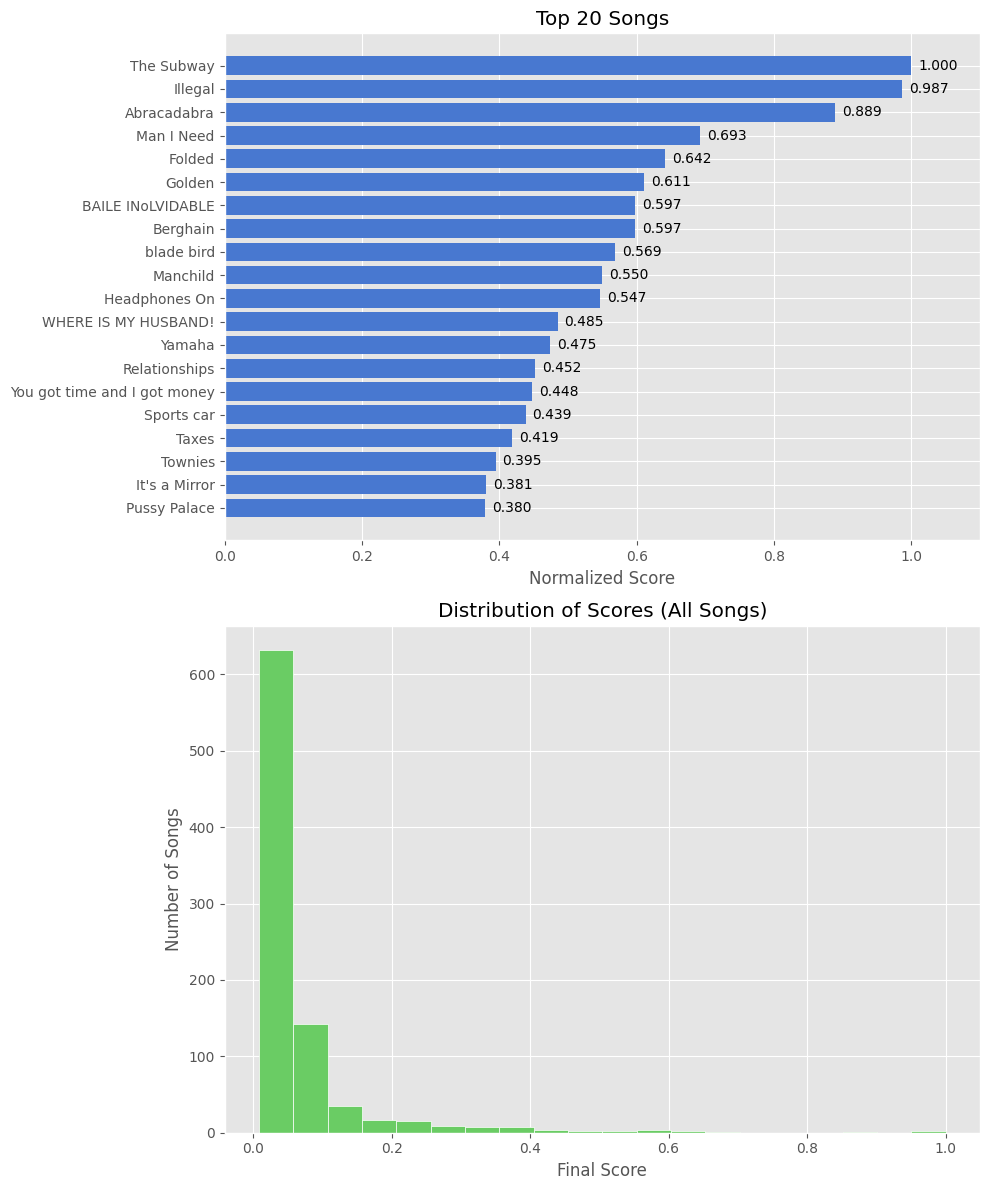

In [167]:
import matplotlib.pyplot as plt


df = scored_df


plt.style.use("ggplot")  # Makes the charts look nicer
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

# Plot A: The Leaderboard (Top 15)
top_n = 20
top_songs = df.head(top_n).sort_values(
    by="score", ascending=True
)  # Reverse for horizontal bar

ax1.barh(top_songs["name"], top_songs["score"], color="#4878d0")
ax1.set_title(f"Top {top_n} Songs")
ax1.set_xlabel("Normalized Score")
ax1.set_xlim(0, 1.1)

# Add score labels on the bars
for index, value in enumerate(top_songs["score"]):
    ax1.text(value + 0.01, index, f"{value:.3f}", va="center")

# Plot B: The Distribution (Histogram)
# This helps you see if your K value is too harsh (skewed left) or too flat.
ax2.hist(df["score"], bins=20, color="#6acc64", edgecolor="white")
ax2.set_title("Distribution of Scores (All Songs)")
ax2.set_xlabel("Final Score")
ax2.set_ylabel("Number of Songs")

plt.tight_layout()
plt.show()

## Rank Variance


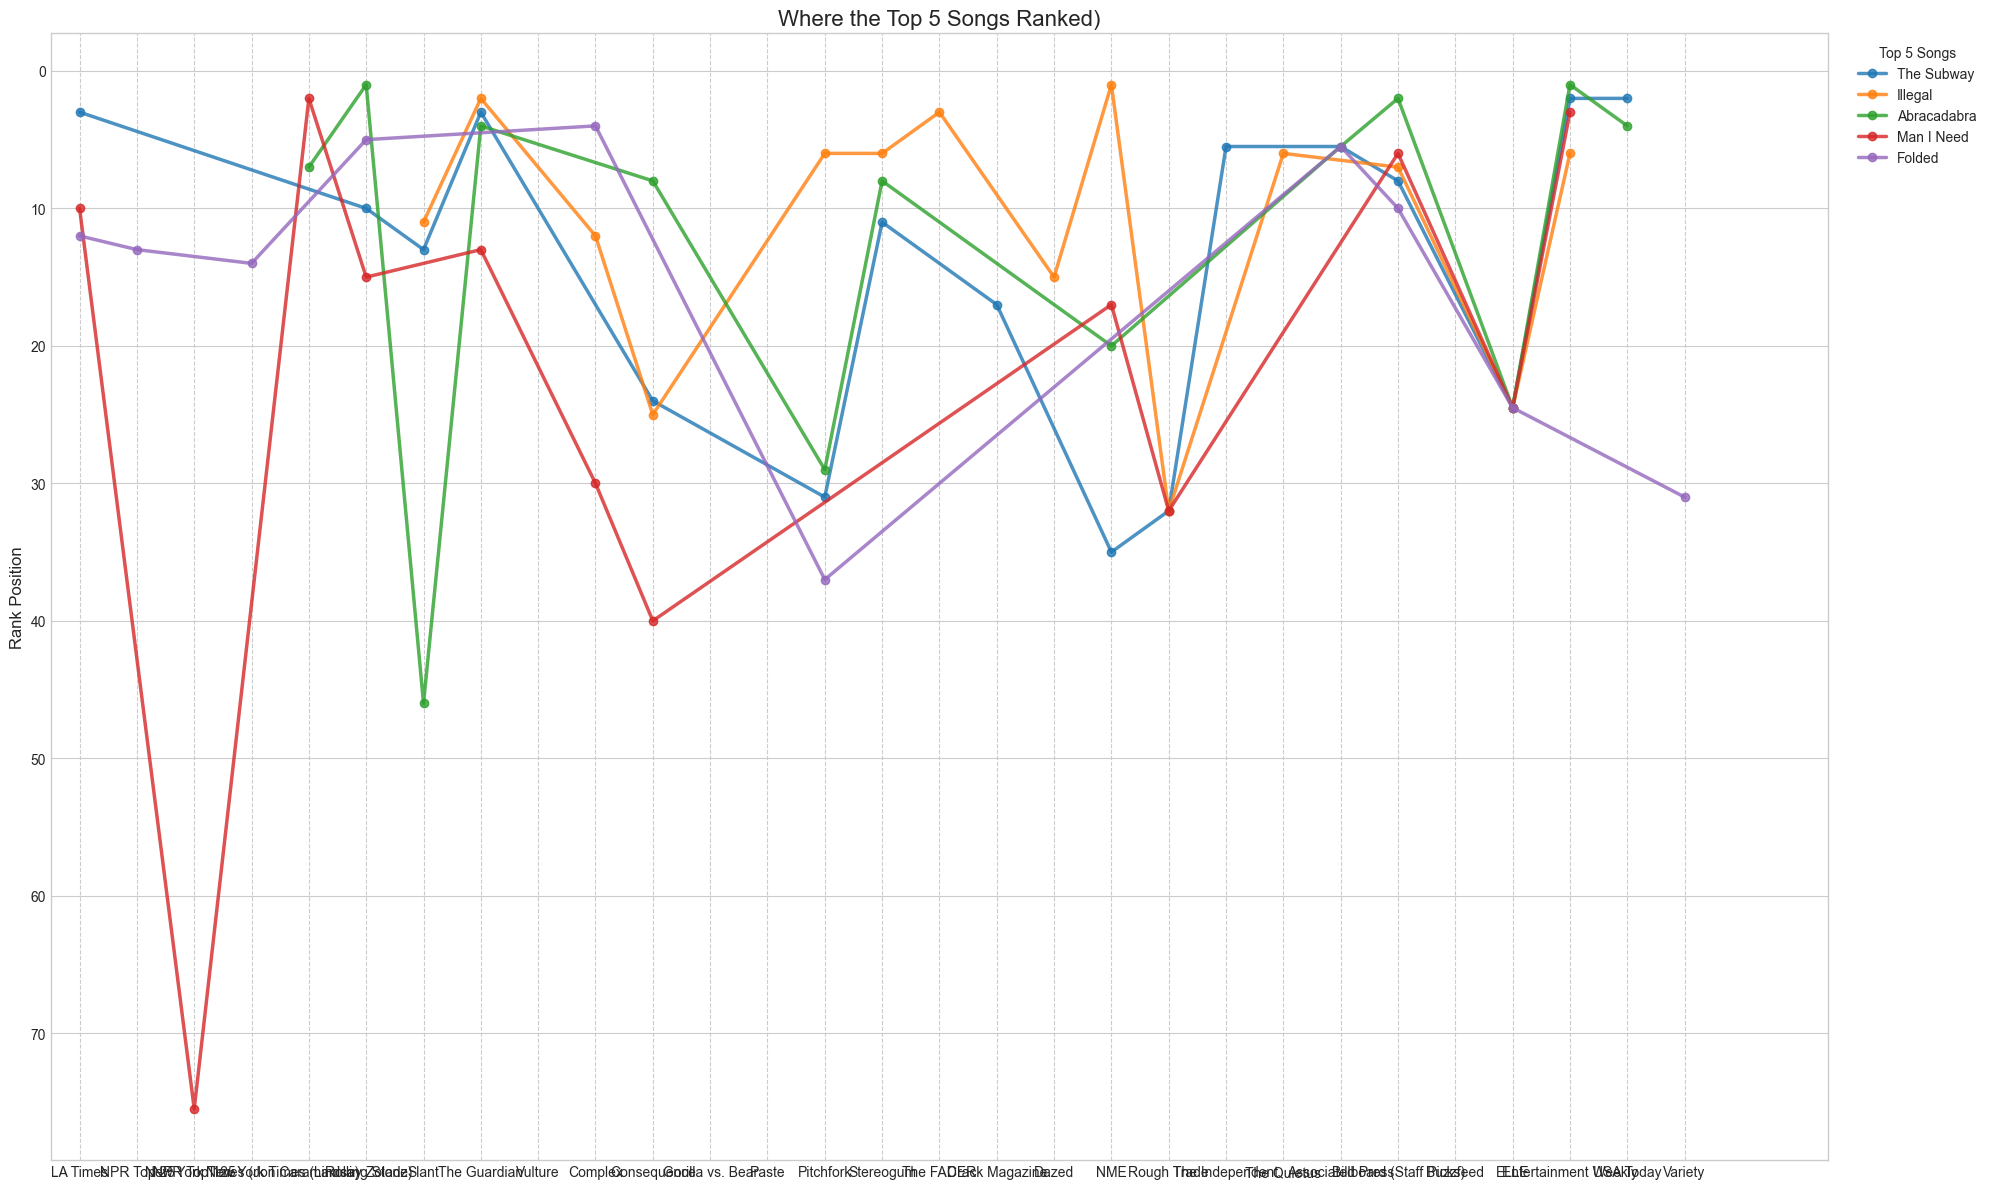

In [168]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- VISUALIZATION CONFIG ---
plt.style.use("seaborn-v0_8-whitegrid")
fig = plt.figure(figsize=(20, 12))  # Adjusted height slightly

# -------------------------------------------
# CHART 1: The "Spaghetti" Plot (Rank Variance)
# -------------------------------------------
ax1 = plt.subplot(1, 1, 1)

N = 5

# 1. Get Top 5 Songs (as per your example)
top_n = df.sort_values(by="score", ascending=False).head(N)

# 2. Create an explicit mapping for the X-axis
# This guarantees order: Rolling Stone=0, Pitchfork=1, etc.
source_map = {name: i for i, name in enumerate(SOURCES.keys())}

# 3. Reshape data for plotting
parallel_data = []
for idx, row in top_n.iterrows():
    for source_name, config in SOURCES.items():
        col_name = "rank" + config["suffix"]
        rank = row.get(col_name)

        # Check if rank exists (not NaN/None)
        if pandas.notna(rank):
            parallel_data.append(
                {
                    "name": row["name"],
                    "source": source_name,
                    "x_pos": source_map[source_name],  # Use integer position
                    "rank": rank,
                }
            )

pdf = pandas.DataFrame(parallel_data)

# 4. Plot lines
# Create a unique color for each song
palette = sns.color_palette("tab10", n_colors=N)

for i, song in enumerate(top_n["name"]):
    # Filter for this song
    song_data = pdf[pdf["name"] == song].copy()

    if not song_data.empty:
        # CRITICAL FIX: Sort by the integer x_pos to prevent backtracking
        song_data = song_data.sort_values("x_pos")

        # Plot X (integers) vs Y (ranks)
        ax1.plot(
            song_data["x_pos"],
            song_data["rank"],
            marker="o",
            linewidth=2.5,
            alpha=0.8,
            label=song,
            color=palette[i],
        )

# 5. Formatting
ax1.invert_yaxis()  # Rank 1 at the top
ax1.set_title(f"Where the Top 5 Songs Ranked)", fontsize=16)
ax1.set_ylabel("Rank Position")
ax1.legend(bbox_to_anchor=(1.01, 1), loc="upper left", title=f"Top {N} Songs")
ax1.grid(axis="x", linestyle="--")

# 6. Force X-Axis Labels using the source_map keys
# We set ticks at 0, 1, 2... and label them with the names
ax1.set_xticks(list(source_map.values()))
ax1.set_xticklabels(list(source_map.keys()))

# Set limits with a little padding so points aren't cut off
ax1.set_xlim(-0.5, len(WEBSITES) - 0.5)

plt.tight_layout()
plt.show()

## Consensus


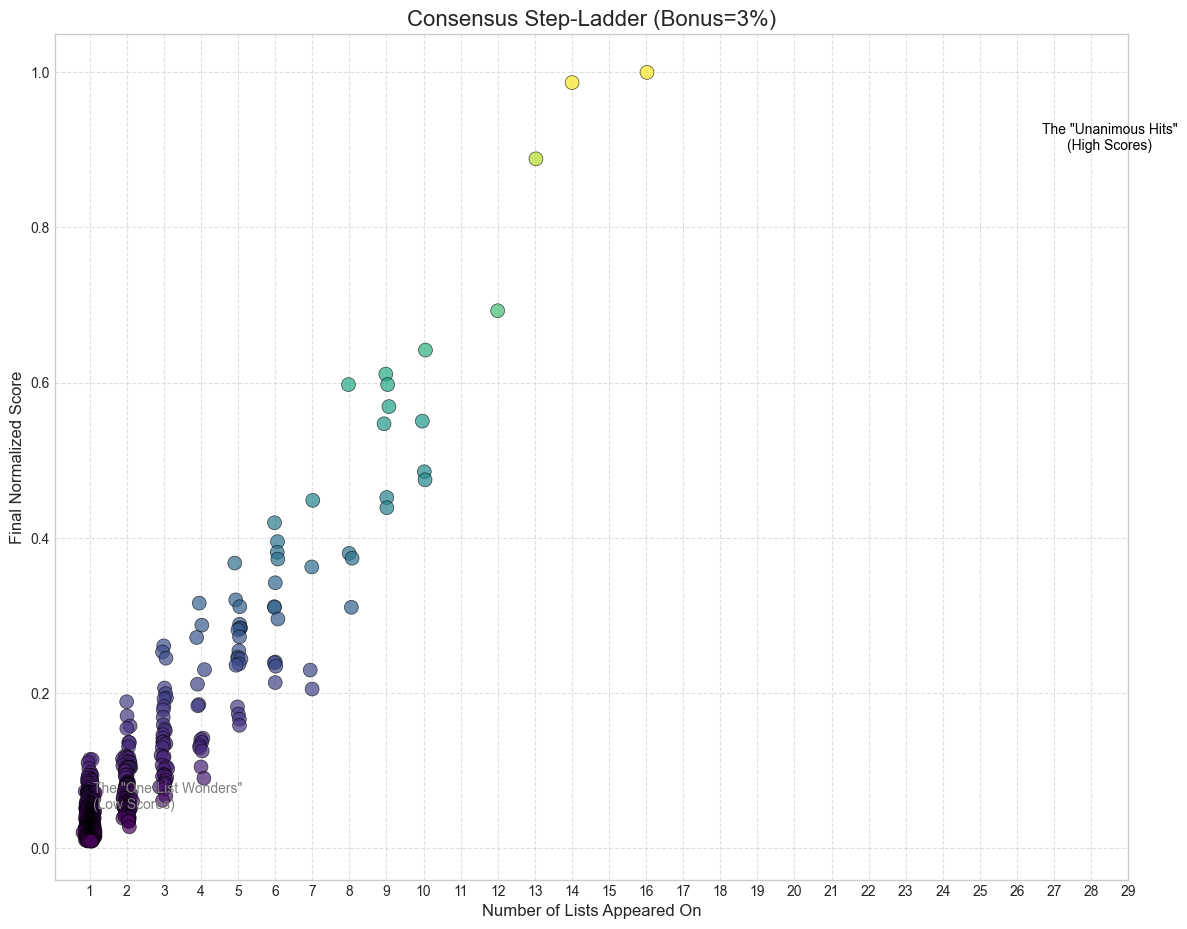

In [169]:
plt.style.use("seaborn-v0_8-whitegrid")
fig = plt.figure(figsize=(12, 18))

# -------------------------------------------
# CHART 2: Consensus vs Score Scatter
# -------------------------------------------
ax2 = plt.subplot(2, 1, 2)

# Scatter plot: X=List Count, Y=Score
# We add small jitter to X so dots don't perfectly overlap
jitter = numpy.random.normal(0, 0.05, len(df))

scatter = ax2.scatter(
    df["list_count"] + jitter,
    df["score"],
    c=df["score"],
    cmap="viridis",
    s=100,
    alpha=0.7,
    edgecolor="k",
)

ax2.set_title(
    f"Consensus Step-Ladder (Bonus={int(gem_ranker.CONSENSUS_BOOST*100)}%)", fontsize=16
)
ax2.set_xlabel("Number of Lists Appeared On")
ax2.set_ylabel("Final Normalized Score")
ax2.set_xticks(range(1, len(SOURCES) + 1))  # Force integer ticks (1, 2, 3...)
ax2.grid(True, linestyle="--", alpha=0.6)

# Annotate the "Zones"
ax2.text(1.1, 0.05, 'The "One-List Wonders"\n(Low Scores)', color="gray", fontsize=10)
# Dynamic placement for the 'Unanimous' label based on max lists
max_lists = len(SOURCES)
ax2.text(
    max_lists - 0.5,
    0.9,
    'The "Unanimous Hits"\n(High Scores)',
    color="black",
    fontsize=10,
    ha="center",
)

plt.tight_layout()
plt.show()

# Coverage Metric

The "Coverage Metric" is simply checking the average number of lists the Top 10 songs appear on.

Why this matters
If your Top 10 average is low (e.g., 2.5), it means a song can crack your Top 10 just by appearing on the NYT Caramanica and NYT Zoldaz lists (high weights) while being ignored by everyone else.

If that happens, you might want to increase the Consensus Bonus to force the algorithm to favor songs that appear on 4+ lists, even if they have slightly lower ranks.


In [170]:
# Check the "Coverage" of your Top Tier
top_5_avg = df.head(5)["list_count"].mean()
top_10_avg = df.head(10)["list_count"].mean()
top_25_avg = df.head(25)["list_count"].mean()
top_50_avg = df.head(50)["list_count"].mean()
top_100_avg = df.head(100)["list_count"].mean()
top_200_avg = df.head(200)["list_count"].mean()
top_500_avg = df.head(500)["list_count"].mean()
all_avg = df["list_count"].mean()
all_median = df["list_count"].median()

stat_lines = list()

stat_lines.append(["Top N","Average reviews per song", "Median reviews per song"])

for count in [5, 10, 25, 50, 100, 200, 500, len(df)]:
    avg = df.head(count)["list_count"].mean()
    median = df.head(count)["list_count"].median()
    name = f"Top {count}" if count != len(df) else f"All ({len(df)})"
    stat_lines.append([name, f"{avg:.2f}", f"{median:.2f}"])

for cols in stat_lines:
    print(",".join(cols))




# --- INTERPRETATION GUIDE ---
# > 4.5:  Strong Consensus. Everyone agrees on the hits. (Safe)
# 3.0 - 4.5: Healthy Mix. The winners are usually on 3-5 lists. (Normal)
# < 3.0:  Fragmented. Your Top 10 is mostly songs that only 2-3 outlets liked.

Top N,Average reviews per song,Median reviews per song
Top 5,13.00,13.00
Top 10,11.00,10.00
Top 25,8.88,9.00
Top 50,6.92,6.00
Top 100,5.16,5.00
Top 200,3.48,3.00
Top 500,2.11,1.00
All (881),1.63,1.00


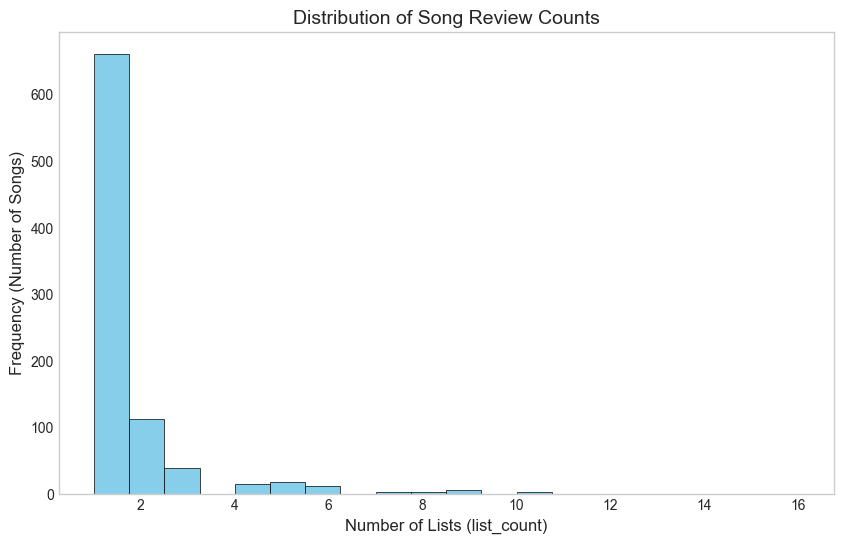

In [171]:
import matplotlib.pyplot as plt

# 1. Create the figure
plt.figure(figsize=(10, 6))

# 2. Plot the histogram using pandas
# 'bins' determines the granularity; 'edgecolor' makes the bars distinct
df['list_count'].hist(
    bins=20, 
    color='skyblue', 
    edgecolor='black', 
    grid=False
)

# 3. Add labels and title
plt.title("Distribution of Song Review Counts", fontsize=14)
plt.xlabel("Number of Lists (list_count)", fontsize=12)
plt.ylabel("Frequency (Number of Songs)", fontsize=12)

# 4. Save as SVG
plt.savefig("outputs/list_count_histogram.svg", format="svg", bbox_inches="tight")

# 5. Show the plot
plt.show()

# Old Final Report 1


In [172]:
# The Refined "Passion Picks" Logic
# 1. High Quality: Must have at least one Top 10 rank.
# 2. Low Consensus: Must appear on 4 or fewer lists.
# 3. Relevance: Must be in the overall Top 50.


def is_passion_pick(row):
    # Check List Count
    if row["list_count"] > 4:
        return False

    # Check for High Heat (Top 10 Rank)
    # (We parse the 'sources' string for any rank <= 10)
    import re

    ranks = re.findall(r"#(\d+\.?\d*)", str(row["sources"]))
    has_top_10 = any(float(r) <= 5 for r in ranks)

    return has_top_10

In [173]:
print("\n" + "=" * 50)
print("🎵 2025 CONSENSUS REPORT 🎵")
print("=" * 50)

final_df = scored_df.copy()

print(f"Total songs: {len(final_df)}")
print(f"Total review sources: {len(SOURCES)}")

# 1. The Winners
print("=" * 50)
top_1 = final_df.iloc[0]
top_2 = final_df.iloc[1]
print(f"🏆 Song of the Year: {top_1['artist']} - {top_1['name']}")
print(f"     Score: {top_1['score']:.4f} | Lists: {int(top_1['list_count'])}")
print(f"     Sources: {top_1['sources']}")
print()
print(f"🥈 Runner Up: {top_2['artist']} - {top_2['name']}")
print(f"     Score: {top_2['score']:.4f} | Lists: {int(top_2['list_count'])}")
print(f"     Sources: {top_2['sources']}")
print()

passion_picks = final_df[final_df.index < 50].copy()
passion_picks = passion_picks[passion_picks.apply(is_passion_pick, axis=1)]

print("-" * 50)
print("🔥 The 'Passion Picks' (High Rank / Low Consensus)")
print(
    "   *Songs in the Top 50 with at least one Top 5 rank, but appearing on ≤ 4 lists*"
)
print()
for i, row in passion_picks.iterrows():
    print(
        f"   #{row['rank']} {row['artist']} - {row['name']} ({int(row['list_count'])} lists)"
    )
    print(f"     Sources: {row['sources']}")
print()

# 3. List Health
print("-" * 50)
print(f"📊 Consensus Health (Total Sources: {len(SOURCES)})")
print(f"   Top 10 Avg: {final_df.head(10)['list_count'].mean():.1f} lists")
print(f"   Top 25 Avg: {final_df.head(25)['list_count'].mean():.1f} lists")
print(f"   Top 50 Avg: {final_df.head(50)['list_count'].mean():.1f} lists")
print(f"   Top 100 Avg: {final_df.head(100)['list_count'].mean():.1f} lists")
print(f"   Top 200 Avg: {final_df.head(200)['list_count'].mean():.1f} lists")


🎵 2025 CONSENSUS REPORT 🎵
Total songs: 881
Total review sources: 29
🏆 Song of the Year: Chappell Roan - The Subway
     Score: 1.0000 | Lists: 16
     Sources: Entertainment Weekly#2, USA Today#2, LA Times#3, The Guardian#3, The Independent#5, Associated Press#5, Billboard (Staff Picks)#8, Rolling Stone#10, Stereogum#11, Slant#13, Crack Magazine#17, Consequence#24, ELLE#24, Pitchfork#31, Rough Trade#32, NME#35

🥈 Runner Up: PinkPantheress - Illegal
     Score: 0.9868 | Lists: 14
     Sources: NME#1, The Guardian#2, The FADER#3, Pitchfork#6, Stereogum#6, The Quietus#6, Entertainment Weekly#6, Billboard (Staff Picks)#7, Slant#11, Complex#12, Dazed#15, ELLE#24, Consequence#25, Rough Trade#32

--------------------------------------------------
🔥 The 'Passion Picks' (High Rank / Low Consensus)
   *Songs in the Top 50 with at least one Top 5 rank, but appearing on ≤ 4 lists*

   #27 EsDeeKid, fakemink, & Rico Ace - LV Sandals (4 lists)
     Sources: Dazed#1, New York Times (Jon Caramanica)#

In [174]:
final_df[["rank", "score", "artist", "name", "list_count", "sources"]].head(
    25
).style.set_properties(
    subset=["artist", "sources"],  # List the columns you want to wrap
    **{"white-space": "pre-wrap", "width": "300px"}  # CSS properties
)

,rank,score,artist,name,list_count,sources
0,1,1.000000,Chappell Roan,The Subway,16,"Entertainment Weekly#2, USA Today#2, LA Times#3, The Guardian#3, The Independent#5, Associated Press#5, Billboard (Staff Picks)#8, Rolling Stone#10, Stereogum#11, Slant#13, Crack Magazine#17, Consequence#24, ELLE#24, Pitchfork#31, Rough Trade#32, NME#35"
1,2,0.986848,PinkPantheress,Illegal,14,"NME#1, The Guardian#2, The FADER#3, Pitchfork#6, Stereogum#6, The Quietus#6, Entertainment Weekly#6, Billboard (Staff Picks)#7, Slant#11, Complex#12, Dazed#15, ELLE#24, Consequence#25, Rough Trade#32"
2,3,0.888522,Lady Gaga,Abracadabra,13,"Rolling Stone#1, Entertainment Weekly#1, Billboard (Staff Picks)#2, The Guardian#4, USA Today#4, Associated Press#5, New York Times (Lindsay Zoladz)#7, Consequence#8, Stereogum#8, NME#20, ELLE#24, Pitchfork#29, Slant#46"
3,4,0.692554,Olivia Dean,Man I Need,12,"New York Times (Lindsay Zoladz)#2, Entertainment Weekly#3, Billboard (Staff Picks)#6, LA Times#10, The Guardian#13, Rolling Stone#15, NME#17, ELLE#24, Complex#30, Rough Trade#32, Consequence#40, NPR Top 125#75"
4,5,0.641840,Kehlani,Folded,10,"Complex#4, Rolling Stone#5, Associated Press#5, Billboard (Staff Picks)#10, LA Times#12, NPR Top 25#13, New York Times (Jon Caramanica)#14, ELLE#24, Variety#31, Pitchfork#37"
5,6,0.610819,"HUNTR/X, EJAE, AUDREY NUNA, REI AMI, & KPop Demon Hunters Cast",Golden,9,"New York Times (Lindsay Zoladz)#1, Billboard (Staff Picks)#1, Rolling Stone#3, Entertainment Weekly#10, Consequence#16, LA Times#17, Complex#24, Variety#31, NME#46"
6,7,0.597304,Bad Bunny,BAILE INoLVIDABLE,8,"LA Times#1, Rolling Stone#4, Entertainment Weekly#4, Complex#6, NME#10, NPR Top 25#13, ELLE#24, Slant#27"
7,8,0.597302,"ROSALÍA, Björk, & Yves Tumor",Berghain,9,"The Guardian#1, Crack Magazine#1, The Quietus#1, The FADER#6, Rolling Stone#14, ELLE#24, Variety#31, Rough Trade#32, Billboard (Staff Picks)#34"
8,9,0.568925,Oklou,blade bird,9,"The FADER#1, New York Times (Lindsay Zoladz)#5, Stereogum#5, Pitchfork#12, NPR Top 25#13, NME#14, Slant#43, Billboard (Staff Picks)#50, Paste#75"
9,10,0.550145,Sabrina Carpenter,Manchild,10,"Billboard (Staff Picks)#4, New York Times (Lindsay Zoladz)#6, Rolling Stone#6, Consequence#10, ELLE#24, Pitchfork#27, Complex#29, Paste#31, Variety#31, NPR Top 125#75"


# YouTube Playlist Creation

Some older code for creating a YouTube playlist for just me.

In [175]:
# import json
# from ytmusicapi import YTMusic

# FETCH_LIVE_YOUTUBE = False

# PLAYLIST_FILENAME = "youtube_playlist_tracks.json"


# if FETCH_LIVE_YOUTUBE:
#     yt = YTMusic("browser.json")
#     # playlists = yt.get_library_playlists()
#     # best_songs_playlist = [pl for pl in playlists if pl['title']=='Best of 2025 Lists'][0]
#     best_songs_playlist_id = "PLp1R3fJI8TQx8yXM4IYz5DwZGXOYehr1f"
#     pl = yt.get_playlist(best_songs_playlist_id, limit=1000, suggestions_limit=0)
#     yt_songs_list = pl["tracks"]

#     with open(PLAYLIST_FILENAME, "w", encoding="utf-8") as f:
#         f.write(json.dumps(yt_songs_list))
# else:
#     with open(PLAYLIST_FILENAME, "r", encoding="utf-8") as f:
#         yt_songs_list = json.loads(f.read())

In [176]:
for _, row in top25_df.iterrows():
    print(f'{row["artist"]} {row["name"]} youtube_id:{row["youtube_id"]}')

Chappell Roan The Subway youtube_id:woLfAvD5iXI
PinkPantheress Illegal youtube_id:TFWXqLSr4ZM
Lady Gaga Abracadabra youtube_id:vBynw9Isr28
Olivia Dean Man I Need youtube_id:oIv_Y2RPQ_A
Kehlani Folded youtube_id:KFMYx1TibeQ
HUNTR/X, EJAE, AUDREY NUNA, REI AMI, & KPop Demon Hunters Cast Golden youtube_id:yebNIHKAC4A
Bad Bunny BAILE INoLVIDABLE youtube_id:a1Femq4NPxs
ROSALÍA, Björk, & Yves Tumor Berghain youtube_id:htQBS2Ikz6c
Oklou blade bird youtube_id:Tgw9cFdCPxU
Sabrina Carpenter Manchild youtube_id:aSugSGCC12I
Addison Rae Headphones On youtube_id:XdFpzaM07i0
RAYE WHERE IS MY HUSBAND! youtube_id:rK5TyISxZ_M
Dijon Yamaha youtube_id:AJGS18kol_U
HAIM Relationships youtube_id:dOI_QTmK8Ks
Smerz You got time and I got money youtube_id:LzEzE3cpuvg
Tate McRae Sports car youtube_id:7InTkBxPtK4
Geese Taxes youtube_id:Phh3oVCtzBg
Wednesday Townies youtube_id:E8cKoQqdtwA
Perfume Genius It's a Mirror youtube_id:hx2_NGaDPrk
Lily Allen Pussy Palace youtube_id:xqRNYtiAAP8
Alex G Afterlife youtube_id:

# YouTube Music

Should move this to the pre-dataframe section too.

Ideally we can find the YouTube Music id and link for each unique song, too.

It seems like yt_auth with the songs filter does a good job.


In [177]:
from ytmusicapi import YTMusic

# Authenticate using the file you generated
yt_auth = YTMusic("browser.json")

In [178]:
def print_youtube_music_search_result(result):
    artists = oxford_comma_join([a["name"] for a in result["artists"]])
    print(f"{artists} -- {result['title']}")
    print(f"  category: {result['category']} type: {result['resultType']}")
    print(f"  videoId: {result['videoId']} videoType: {result['videoType']}")
    print(f"  explicit: {result['isExplicit']}")
    print(f"  year: {result['year']} views: {result['views']}")


def print_youtube_music_search_results(results):
    for i, result in enumerate(results):
        print(f"===== Result {i} =====")
        print_youtube_music_search_result(result)

In [179]:
import time


YOUTUBE_MUSIC_SEARCH_CACHE_FILENAME = "caches/youtube_music_search.json"


def load_youtube_search_songs_cache(filename):
    print("Reading YouTube Music Search cache")
    with open(filename, "r", encoding="utf-8") as f:
        yt_music_cache = json.load(f)
    print(f"Total keys: {len(yt_music_cache)}")
    return yt_music_cache


def save_youtube_search_songs_cache(filename, yt_music_cache):
    with open(filename, "w", encoding="utf-8") as f:
        print("Writing YouTube Music Search cache")
        json.dump(yt_music_cache, f, indent=4)


def make_youtube_music_search_query(artists, name):
    return f"{artists} {name}"


def search_youtube_songs_from_text(artists, name, youtube_search_songs_cache, stats):
    query = make_youtube_music_search_query(artists, name)
    results = youtube_search_songs_cache.get(query, None)

    if results is not None:
        stats["main_cache_hits"] += 1
        return results
    stats["search_api_calls"] += 1
    results = yt_auth.search(query, filter="songs", limit=1)

    # Surely there's a better way to do this?
    # Spotify's API had nice mechanisms for slowing down
    time.sleep(0.5)

    if results is not None and results:
        youtube_search_songs_cache[query] = results
        stats["search_api_results"] += 1
        return results
    stats["search_api_no_rseults"] += 1
    print(f"No results found for {query}")
    return None

In [180]:
if os.path.exists(YOUTUBE_MUSIC_SEARCH_CACHE_FILENAME):
    youtube_search_songs_cache = load_youtube_search_songs_cache(
        YOUTUBE_MUSIC_SEARCH_CACHE_FILENAME
    )
else:
    youtube_search_songs_cache = dict()

Reading YouTube Music Search cache
Total keys: 883


In [181]:



def verify_youtube_song_match_v4(canon_artist, canon_song, yt_artist, yt_title):
    # 1. Cleaner Function (Updated with Feature Noise)
    def get_clean_tokens(text):
        if not text:
            return set()
        text = text.casefold()

        # Metadata Noise
        meta_noise = r"\b(official|video|audio|music video|lyric|lyrics|visualizer|mv|hq|4k|hd|topic|vevo)\b"
        text = re.sub(meta_noise, "", text)

        # Feature/Credit Noise (New!)
        feat_noise = r"\b(feat|ft|featuring|with|prod|produced|by)\b"
        text = re.sub(feat_noise, "", text)

        text = re.sub(r"[^a-z0-9\s]", " ", text)
        return set(text.split())

    # 2. Extract Sets
    canon_artist_tokens = get_clean_tokens(canon_artist)
    canon_song_tokens = get_clean_tokens(canon_song)
    yt_artist_tokens = get_clean_tokens(yt_artist)
    yt_title_tokens = get_clean_tokens(yt_title)

    # 3. Artist Check (Jaccard)
    artist_intersection = canon_artist_tokens.intersection(yt_artist_tokens)
    artist_union = canon_artist_tokens.union(yt_artist_tokens)
    artist_score = len(artist_intersection) / len(artist_union) if artist_union else 0.0

    # 4. Smart Title Check (Feature Reduction)
    # Remove artist names from the Canonical Song Title to identify the "Core Title"
    # e.g. "Afraid (feat. Nate Sib)" - "Nate Sib" = "Afraid"
    unique_song_tokens = canon_song_tokens - canon_artist_tokens

    # Safety: If removing artist tokens makes title empty (e.g. "Iron Maiden" - "Iron Maiden"),
    # revert to full tokens.
    if not unique_song_tokens:
        unique_song_tokens = canon_song_tokens

    # Calculate Containment on the CORE title
    song_intersection = unique_song_tokens.intersection(yt_title_tokens)
    title_containment = (
        len(song_intersection) / len(unique_song_tokens) if unique_song_tokens else 0.0
    )

    # 5. Critical Flags
    yt_title_folded = yt_title.casefold()
    canon_song_folded = canon_song.casefold()

    warnings = []
    if LIVE_CHECK_RE.search(yt_title_folded) and not LIVE_CHECK_RE.search(
        canon_song_folded
    ):
        warnings.append("LIVE")
    if "remix" in yt_title_folded and "remix" not in canon_song_folded:
        warnings.append("REMIX")

    # 6. Final Decision Logic
    is_match = False

    # CASE A: Strong Match
    if artist_score > 0.5 and title_containment > 0.6:
        is_match = True

    # CASE B: Perfect Title Containment (1.0) allows weaker Artist match (e.g. 0.3)
    elif artist_score > 0.3 and title_containment == 1.0:
        is_match = True

    if warnings:
        is_match = False

    return {
        "artist_score": round(
            artist_score, 3
        ),  # Returning artist score as primary metric for reference
        "title_containment": round(title_containment, 3),
        "is_safe": is_match,
        "warnings": warnings,
    }


def verify_youtube_match(canon_artist, canon_song, yt_artists, yt_title):
    data = verify_youtube_song_match_v4(canon_artist, canon_song, yt_artists, yt_title)

    if not data["is_safe"]:
        print(
            f"⚠️ Low confidence match is_safe:{data['is_safe']}, artist_score:{data['artist_score']:0.3f}, title_containment:{data['title_containment']}, warnings:{data['warnings']}:"
        )
        print(f"    original: {canon_artist} - {canon_song}")
        print(f"       found: {yt_artists} - {yt_title}")
        data = {
            "artist": canon_artist,
            "name": canon_song,
            "yt_artist": yt_artists,
            "yt_name": yt_title,
            "is_safe": data["is_safe"],
            "artist_score": data["artist_score"],
            "title_containment": data["title_containment"],
            "warnings": data["warnings"],
        }
        return False, data

    return True, {}


def find_youtube_music_ids_for_row(
    row, youtube_search_songs_cache, ytm_manual_overrides_map, stats
):
    artist = row["artist"]
    name = row["name"]

    override = ytm_manual_overrides_map.get((artist, name), None)
    manual_override_allows_match = False
    if override is not None:
        assert pandas.notna(override["status"])
        if override["status"] == "bad":
            stats["known_no_ytm_id_available"] += 1
            return None, {
                "artist": artist,
                "name": name,
                "warnings": "Known missing YTM",
            }

        if override["status"] == "manual fix":
            print(
                f'Manual override for ytm id for {artist} - {name} => {override["manual_ytm_id"]}'
            )
            stats["manual_ytm_id_overrides"] += 1
            return override["manual_ytm_id"], None

        assert (
            override["status"] == "ok"
        ), f'Unknown manual override status: {override["status"]}'
        manual_override_allows_match = True

    results = search_youtube_songs_from_text(
        artist, name, youtube_search_songs_cache, stats
    )

    # This will probably never happen since YouTube search seems to always
    # return something
    if results is None or not results:
        stats["youtube_music_search_results_not_found"] += 1
        print(f'No results for: {row["artist"]}, {row["name"]}')
        return None, {
            "artist": artist,
            "name": name,
            "warnings": "No results found",
        }

    yt_artists = oxford_comma_join([a["name"] for a in results[0]["artists"]])
    yt_title = results[0]["title"]
    is_ok, data = verify_youtube_match(artist, name, yt_artists, yt_title)

    if is_ok or manual_override_allows_match:
        if manual_override_allows_match:
            print(f"Manual override allowed match: {data}")
        stats["good_matches"] += 1
        return results[0]["videoId"], None

    stats["bad_matches"] += 1
    return None, {
        "artist": artist,
        "name": name,
        "warnings": "Bad match",
        "data": results[0],
    }


def find_youtube_music_ids(
    df, youtube_search_songs_cache, ytm_manual_overrides_map, stats
):
    results = df.apply(
        lambda row: find_youtube_music_ids_for_row(
            row, youtube_search_songs_cache, ytm_manual_overrides_map, stats
        ),
        axis=1,
        result_type="expand",
    )
    ids = results[0]
    mismatch_data = results[1]
    return ids, mismatch_data


def load_ytm_manual_overrides():
    df = pandas.read_csv("ytm_manual_overrides.csv", encoding="utf-8")
    overrides = df.to_dict(orient="records")
    overrides_map = {}
    for override in overrides:
        artist = override["artist"]
        name = override["name"]
        if override["status"] == "bad":
            overrides_map[(artist, name)] = {
                "status": "bad",
            }
            continue
        if override["status"] == "ok":
            overrides_map[(artist, name)] = {
                "status": "ok",
            }
            continue

        assert (
            override["status"] == "manual fix"
            and "manual_ytm_id" in override
            and override["manual_ytm_id"]
        ), f"Missing manual fix override for {override}"

        overrides_map[(artist, name)] = {
            "status": override["status"],
            "manual_ytm_id": override["manual_ytm_id"],
        }
    return overrides_map


ytm_manual_overrides_map = load_ytm_manual_overrides()

df = scored_df

stats = Counter()

ids, problem_cases = find_youtube_music_ids(
    df, youtube_search_songs_cache, ytm_manual_overrides_map, stats
)

save_youtube_search_songs_cache(
    YOUTUBE_MUSIC_SEARCH_CACHE_FILENAME, youtube_search_songs_cache
)

print(
    len(
        [
            pc
            for pc in problem_cases
            if pc is not None and pc["warnings"] != "Known missing YTM"
        ]
    )
)

Manual override for ytm id for Hayley Williams - True Believer => ZRH5vhscJZY
Manual override for ytm id for Blood Orange, Tariq Al-Sabir, Caroline Polachek, Daniel Caesar, & The Durutti Column - The Field (feat. The Durutti Column, Tariq Al-Sabir, Caroline Polachek & Daniel Caesar) => Brt_wrBrSqQ
Manual override for ytm id for CMAT - EURO-COUNTRY => J460K30r-I8
Manual override for ytm id for Blood Orange, Caroline Polachek, Lorde, & Mustafa - Mind Loaded (feat. Caroline Polachek, Lorde & Mustafa) => GF26hSpP1Jg
Manual override for ytm id for Deftones - milk of the madonna => vfsg12xVUVo
Manual override for ytm id for Tame Impala - End Of Summer => shCZFUWFscA
Manual override for ytm id for Safe Mind, LUCY (Cooper B. Handy), & Augustus Muller - Standing on Air => kWdBbX8VPko
Manual override for ytm id for Hayley Williams - Mirtazapine => h5E6JY3mmoE
Manual override for ytm id for Greazy Alice - Just Another One => 7uocCB9Nq68
Manual override for ytm id for Silvana Estrada - Dime => sQ9

In [182]:
# We should have dealt with any problems by adding a manual override entry
assert not [
    problem
    for problem in problem_cases
    if problem is not None and problem["warnings"] != "Known missing YTM"
]

In [183]:
def convert_problem_to_yt_problems_spreadsheet_df(problem_cases):
    records = list()
    for problem in [
        problem
        for problem in problem_cases
        if problem is not None and problem["warnings"] != "Known missing YTM"
    ]:
        record = {
            "artist": problem["artist"],
            "name": problem["name"],
            "yt_artist": ", ".join(
                [artist["name"] for artist in problem["data"]["artists"]]
            ),
            "yt_name": problem["data"]["title"],
            "warnings": problem["warnings"],
            "found_yt_id": problem["data"]["videoId"],
        }
        records.append(record)
    return pandas.DataFrame.from_records(records)


yt_problems_df = convert_problem_to_yt_problems_spreadsheet_df(problem_cases)
yt_problems_df.to_csv("outputs/youtube_problems.csv", index=False, encoding="utf-8")

In [184]:
df["ytm_id"] = ids
df["ytm_problem"] = [pc["warnings"] if pc is not None else None for pc in problem_cases]

print(f"Total songs: {len(df)}")

print(f"Total songs with spotify IDs: {len(df[df['spotify_id'].notna()])}")

print(f"Total songs with YTM IDs: {len(df[df['ytm_id'].notna()])}")

print(f"Total songs with YouTube IDs: {len(df[df['youtube_id'].notna()])}")

print(
    f"Total songs with YouTube OR YTM IDs: {len(df[(df['youtube_id'].notna()) | (df['ytm_id'].notna())])}"
)

print(
    f"Total songs in top 25 with YouTube IDs: {len(top25_df[top25_df['youtube_id'].notna()])} / {len(top25_df)}"
)

print(
    f"Total songs in top 50 with YouTube IDs: {len(top50_df[top50_df['youtube_id'].notna()])} / {len(top50_df)}"
)

print(
    f"Total songs in top 100 with YouTube IDs: {len(top100_df[top100_df['youtube_id'].notna()])} / {len(top100_df)}"
)

Total songs: 881
Total songs with spotify IDs: 869
Total songs with YTM IDs: 873
Total songs with YouTube IDs: 407
Total songs with YouTube OR YTM IDs: 875
Total songs in top 25 with YouTube IDs: 25 / 25
Total songs in top 50 with YouTube IDs: 49 / 50
Total songs in top 100 with YouTube IDs: 93 / 100


# YouTube Video Search

Should probably move this to the pre-dataframe section too.

In [185]:
import re


YOUTUBE_VIDEO_SEARCH_CACHE_FILENAME = "caches/youtube_video_search_cache.json"


yt_video_search_cache = dict()
stats = Counter()

if os.path.exists(YOUTUBE_VIDEO_SEARCH_CACHE_FILENAME):
    with open(YOUTUBE_VIDEO_SEARCH_CACHE_FILENAME, "r", encoding="utf-8") as f:
        yt_video_search_cache = json.load(f)


def find_official_video_smart(
    yt, canon_artist, canon_song, yt_video_search_cache, stats
):
    # Search for videos only
    # Note: We append "official video" to the query to guide the search algorithm,
    # but we won't strictly require those words in the result title anymore.
    query = f"{canon_artist} {canon_song} official video"

    results = yt_video_search_cache.get(query, None)
    if results is not None:
        stats["ytv_cache_hits"] += 1
    else:
        stats["ytv_api_calls"] += 1
        # Calling search with filter='videos' is crucial to getting videoType
        results = yt.search(query, filter="videos", limit=5)
        yt_video_search_cache[query] = results
        time.sleep(0.5)

    if not results:
        return None, None, None, "No API results"

    best_score = -1
    best_video_id = None
    best_video_result = None
    messages = []

    # Pre-compute canonical forms for strict matching
    # Remove all non-alphanumeric characters for "Containment" checks
    canon_song_simple = re.sub(r"[^a-z0-9]", "", canon_song.casefold())
    canon_artist_simple = re.sub(r"[^a-z0-9]", "", canon_artist.casefold())

    for i, vid in enumerate(results):
        title = vid.get("title", "")
        channel = vid["artists"][0]["name"] if vid.get("artists") else ""
        v_type = vid.get("videoType", "")

        # --- GATE 1: Video Type ---
        # We implicitly trust YouTube's classification for OMV (Official Music Video).
        # We also allow ATV (Art Track) but we will score it lower.
        if v_type not in ["MUSIC_VIDEO_TYPE_OMV", "MUSIC_VIDEO_TYPE_ATV"]:
            # messages.append(f"{i}: {title}... [Skip: {v_type}]")
            continue

        title_lower = title.casefold()
        channel_lower = channel.casefold()
        title_simple = re.sub(r"[^a-z0-9]", "", title_lower)
        channel_simple = re.sub(r"[^a-z0-9]", "", channel_lower)

        # --- GATE 2: Identity Check (The Safety Net) ---
        # 1. Title Containment: The song title MUST be inside the video title.
        #    (e.g. searching for 'Pussy Palace' -> 'Pussy Palace (Official)' is good)
        if canon_song_simple not in title_simple:
            messages.append(f"{i}: Fail: Title Mismatch {channel} -- {title}")
            continue

        # 2. Artist Check: The artist name must effectively be the channel
        #    or strictly contained within the channel name (e.g. 'Lily Allen' in 'LilyAllenVEVO')
        #    or the channel is inside the artist name (rare, but handles 'Topic' channels).
        if (
            canon_artist_simple not in channel_simple
            and channel_simple not in canon_artist_simple
        ):
            messages.append(f"{i}: Fail: Artist Mismatch {channel} -- {title}")
            continue

        # --- SCORING ENGINE ---
        score = 0

        # BASE SCORE based on Trustworthiness of the Type
        if v_type == "MUSIC_VIDEO_TYPE_OMV":
            score = 100  # It's an Official Music Video. Start high.
        elif v_type == "MUSIC_VIDEO_TYPE_ATV":
            score = 10  # It's just audio. Low priority fallback.

        # BONUSES (Tie-Breakers)
        if "official video" in title_lower or "official music video" in title_lower:
            score += 10
        if "director's cut" in title_lower:
            score += 5

        # PENALTIES (The "Cleanliness" Check)
        if "visualizer" in title_lower:
            score -= 20  # Prefer real videos over visualizers
        if "lyric" in title_lower:
            score -= 30  # Prefer real videos over lyric videos
        if "live" in title_lower and "live" not in canon_song.casefold():
            score -= 100  # We usually want the studio version
        if "remix" in title_lower and "remix" not in canon_song.casefold():
            score -= 100  # Wrong song version

        # Update Best
        messages.append(f"{i}: {title[:20]}... [Score: {score}]")

        if score > best_score:
            best_score = score
            best_video_id = vid["videoId"]
            best_video_result = vid

    # Final Threshold
    # We accept OMV (100) even with a visualizer penalty (80).
    # We accept Clean OMV (100).
    # We reject ATV (10) if you strictly want a *Video* ID to complement your Audio ID.
    if best_score >= 50:
        title = best_video_result.get("title", "")
        channel = (
            best_video_result["artists"][0]["name"]
            if best_video_result.get("artists")
            else ""
        )
        v_type = best_video_result.get("videoType", "")
        return (
            best_video_id,
            best_score,
            best_video_result,
            f"Matched {best_score}: {channel} -- {title} ({v_type})",
        )

    return None, None, None, " | ".join(messages)


def find_official_video_strict_for_row(row, yt, yt_video_search_cache, stats):
    artist = row["artist"]
    name = row["name"]
    if pandas.notna(row["youtube_id"]):
        return None, None, None, "preferred_source"
    return find_official_video_smart(yt, artist, name, yt_video_search_cache, stats)


def add_youtube_video_results(df, yt, yt_video_search_cache, stats):
    results = df.apply(
        lambda row: find_official_video_strict_for_row(
            row, yt, yt_video_search_cache, stats
        ),
        axis=1,
        result_type="expand",
    )
    df["youtube_video_found_id"] = results[0]
    df["youtube_video_found_score"] = results[1]
    df["video_search_msg"] = results[3]
    return df

In [186]:
df = add_youtube_video_results(df, yt_auth, yt_video_search_cache, stats)

In [187]:
with open(YOUTUBE_VIDEO_SEARCH_CACHE_FILENAME, "w", encoding="utf-8") as f:
    print("Writing YouTube Video Search cache")
    json.dump(yt_video_search_cache, f, indent=4)

Writing YouTube Video Search cache


In [188]:
for song_list in all_songs_lists:
    for song in song_list:
        if song.artist == "Deftones" and song.name=="Ecdysis":
            print(song.youtube_id)
            print(song)

B8qbrHS3yTQ
Song(name='Ecdysis', artist='Deftones', featuring=None, rank=2, source='Vulture', description='Each song on the band’s new album Private Music is a nesting doll of hooks, with new melodies bursting unexpectedly from an already bright display. “Ecdysis” is a highlight: Singer Chino Moreno waxes grimly about climate change drawing the curtains on society while bristling, beautiful riff after riff unfurls under him. Those riffs are almost catchy enough to distract from lyrics that anticipate a post-human Earth: “This town becomes a lake!” But once you catch the images of cleansing fire and flooding, it feels like the scorching guitar work and aqueous effects are all just as interested in painting a picture of apocalypse.', isrc='USRE12500231', youtube_id='B8qbrHS3yTQ', spotify_id='4JV3BjszeEUD1bTTcx9hdx', other_url=None, canonical_artist='Deftones', canonical_name='ecdysis', spotify_is_playable=True, spotify_popularity=65, id='USRE12500231', is_manual_override=False, spotify_a

In [189]:
scored_df[scored_df['artist'].str.contains('Deftones')][["name", 'youtube_id', 'youtube_video_found_id', 'youtube_video_found_score']]

,name,youtube_id,youtube_video_found_id,youtube_video_found_score
100,ecdysis,B8qbrHS3yTQ,None,NaN
152,milk of the madonna,None,D1zErtM1r2c,100.0
250,infinite source,U_uVVO7eGic,None,NaN


# Add review quotes

Another thing I probably should've done up at the Song level.

This calls an Anthropic Claude model (first Haiku then Sonnet as a fallback) to try to extract a very short, verifiable quote about the song from the mini-review.

quoted_df will have everything so far plus the quote data

In [190]:
from dotenv import load_dotenv

print("Working directory:", os.getcwd())

# Check if .env exists there
print(".env exists:", os.path.exists(".env"))

result = load_dotenv(verbose=True, override=True)
print("load_dotenv returned:", result)

# print(os.environ.get("ANTHROPIC_API_KEY"))

Working directory: /Users/eea1/projects/consensus-best-songs-2025/python/notebooks
.env exists: True
load_dotenv returned: True


In [191]:
import anthropic
import instructor
import asyncio
import pandas
import hashlib
from pydantic import BaseModel, Field
from typing import Literal
from tqdm.asyncio import tqdm_asyncio
from collections import Counter
from instructor.exceptions import InstructorRetryException


class QuoteExtraction(BaseModel):
    quote: str = Field(description="The extracted quote")
    is_usable: bool = Field(description="Whether the quote is good enough to use")
    issue: Literal[
        "none",
        "no_descriptive_content",  # Review is purely biographical/news, no music description
        "only_negative",  # Review is critical with no positive phrases
        "too_vague",  # Only vague praise like "it's good"
        "could_not_shorten",  # Good content but couldn't extract a short enough quote
    ] = Field(description="If not usable, why; 'none' if usable")


ANTHROPIC_EXTRACT_QUOTE_CACHE_FILENAME = "caches/anthropic_extract_quote_cache.json"


def load_anthropic_extract_quote_cache(filename=ANTHROPIC_EXTRACT_QUOTE_CACHE_FILENAME):
    print("Reading Anthropic extract quote cache")
    with open(filename, "r", encoding="utf-8") as f:
        cache = json.load(f)
    print(f"Total keys: {len(cache)}")
    return cache


def save_anthropic_extract_quote_cache(
    cache, filename=ANTHROPIC_EXTRACT_QUOTE_CACHE_FILENAME
):
    with open(filename, "w", encoding="utf-8") as f:
        print(f"Writing Anthropic extract quote cache, keys: {len(cache)}")
        json.dump(cache, f, indent=4)


# Arguably should include the MD5 of the prompt here!
def make_anthropic_extract_quote_cache_key(artist, name, review_col, model):
    return " ::: ".join(
        [
            artist,
            name,
            review_col,
            model,
        ]
    )


def make_extract_quote_prompt(artist, name, review):
    return f"""You are an expert editor and copywriter for the New York Times.
    
Extract a short compelling quote from this review of "{name}" by {artist}.

The quote should:
- Ideally fit on one short line (1 sentence or less)
- Capture why the song is noteworthy
- Follow standard journalistic quotation conventions (NYT style)

Extraction techniques (in order of preference):
1. Direct extraction: Pull a complete phrase or sentence verbatim
2. Ellipsis assembly: Use " ... " to join non-adjacent parts from the SAME sentence
   - Each part between " ... " must be an exact substring of the review
   - The assembled quote must preserve the original meaning
3. Bracket insertions: Use [brackets] ONLY for minimal grammatical adjustments when extracting mid-sentence
   - Capitalization changes: "[A] pop song" when original started lowercase mid-sentence
   - Clarifying pronouns: "[The song] hits hard" when original used "it" or "this"
   - Tense/form adjustments: "[is] destined" only when grammatically necessary
   - Brackets should be rare and minimal - a few words at most

Rules:
- Text OUTSIDE brackets must be EXACT substrings of the review (verified programmatically)
- Brackets are for minimal grammatical glue, NOT for paraphrasing or adding new ideas
- NEVER alter words outside of brackets
- Prefer direct extraction; use " ... " sparingly; use brackets only when necessary
- If you can't extract a clean quote without heavy bracket use, mark is_usable: False

Issue field guidance:
- "none": Quote is usable
- "no_descriptive_content": Review is purely biographical/news with no description of the music itself
- "only_negative": Review is critical with no positive or neutral descriptive phrases
- "too_vague": Only contains vague praise like "it's good" or "great song" with no substance
- "could_not_shorten": Review has good content but it's all in long complex sentences that can't be extracted cleanly

Example
Review: "Stick" stands out among the two-minute wonders on the 25-year-old U.K. rapper-producer's third project — a brisk, ambitious survey of trap, Afrobeats, R&B, rock, and boom bap. With utility player Joe Stanley in tow, Jim surveys tough times sweetly.
Quote: surveys tough times sweetly
is_usable: True
issue: none

Example
Review: His words, fenced by weapons of Americana and swampy, twangy pastorals, will show you life and death through the necessary, oft-harsh artifacts found in-between.
Quote: swampy, twangy pastorals ... show you life and death
is_usable: True
issue: none

Example  
Review: The meme is cute. The song is cute, too – a giddy, stoned flirtation rendered in dance-pop form, hinting at a nervous longing just beneath the surface.
Quote: a giddy, stoned flirtation ... hinting at a nervous longing just beneath the surface
is_usable: True
issue: none

Example
Review: It hits like a storm gale, distilling '90s rave energy and smouldering dance-pop lyricism into a young, fun banger.
Quote: [It] hits like a storm gale
is_usable: True
issue: none

Example
Review: Sometimes, a pop song is so undeniable that it's destined to be a smash, regardless of whether it's sung by a familiar supergroup or an unknown group.
Quote: [A] pop song is so undeniable that it's destined to be a smash
is_usable: True
issue: none

Example
Review: The track works because she leans into the vulnerability, and the production matches her emotional intensity perfectly.
Quote: [She] leans into the vulnerability ... the production matches her emotional intensity perfectly
is_usable: True
issue: none

Example
Review: The singer announced the album on Instagram last week and will tour in support of it this fall. Tickets go on sale Friday.
Quote: 
is_usable: False
issue: no_descriptive_content

Example
Review: The production is cluttered and the lyrics feel phoned in. A disappointing follow-up.
Quote:
is_usable: False
issue: only_negative

Review text:
{review}"""


async def extract_quote(
    client: instructor.AsyncInstructor,
    prompt: str,
    artist: str,
    name: str,
    review: str,
    review_col: str,
    anthropic_extract_quote_model: str,
    stats: Counter,
) -> dict:
    stats["extract_api_calls"] += 1
    result = await client.messages.create(
        model=anthropic_extract_quote_model,
        max_tokens=512,
        response_model=QuoteExtraction,
        messages=[
            {
                "role": "user",
                "content": prompt,
            }
        ],
    )

    extracted = result.quote if result.is_usable else None
    results = {
        "artist": artist,
        "name": name,
        "review_col": review_col,
        "extracted_quote": extracted,
        "is_usable": result.is_usable,
        "issue": result.issue,
        "review": review,
    }

    return results


# inputs is a list of dicts with 'artist', 'name', 'review', and 'review_col'
async def process_all(
    client: instructor.AsyncInstructor,
    inputs: list,
    anthropic_extract_quote_cache: dict,
    anthropic_extract_quote_model: str,
    stats: Counter,
    max_concurrent: int = 3,
) -> list[dict]:
    semaphore = asyncio.Semaphore(max_concurrent)
    backoff = 3.0  # Dynamic backoff multiplier in seconds

    async def bounded_extract(song: dict) -> dict:
        prompt = make_extract_quote_prompt(song["artist"], song["name"], song["review"])

        cache_key = make_anthropic_extract_quote_cache_key(
            song["artist"],
            song["name"],
            song["review_col"],
            anthropic_extract_quote_model,
        )
        results = anthropic_extract_quote_cache.get(cache_key, None)
        if results is not None:
            stats["extract_cache_hits"] += 1
            return results
        stats["extract_cache_misses"] += 1

        nonlocal backoff
        async with semaphore:
            try:
                result = await extract_quote(
                    client,
                    prompt,
                    song["artist"],
                    song["name"],
                    song["review"],
                    song["review_col"],
                    anthropic_extract_quote_model,
                    stats,
                )
                backoff = max(3.0, backoff * 0.9)  # Ease off on success

                if result["is_usable"]:
                    anthropic_extract_quote_cache[cache_key] = result

                return result

            except (InstructorRetryException, anthropic.RateLimitError) as e:
                stats["extract_api_rate_limit_errors"] += 1
                backoff = min(backoff * 2, 60)  # Double backoff, cap at 60s
                print(f"Rate limited, waiting {backoff:.1f}s...")
                await asyncio.sleep(backoff)
                # Retry once after backoff
                result = await extract_quote(
                    client,
                    prompt,
                    song["artist"],
                    song["name"],
                    song["review"],
                    song["review_col"],
                    anthropic_extract_quote_model,
                    stats,
                )
                return result

            except anthropic.APIError as e:
                print(f"Failed on {song['artist']} - {song['name']}: {e}")
                stats["extract_api_other_errors"] += 1
                return {
                    **song,
                    "extracted_quote": None,
                    "is_usable": False,
                    "issue": "api_error",
                }

    tasks = [bounded_extract(input) for input in inputs]
    return await tqdm_asyncio.gather(*tasks)

/var/folders/jf/lry9g9x122nclq95th6dsb1h0000gn/T/ipykernel_27529/720164937.py:10: DeprecationWarning: Importing from 'instructor.exceptions' is deprecated and will be removed in a future version. Please import from 'instructor.core' instead. For example: 'from instructor.core import InstructorRetryException'
  from instructor.exceptions import InstructorRetryException


In [192]:
# import unicodedata
import string


def normalize_text(text: str) -> str:
    """Normalize text for comparison while preserving accented characters."""
    # Normalize unicode (handles some equivalent representations)
    # text = unicodedata.normalize("NFKC", text)

    text = text.strip()
    text = text.replace("…", "...")

    # Just quotes and dashes - the things that trip us up
    QUOTE_CHARS = "’’’‘''ʼʻˈ`ʹʽʾʿ′"
    DOUBLE_QUOTE_CHARS = '""”“„‟«»❝❞〝〞＂""'
    DASH_CHARS = "—–−‐‑‒"

    for c in QUOTE_CHARS:
        text = text.replace(c, "'")
    for c in DOUBLE_QUOTE_CHARS:
        text = text.replace(c, '"')
    for c in DASH_CHARS:
        text = text.replace(c, "-")

    text = " ".join(text.split())
    return text


def extract_fixed_end_punctuation(normalized_text: str, normalized_review: str):
    """Returns a fixed quote that is a direct substring of normalized_review or None.

    One of the big failure cases of the LLM quote extraction is that it really wants
    to fix end punctuation within quotes when it's at the end of the extracted quote.

    For example, for something like

    best song since Radiohead's "Black Star."

    it'll return

    best song since Radiohead's "Black Star"

    This will fish out the real quote so it's an exact substring.
    """
    if normalized_text.lower() in normalized_review.lower():
        return normalized_text
    if not normalized_text.endswith('"') and not normalized_text.endswith("'"):
        return None

    text = normalized_text[:-1]
    pos = normalized_review.lower().find(text.lower())
    if pos < 0:
        return None
    quote_start = pos
    found_quote_end = pos + len(text)
    real_end = normalized_review.lower().find(
        normalized_text[-1].lower(), found_quote_end
    )
    assert real_end >= 0 and real_end < len(normalized_review)
    real_quote = normalized_review[quote_start : real_end + 1]
    assert real_quote.lower() in normalized_review.lower()
    return real_quote


def verify_quote(quote: str, review: str) -> dict:
    """Verify quote parts, allowing minor editorial adjustments."""
    if not quote:
        return {
            "valid": True,
            "parts": [],
            "missing": [],
            "auto_fixed": [],
            "debug": None,
        }

    parts = [p.strip() for p in quote.split(" ... ")]
    review_normalized = normalize_text(review)

    missing = []
    auto_fixed = []
    debug = []
    final_parts = []

    for p in parts:
        if not p:
            continue

        # Remove bracketed insertions like [is], [the song], etc.
        p_clean = re.sub(r"\s*\[[^\]]*\]\s*", " ", p)
        p_clean = " ".join(p_clean.split())
        p_normalized = normalize_text(p_clean)

        if p_normalized.lower() in review_normalized.lower():
            # Exact match
            final_parts.append(p)
            continue

        # Try stripping leading article
        p_no_article = re.sub(r"^(a|an|the)\s+", "", p_normalized, flags=re.IGNORECASE)
        if p_no_article.lower() in review_normalized.lower():
            auto_fixed.append(
                {
                    "original": p,
                    "fix": "stripped leading article",
                    "fixed": {p_no_article},
                }
            )
            final_parts.append(p_no_article)
            continue

        # Try stripping trailing punctuation (handles "Black Star" vs "Black Star.")
        p_fixed_end_quote = extract_fixed_end_punctuation(
            p_normalized, review_normalized
        )
        if p_fixed_end_quote is not None:
            auto_fixed.append(
                {
                    "original": p,
                    "fix": "stripped trailing punctuation",
                    "fixed": {p_fixed_end_quote},
                }
            )
            final_parts.append(p_fixed_end_quote)
            continue

        # Try both
        p_both = extract_fixed_end_punctuation(p_no_article, review_normalized)
        if p_both is not None:
            auto_fixed.append(
                {
                    "original": p,
                    "fix": "stripped article + punctuation",
                    "fixed": {p_both},
                }
            )
            final_parts.append(p_both)
            continue

        debug.append(
            {
                "part_repr": p,
                "part_normalized": p_normalized,
            }
        )

        missing.append(p)

    result = {
        "valid": len(missing) == 0,
        "parts": parts,
        "missing": missing,
        "auto_fixed": auto_fixed,
        "debug": debug if debug else None,
        "review_normalized": review_normalized,
    }

    # Assemble a final fixed variant if necessary
    if not missing and auto_fixed:
        result["fixed"] = " ... ".join(final_parts)

    return result

In [193]:
def build_verified_quote_result_dict_df(results, quote_model):
    assert len(results) > 0
    output = list()

    for result in results:
        source = result["review_col"][len("description_") :]
        data = {
            "artist": result["artist"],
            "name": result["name"],
            "source": source,
            "quote": None,
            "quote_error": None,
            "quote_model": quote_model,
        }
        output.append(data)
        if (
            "extracted_quote" not in result
            or not result["extracted_quote"]
            or not result["is_usable"]
        ):
            data["quote_error"] = f"Not usable: {result['issue']}"
            continue

        verification = verify_quote(result["extracted_quote"], result["review"])
        if not verification["valid"]:
            data["quote_error"] = f"Failed: {result['extracted_quote']}"
            continue

        if "fixed" in verification:
            data["quote"] = verification["fixed"]
        else:
            data["quote"] = result["extracted_quote"]
    return pandas.DataFrame.from_records(output)


def reformat_quote_result_df_to_row_per_song(quote_df):
    pivoted = quote_df.pivot(
        index=["artist", "name"],
        columns="source",
        values=["quote", "quote_error", "quote_model"],
    )
    # 3. Flatten the MultiIndex columns
    # The pivot creates a MultiIndex like ('quote', 'Wiki'), ('quote', 'Spotify').
    # We join them with an underscore to get 'quote_Wiki', 'quote_Spotify', etc.
    pivoted.columns = [f"{col}_{src}" for col, src in pivoted.columns]
    pivoted = pivoted.reset_index()

    def sort_key(col_name):
        # Sorts by source suffix first, then by the original column type
        if col_name in ["artist", "name"]:
            return (0, col_name)
        parts = col_name.rsplit("_", 1)
        return (1, parts[1], parts[0])  # (priority, source, type)

    pivoted = pivoted.reindex(sorted(pivoted.columns, key=sort_key), axis=1)
    return pivoted


def generate_song_dicts(df: pandas.DataFrame):
    review_cols = [col for col in df.columns if col.startswith("description_")]
    for _, row in df.iterrows():
        for review_col in review_cols:
            if pandas.notna(row[review_col]) and row[review_col]:
                yield {
                    "artist": row["artist"],
                    "name": row["name"],
                    "review": row[review_col],
                    "review_col": review_col,
                }


async def add_quotes_with_verification_and_fallback(
    df,
    anthropic_client,
    primary_model,
    secondary_model,
    anthropic_extract_quote_cache,
    max_concurrent,
):
    stats = Counter()
    inputs = list(generate_song_dicts(df))
    print(f"Initial inputs: {len(inputs)}", flush=True)
    results1 = await process_all(
        anthropic_client,
        inputs,
        anthropic_extract_quote_cache,
        primary_model,
        stats,
        max_concurrent=max_concurrent,
    )
    results1_df = build_verified_quote_result_dict_df(results1, primary_model)

    res1_got_quote_df = results1_df[results1_df["quote_error"].isna()]
    print(f"Got {len(res1_got_quote_df)} good quotes")

    # Let's retry these with the heavier model
    res1_missing_df = results1_df[results1_df["quote_error"].notna()]
    print(f"Got {len(res1_missing_df)} bad rows")

    def input_is_in_missing_df(input, missing_df):
        artist = input["artist"]
        name = input["name"]
        source = input["review_col"][len("description_") :]
        exists = (
            (missing_df["artist"] == artist)
            & (missing_df["name"] == name)
            & (missing_df["source"] == source)
        ).any()
        return exists

    inputs = [
        input for input in inputs if input_is_in_missing_df(input, res1_missing_df)
    ]
    print(f"Inputs to reprocess with larger model: {len(inputs)}")
    assert len(inputs) == len(res1_missing_df)

    results2 = await process_all(
        anthropic_client,
        inputs,
        anthropic_extract_quote_cache,
        secondary_model,
        stats,
        max_concurrent=max_concurrent,
    )
    results2_df = build_verified_quote_result_dict_df(results2, secondary_model)
    results_df = pandas.concat([res1_got_quote_df, results2_df])
    row_per_song_df = reformat_quote_result_df_to_row_per_song(results_df)

    return stats, results_df, row_per_song_df

In [194]:
if os.path.exists(ANTHROPIC_EXTRACT_QUOTE_CACHE_FILENAME):
    anthropic_extract_quote_cache = load_anthropic_extract_quote_cache(
        ANTHROPIC_EXTRACT_QUOTE_CACHE_FILENAME
    )
else:
    anthropic_extract_quote_cache = dict()

Reading Anthropic extract quote cache
Total keys: 1604


In [195]:
anthropic_client = instructor.from_anthropic(anthropic.AsyncAnthropic(max_retries=5))

In [196]:
len(df)

881

In [197]:
# Just reload if it exists

quote_results_df = None
quote_rows_per_song_df = None

QUERY_ANTHROPIC_QUOTES_LIVE = False

if not QUERY_ANTHROPIC_QUOTES_LIVE:
    print("Reloading quotes from existing files")
    quote_results_df = pandas.read_csv("caches/quote_result_df.csv", encoding="utf-8")
    quote_rows_per_song_df = pandas.read_csv("caches/quote_row_per_song.csv", encoding="utf-8")
else:
    print(f"Querying Anthropic for quotes!")
    stats, quote_results_df, quote_rows_per_song_df = (
        await add_quotes_with_verification_and_fallback(
            df,
            anthropic_client,
            "claude-haiku-4-5-20251001",
            "claude-sonnet-4-5-20250929",
            anthropic_extract_quote_cache,
            max_concurrent=3,
        )
    )

    save_anthropic_extract_quote_cache(anthropic_extract_quote_cache)
    quote_results_df.to_csv("caches/quote_result_df.csv", encoding="utf-8", index=False)
    quote_rows_per_song_df.to_csv(
        "caches/quote_row_per_song.csv", encoding="utf-8", index=False
    )

Reloading quotes from existing files


## Join onto main dataframe


In [198]:
quote_rows_per_song_df

,artist,name,quote_ap,quote_error_ap,quote_model_ap,quote_billboard,quote_error_billboard,quote_model_billboard,quote_buzzfeed,quote_error_buzzfeed,...,quote_model_usatoday,quote_variety,quote_error_variety,quote_model_variety,quote_vulture,quote_error_vulture,quote_model_vulture,quote_error_nyt_zoladz,quote_model_nyt_zoladz,quote_nyt_zoladz
0,2hollis,flash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2hollis,nice,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2hollis,you,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2hollis & nate sib,afraid (feat. nate sib),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"41, Kyle Richh, Jenn Carter, TaTa, & A Boogie ...",Naked (feat. A Boogie wit da Hoodie),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
832,xaviersobased & OsamaSon,uncomfy (feat. OsamaSon),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
833,yeule,Dudu,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
834,zayALLCAPS,MTV's Pimp My Ride,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
835,zayALLCAPS & Disco Sam,Work it Out,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [199]:
def print_quotes(df):
    for _, row in df.iterrows():
        print(f'{row["artist"]} -- {row["name"]}')
        for src, config in SOURCES.items():
            quote_col_name = "quote" + config["suffix"]
            if quote_col_name in row and not pandas.isna(row[quote_col_name]):
                print(f"   {src}: {row[quote_col_name]}")

In [200]:
print_quotes(quote_rows_per_song_df.head(100).sample(5))

Annahstasia -- Villain
   Paste: a showcase for her mesmerizing vocal prowess
Big Thief -- Los Angeles
   NPR Top 125: a warmth tinged with regret, an understanding colored by experience ... the sweet vocal harmonies and bright layers of guitar on this track can do it for us
   Rough Trade: write about love in a way that feels both untouchable and familiar
Anxious -- Bambi’s Theme
   Consequence: rushes forward with a captivating urgency
Bon Iver & Danielle Haim -- If Only I Could Wait
   Consequence: radiant meditation on connection and love, aided by one of Danielle Haim's best verses
Armand Hammer, The Alchemist, billy woods, & E L U C I D -- Scandinavia
   Variety: trade verses while expertly modulating flows to deliver complex storytelling and poetry


# Save everything so far to CSV

In [201]:
# Gorilla vs Bear didn't have descriptions
# description_cols = [col for col in df.columns if col.startswith("description_") and not col == "description_gvsb"]
# quote_cols = ["quote_" + dcol[len("description_"):] for dcol in description_cols]
# for quote_col in quote_cols:
#    assert quote_col in quote_rows_per_song_df.columns, f'Missing quote source column: {quote_col}'
#
# temp_df = df.copy()
# temp_df = temp_df.merge(quote_rows_per_song_df[["artist", "name"] + quote_cols], on=["artist", "name"], how="left")
# quoted_df = temp_df

temp_df = df.copy()
temp_df = temp_df.merge(quote_rows_per_song_df, on=["artist", "name"], how="left")
quoted_df = temp_df

In [202]:
quoted_df.to_csv("outputs/data_scored_ytm_quotes.csv", index=False, encoding="utf-8")

# Data export formatting for website


In [203]:
import random


def get_export_source_name(long_name: str) -> str:
    config = SOURCES[long_name]
    return config.get("short_name", long_name)


def get_quote_for_source(row, source_name):
    quote_col = "quote" + SOURCES[source_name]["suffix"]
    if quote_col in row and pandas.notna(row[quote_col]):
        return row[quote_col]
    else:
        return None


def get_parsed_source_export(row):
    if pd.isna(row["sources"]):
        return []
    items = row["sources"].split(", ")
    parsed = []
    for item in items:
        # Standard "Source#Rank" parsing
        match = re.match(r"(.+)#(\d+\.?\d*)", item)
        assert match is not None, f"Failed to match: {item}"
        src = match.group(1)

        # Not sure if we need to do this
        rank = float(match.group(2))
        fractional_part, integer_part = math.modf(rank)
        if math.isclose(fractional_part, 0.0):
            rank = int(integer_part)

        data = {
            "name": get_export_source_name(src),
        }

        if src in SHADOW_RANKS:
            data["uses_shadow_rank"] = True
        else:
            data["rank"] = rank

        quote_for_source = get_quote_for_source(row, src)
        if quote_for_source is not None and quote_for_source:
            data["quote"] = quote_for_source
        parsed.append(data)

    return parsed


def get_ranking_params_config_export_map():
    params = dict()
    params["k_value"] = gem_ranker.K_VALUE
    params["p_exponent"] = gem_ranker.P_EXPONENT
    params["cluster_threshold"] = gem_ranker.CLUSTER_THRESHOLD
    params["consensus_boost"] = gem_ranker.CONSENSUS_BOOST
    params["provocation_boost"] = gem_ranker.PROVOCATION_BOOST
    params["cluster_boost"] = gem_ranker.CLUSTER_BOOST
    params["rank1_bonus"] = 1.0 + gem_ranker.TOP_BONUSES_CONSENSUS[1]
    params["rank2_bonus"] = 1.0 + gem_ranker.TOP_BONUSES_CONSENSUS[2]
    params["rank3_bonus"] = 1.0 + gem_ranker.TOP_BONUSES_CONSENSUS[3]
    params["decay_mode"] = "consensus"

    return params


def get_url_for_source(source_name):
    if "New York Times" in source_name:
        return "https://www.nytimes.com/2025/12/07/arts/music/best-songs-2025.html"
    if "Rolling Stone" == source_name:
        return "https://www.rollingstone.com/music/music-lists/best-songs-of-2025-1235468614"
    # Note this will use the first URL for multi-page sites!
    url = None
    for site in WEBSITES:
        if site["source"] == source_name:
            url = site["url"]
            break
    assert url is not None, f"src = {source_name}"
    return url


def get_sources_config_export_map():
    sources = dict()
    for source_name, config in SOURCES.items():
        url = get_url_for_source(source_name)

        # if "New York Times" in source_name:
        #     sources[get_export_source_name(source_name)] = {
        #         "url": "https://www.nytimes.com/2025/12/07/arts/music/best-songs-2025.html",
        #         "weight": config["weight"],
        #         "full_name": source_name,
        #         "cluster": config["cluster"],
        #         "type": config["type"],
        #         "song_count": config["song_count"],
        #     }
        #     continue

        # if source_name == "Rolling Stone":
        #     sources[source_name] = {
        #         "url": "https://www.rollingstone.com/music/music-lists/best-songs-of-2025-1235468614",
        #         "weight": config["weight"],
        #         "cluster": config["cluster"],
        #         "type": config["type"],
        #         "song_count": config["song_count"],
        #     }
        #     continue

        # # Note this will use the first URL for multi-page sites!
        # url = None
        # for site in WEBSITES:
        #     if site["source"] == source_name:
        #         url = site["url"]
        #         break
        # assert url is not None, f"src = {source_name}"

        export_source_name = get_export_source_name(source_name)
        sources[export_source_name] = {
            "url": url,
            "weight": config["weight"],
            "cluster": config["cluster"],
            "type": config["type"],
            "song_count": config["song_count"],
        }

        if config["type"] == "unranked":
            sources[export_source_name]["shadow_rank"] = SHADOW_RANKS[source_name]

        if export_source_name != source_name:
            sources[export_source_name]["full_name"] = source_name

    return sources


# spotify_id_to_item = dict()
# for query, results in spotify_cache.items():
#     cache_id = ""
#     if query.startswith("id:"):
#         cache_id = query.split("id:")[1]
#     if cache_id:
#         spotify_id_to_item[cache_id] = results["tracks"]["items"][0]
#     for item in results["tracks"]["items"]:
#         spotify_id_to_item[item["id"]] = item


def filter_and_fix_spotify_genres(genres: list):
    """Minor fixes since we used .title() on these"""
    fixed = list()
    for genre in genres:
        if genre == "Idm":
            genre = "IDM"
        elif genre.startswith("Uk "):
            genre = "UK " + genre[3:]
        fixed.append(genre)
    return fixed


def get_song_row_export(row, max_genres=1):
    data = {
        "id": row["id"],
        "artist": row["artist"],
        "name": row["name"],
        "sources": get_parsed_source_export(row),
        "list_count": row["list_count"],
        "media": {},
    }

    if "archetype" in row and pandas.notna(row["archetype"]):
        data["archetype"] = row["archetype"]

    # Currently preferring the more colorful first Spotify genre
    if not "genres" in data and not pandas.isna(row["spotify_artist0_genres"]):
        spotify_genres = filter_and_fix_spotify_genres(
            row["spotify_artist0_genres"].split(" · ")
        )
        if spotify_genres:
            data["genres"] = " · ".join(spotify_genres[0:max_genres])

    if not "genres" in data and not pandas.isna(row["apple_music_genres"]):
        apple_genres = row["apple_music_genres"].split(" · ")
        if apple_genres:
            data["genres"] = " · ".join(apple_genres[0:max_genres])

    yt_source_video_id = None
    yt_music_id = None
    yt_video_search_id = None

    # Prefer source, YouTube Music result, or YouTube video search result?
    if not pandas.isna(row["youtube_id"]):
        yt_source_video_id = row["youtube_id"]

    if not pandas.isna(row["youtube_video_found_id"]):
        yt_video_search_id = row["youtube_video_found_id"]

    if not pandas.isna(row["ytm_id"]):
        yt_music_id = row["ytm_id"]

    if (
        yt_source_video_id is not None
        or yt_music_id is not None
        or yt_video_search_id is not None
    ):
        data["media"]["youtube"] = {}

        # Set music_id
        if yt_music_id is not None:
            data["media"]["youtube"]["music_id"] = yt_music_id
        elif yt_source_video_id is not None:
            data["media"]["youtube"]["music_id"] = yt_source_video_id
        else:
            data["media"]["youtube"]["music_id"] = yt_video_search_id

        # Set video_id
        if yt_source_video_id is not None:
            data["media"]["youtube"]["video_id"] = yt_source_video_id
        elif yt_music_id is not None:
            data["media"]["youtube"]["video_id"] = yt_music_id
        else:
            data["media"]["youtube"]["video_id"] = yt_video_search_id

    if not pandas.isna(row["apple_music_us_url"]):
        data["media"]["apple"] = {
            # Switch to a redirect URL that hopefully finds the user
            # to their region specific store without a lot of problems.
            "url": row["apple_music_us_url"].replace(
                "music.apple.com", "geo.music.apple.com"
            ),
        }

    if not pandas.isna(row["spotify_id"]):
        data["media"]["spotify"] = {
            "id": row["spotify_id"],
        }
        # images = spotify_id_to_item[row["spotify_id"]]["album"]["images"]
        # data["media"]["images"] = {}
        # for image in images:
        #    assert image["width"] == image["height"]
        #    data["media"]["images"][image["width"]] = image["url"]

    if not pandas.isna(row["other_url"]):
        if "bandcamp" in row["other_url"]:
            data["media"]["bandcamp"] = {"url": row["other_url"]}
        else:
            data["media"]["other"] = {
                "url": row["other_url"],
            }
    return data


def wrap_in_full_data_blob(song_export: list):
    data = {
        "config": {
            "ranking": get_ranking_params_config_export_map(),
            "sources": get_sources_config_export_map(),
            "cluster_metadata": CLUSTER_METADATA,
        },
        "songs": song_export,
    }
    return data


## Create sample with many conditions

In [204]:
ALL_CONDITIONS = {
    "found_other_url_song",
    "found_bandcamp_song",
    "found_a_quote",
    "found_a_source_without_a_quote",
    "found_an_unranked_source",
    "found_genre",
    "found_apple_music_url",
    "found_youtube_id",
    "found_ytm_id",
    "found_spotify_id",
    "found_youtube_data_missing",
    "found_top1_rank",
    "found_single_source",
    "found_10_plus_sources",
    "found_2plus_categories",
}


def count_conditions_sample_song_satisfies(song, sample_data):
    met_conditions = set()

    if not "youtube" in song["media"] or (
        not song["media"]["youtube"]["video_id"]
        and not song["media"]["youtube"]["music_id"]
    ):
        met_conditions.add("found_youtube_data_missing")
    if "apple" in song["media"] and "url" in song["media"]["apple"]:
        met_conditions.add("found_apple_music_url")
    if "spotify" in song["media"] and "id" in song["media"]["spotify"]:
        met_conditions.add("found_spotify_id")
    if "youtube" in song["media"] and "video_id" in song["media"]["youtube"]:
        met_conditions.add("found_youtube_id")
    if "youtube" in song["media"] and "music_id" in song["media"]["youtube"]:
        met_conditions.add("found_ytm_id")
    if "bandcamp" in song["media"]:
        met_conditions.add("found_bandcamp_song")
    if "other" in song["media"]:
        met_conditions.add("found_other_url_song")
    if "genres" in song:
        met_conditions.add("found_genre")

    if song["list_count"] == 1:
        met_conditions.add("found_single_source")
    elif song["list_count"] >= 10:
        met_conditions.add("found_10_plus_sources")

    found_categories = set()

    for source in song["sources"]:
        found_categories.add(
            sample_data["config"]["sources"][source["name"]]["cluster"]
        )

        if "quote" in source:
            met_conditions.add("found_a_quote")
        if "quote" not in source:
            met_conditions.add("found_a_source_without_a_quote")
        if "rank" in source and int(source["rank"]) == 1:
            met_conditions.add("found_top1_rank")
        if "uses_shadow_rank" in source:
            met_conditions.add("found_an_unranked_source")

    if len(found_categories) >= 2:
        met_conditions.add("found_2plus_categories")

    return len(met_conditions), met_conditions


def remove_met_conditions_and_rerank(data: list, total_met_conditions: set):
    output = list()
    for _, met_conditions, song in data:
        new_met_conditions = met_conditions - total_met_conditions
        output.append((len(new_met_conditions), new_met_conditions, song))
    output.sort(key=lambda t: t[0])
    return output


pre_sample_data = wrap_in_full_data_blob(
    list(quoted_df.apply(get_song_row_export, axis=1))
)

remaining_songs_with_conditions = list()
for song in pre_sample_data["songs"]:
    num_met_conditions, met_conditions = count_conditions_sample_song_satisfies(
        song, pre_sample_data
    )
    remaining_songs_with_conditions.append((num_met_conditions, met_conditions, song))

remaining_songs_with_conditions.sort(key=lambda t: t[0])

TARGET_SAMPLE_SIZE = 35

sample_songs = list()
unmet_conditions = ALL_CONDITIONS.copy()

while (
    unmet_conditions
    and remaining_songs_with_conditions
    and remaining_songs_with_conditions[-1][0] > 0
    and len(sample_songs) <= TARGET_SAMPLE_SIZE
):
    next_num_conditions, next_conditions, next_song = (
        remaining_songs_with_conditions.pop()
    )

    print(
        f'Evaluating: {next_song["artist"]} - {next_song["name"]} with conditions: {next_conditions}'
    )

    new_unmet_conditions = unmet_conditions - next_conditions
    if new_unmet_conditions == unmet_conditions:
        continue
    unmet_conditions = new_unmet_conditions
    sample_songs.append(next_song)
    remaining_songs_with_conditions = remove_met_conditions_and_rerank(
        remaining_songs_with_conditions, ALL_CONDITIONS - unmet_conditions
    )


print(f"Num songs to satisfy all conditions: {len(sample_songs)}")
print(f"Remaining unmet conditions: {unmet_conditions}")

assert not unmet_conditions

if len(sample_songs) < TARGET_SAMPLE_SIZE:
    print(f"Randomly sampling {TARGET_SAMPLE_SIZE - len(sample_songs)} more songs")

    extra_songs = numpy.random.choice(
            [t[2] for t in remaining_songs_with_conditions], size=TARGET_SAMPLE_SIZE - len(sample_songs), replace=False
        )

    sample_songs.extend(extra_songs)

assert len(sample_songs) == TARGET_SAMPLE_SIZE

sample_data = wrap_in_full_data_blob(sample_songs)

Evaluating: Wednesday - Townies with conditions: {'found_spotify_id', 'found_an_unranked_source', 'found_a_quote', 'found_a_source_without_a_quote', 'found_2plus_categories', 'found_top1_rank', 'found_youtube_id', 'found_bandcamp_song', 'found_ytm_id', 'found_genre', 'found_apple_music_url'}
Evaluating: Freddie Gibbs - It's Your Anniversary with conditions: {'found_youtube_data_missing', 'found_single_source', 'found_other_url_song'}
Evaluating: RAYE - WHERE IS MY HUSBAND! with conditions: {'found_10_plus_sources'}
Num songs to satisfy all conditions: 3
Remaining unmet conditions: set()
Randomly sampling 32 more songs


In [205]:
with open("outputs/sample_data.json", "w", encoding="utf-8") as f:
    json.dump(sample_data, f, indent=4)

In [206]:
full_song_export = list(quoted_df.apply(get_song_row_export, axis=1))
full_data = wrap_in_full_data_blob(full_song_export)

In [207]:
with open("outputs/data.json", "w", encoding="utf-8") as f:
    json.dump(full_data, f, indent=4)

# Genres exploration

Looking at Spotify artist0 genres vs the more high level but song-specific Apple Music genres.

In [208]:
scored_df[['artist', 'name', 'spotify_artist0_genres', 'apple_music_genres']].sample(10)

,artist,name,spotify_artist0_genres,apple_music_genres
155,Taylor Swift,Ruin The Friendship,None,Pop
369,Clara Kimera & notinbed,angel candles,Electroclash,Electronic · Alternative
388,Men I Trust,Carried Away,Bedroom Pop · Indie Pop,Alternative · Pop
490,Holy Palmers' Kiss & Melody English,Horribly,None,Rock
143,Sophia Stel,Everyone Falls Asleep In Their Own Time,None,Alternative · Dance · House
541,Massa Nera,The Best Is Over,Screamo,None
126,billy woods & Kenny Segal,Misery,Experimental Hip Hop · Alternative Hip Hop · E...,Hip-Hop/Rap
805,Anna Shoemaker,Back Again,None,Pop · Alternative · Indie Rock
664,"British Murder Boys, Regis, & Surgeon",Get In Line,Industrial,Dance · Techno
646,Bryce Leatherwood,Where The Bar Is,Traditional Country,Country


In [209]:
df = scored_df[scored_df['artist']=='james K']
df[['artist', 'name', 'spotify_artist0_genres', 'apple_music_genres']]

,artist,name,spotify_artist0_genres,apple_music_genres
28,james K,Play,None,Electronic


In [210]:
df = scored_df[['artist', 'name', 'spotify_artist0_genres', 'apple_music_genres']].copy()

df["spotify_genres_len"] = df["spotify_artist0_genres"].str.len()

df["spotify_genre0"] = df["spotify_artist0_genres"].apply(lambda s: s.split(" · ")[0] if pandas.notna(s) else None)

df.sort_values(by="spotify_genres_len", ascending=False).sample(25)[["artist", "name", "spotify_artist0_genres"]].style.set_properties(
    subset=["spotify_artist0_genres"],  # List the columns you want to wrap
    **{"white-space": "pre-wrap", "width": "300px"}  # CSS properties
)

,artist,name,spotify_artist0_genres
787,Halsey,safeword,None
224,Erika de Casier,Miss,Alternative R&B
146,Los Thuthanaka,Awila,None
810,"Planta Industrial, aka the darknight, & Saso",Teteo in The Bronx,Bedroom Pop · Alternative R&B · Latin Indie
296,Lady Gaga,Vanish Into You,Art Pop · Pop
359,Sudan Archives,DEAD,Alternative R&B · Indie Soul
303,"billy woods, Bruiser Wolf, & SadhuGold",BLK XMAS,Experimental Hip Hop · Alternative Hip Hop · East Coast Hip Hop · Underground Hip Hop
1,PinkPantheress,Illegal,Bedroom Pop
443,The Waterboys & Fiona Apple,Letter From An Unknown Girlfriend,Celtic Rock
83,zayALLCAPS,MTV's Pimp My Ride,None


In [211]:
pd.set_option("display.max_rows", None)

df['spotify_genre0'].value_counts().reset_index()



,spotify_genre0,count
0,Art Pop,41
1,Alt Country,27
2,Experimental Hip Hop,22
3,Alternative R&B,21
4,Country,19
5,Bedroom Pop,14
6,Shoegaze,14
7,Hyperpop,13
8,Noise Rock,13
9,Art Rock,12


In [212]:
pd.reset_option("display.max_rows")


In [213]:
df = scored_df[['artist', 'name', 'spotify_artist0_genres', 'apple_music_genres']].copy()

df["apple_music_genres_len"] = df["apple_music_genres"].str.len()

df["apple_genre0"] = df["apple_music_genres"].apply(lambda s: s.split(" · ")[0] if pandas.notna(s) else None)

df.sort_values(by="apple_music_genres_len", ascending=False).head(25)[["artist", "name", "apple_music_genres"]].style.set_properties(
    subset=["apple_music_genres"],  # List the columns you want to wrap
    **{"white-space": "pre-wrap", "width": "300px"}  # CSS properties
)

,artist,name,apple_music_genres
213,Easykid & Dysbit,Shiny,Urbano latino · Latin · Electronic · Electronica
656,Young Miko,WASSUP,Urbano latino · Latin · Electronic · Dubstep
311,Friendship,Tree of Heaven,Singer/Songwriter · Alternative · Indie Rock
748,Tygermylk,Babe III,Indie Pop · Alternative · Singer/Songwriter
190,Natalia Lafourcade & El David Aguilar,Como Quisiera Quererte,Música Mexicana · Latin · Singer/Songwriter
173,Tobacco City,Autumn,Americana · Country · Alternative Country
802,Esau Ortiz,Triple Lavada,Urbano latino · Latin · Música Mexicana
58,ROSALÍA,Reliquia,Rock y Alternativo · Latin · Worldwide
60,"ROSALÍA, Estrella Morente, & Sílvia Pérez Cruz",La Rumba Del Perdón,Rock y Alternativo · Latin · Worldwide
753,ROSALÍA & Yahritza Y Su Esencia,La Perla,Rock y Alternativo · Latin · Worldwide


In [214]:
pd.set_option("display.max_rows", None)

df['apple_genre0'].value_counts().reset_index()



,apple_genre0,count
0,Alternative,264
1,Pop,123
2,Hip-Hop/Rap,105
3,Electronic,52
4,R&B/Soul,40
5,Country,36
6,Rock,36
7,Indie Rock,19
8,Singer/Songwriter,17
9,Latin,16


In [215]:
pd.reset_option("display.max_rows")


# Debug


In [216]:
df = quoted_df

[c for c in df.columns if "id" in c]

['id',
 'spotify_id',
 'youtube_id',
 'spotify_artist0_id',
 'ytm_id',
 'youtube_video_found_id',
 'youtube_video_found_score',
 'video_search_msg']

In [217]:
df[(df["ytm_id"].isna()) & (df["youtube_id"].isna())]

,rank,artist,name,score,list_count,sources,consensus_bonus,provocation_bonus,diversity_bonus,raw_score,...,quote_model_usatoday,quote_variety,quote_error_variety,quote_model_variety,quote_vulture,quote_error_vulture,quote_model_vulture,quote_error_nyt_zoladz,quote_model_nyt_zoladz,quote_nyt_zoladz
115,116,Chuquimamani-Condori,Breathe Kullawada Caporal E DJ edit,0.103291,2,"Paste#18, Pitchfork#19",1.0075,1.0,1.0,0.932243,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
146,147,Los Thuthanaka,Awila,0.085314,1,Paste#1,1.0000,1.0,1.0,0.770000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
263,264,Rat Heart & Adam Sinclaire,L . I . H . T Feat. Adam Sinclaire,0.055107,1,Gorilla vs. Bear#18,1.0000,1.0,1.0,0.497368,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
356,357,DECIUS,Nutrition Position (Type I),0.041762,1,Crack Magazine#19,1.0000,1.0,1.0,0.376923,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
430,431,Freddie Gibbs,It's Your Anniversary,0.034901,1,The FADER#40,1.0000,1.0,1.0,0.315000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
541,542,Massa Nera,The Best Is Over,0.026847,1,Rough Trade#32,1.0000,1.0,1.0,0.242308,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [218]:
df[(df["ytm_id"].isna()) & (df["youtube_id"].isna()) & (df["spotify_id"].isna())]

,rank,artist,name,score,list_count,sources,consensus_bonus,provocation_bonus,diversity_bonus,raw_score,...,quote_model_usatoday,quote_variety,quote_error_variety,quote_model_variety,quote_vulture,quote_error_vulture,quote_model_vulture,quote_error_nyt_zoladz,quote_model_nyt_zoladz,quote_nyt_zoladz
115,116,Chuquimamani-Condori,Breathe Kullawada Caporal E DJ edit,0.103291,2,"Paste#18, Pitchfork#19",1.0075,1.0,1.0,0.932243,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
146,147,Los Thuthanaka,Awila,0.085314,1,Paste#1,1.0000,1.0,1.0,0.770000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
356,357,DECIUS,Nutrition Position (Type I),0.041762,1,Crack Magazine#19,1.0000,1.0,1.0,0.376923,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
430,431,Freddie Gibbs,It's Your Anniversary,0.034901,1,The FADER#40,1.0000,1.0,1.0,0.315000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
541,542,Massa Nera,The Best Is Over,0.026847,1,Rough Trade#32,1.0000,1.0,1.0,0.242308,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [219]:
len(quoted_df)

881

# README exports

In [220]:
list_count_df = quoted_df[["artist", "name", "list_count"]].copy()
list_count_df.sort_values(by=["list_count", "artist", "name"], inplace=True, ascending=False)

list_count_df.head(10).to_csv("outputs/most_mentioned_songs.csv", index=False, encoding="utf-8", sep='\t')
list_count_df.head(10)

,artist,name,list_count
0,Chappell Roan,The Subway,16
1,PinkPantheress,Illegal,14
2,Lady Gaga,Abracadabra,13
3,Olivia Dean,Man I Need,12
9,Sabrina Carpenter,Manchild,10
11,RAYE,WHERE IS MY HUSBAND!,10
4,Kehlani,Folded,10
12,Dijon,Yamaha,10
15,Tate McRae,Sports car,9
7,"ROSALÍA, Björk, & Yves Tumor",Berghain,9


In [221]:
has_spotify_id = len(quoted_df[quoted_df['spotify_id'].notna()])

has_youtube_id = len(quoted_df[quoted_df['youtube_id'].notna()])

has_ytm_id = len(quoted_df[quoted_df['ytm_id'].notna()])

has_apple_url = len(quoted_df[quoted_df['apple_music_us_url'].notna()])

total = len(quoted_df)

print(f'- Total songs: `{total}`')
print(f'- Songs with Spotify URL: `{has_spotify_id}` (`{has_spotify_id/total:.2%}`)')
print(f'- Songs with YouTube URL: `{has_youtube_id}` (`{has_youtube_id/total:.2%}`)')
print(f'- Songs with YouTube Music URL: `{has_ytm_id}` (`{has_ytm_id/total:.2%}`)')
print(f'- Songs with Apple Music URL: `{has_apple_url}` (`{has_apple_url/total:.2%}`)')

- Total songs: `881`
- Songs with Spotify URL: `869` (`98.64%`)
- Songs with YouTube URL: `407` (`46.20%`)
- Songs with YouTube Music URL: `873` (`99.09%`)
- Songs with Apple Music URL: `873` (`99.09%`)


In [222]:
# These are often the group of artists for collaborations
unique_artist_strings = len(quoted_df["artist"].unique())

print(f'* Unique artist (including collaborators) strings: `{unique_artist_strings}`')

artist_ids_df = quoted_df[["artist", "spotify_artist0_id", "name"]].copy()

artist_ids_df['primary_artist_id'] = artist_ids_df['spotify_artist0_id'].fillna(artist_ids_df['artist'])

unique_primary_artists = len(artist_ids_df["primary_artist_id"].unique())
print(f'* Unique primary artist IDs: `{unique_primary_artists}`')


* Unique artist (including collaborators) strings: `683`
* Unique primary artist IDs: `628`


In [223]:
spotify_artist0_id_to_name = dict()

for _, results in spotify_cache.items():
    for item in results["tracks"]["items"]:
        artist0 = item["artists"][0]
        spotify_artist0_id_to_name[artist0["id"]] = artist0["name"]

artist0_df = pandas.DataFrame.from_dict(
    spotify_artist0_id_to_name, orient="index", columns=["spotify_artist0_name"]
)
artist0_df = artist0_df.rename_axis("spotify_artist0_id").reset_index()
print(artist0_df.columns)

print(artist_ids_df.columns)

# Group by the ID and aggregate counts and song titles
artist_summary = (
    artist_ids_df.groupby("primary_artist_id")
    .agg(
        song_count=("name", "count"),
        spotify_artist0_id=("spotify_artist0_id", "first"),
        artist=("artist", "first"),
        songs=("name", lambda x: " · ".join(sorted(x))),
    )
    .sort_values(by="song_count", ascending=False)
    .reset_index()
)

print(artist_summary.columns)

artist_summary = artist_summary.merge(artist0_df, how="left", on="spotify_artist0_id")
artist_summary["primary_artist_name"] = artist_summary["spotify_artist0_name"].fillna(
    artist_summary["artist"]
)

# Display the result
print(
    artist_summary[artist_summary["song_count"] >= 5][
        ["primary_artist_name", "song_count", "songs"]
    ]
)

artist_summary[artist_summary["song_count"] >= 5][
    ["primary_artist_name", "song_count", "songs"]
].to_csv("outputs/artist_summary.tsv", index=False, encoding="utf-8", sep="\t")

Index(['spotify_artist0_id', 'spotify_artist0_name'], dtype='object')
Index(['artist', 'spotify_artist0_id', 'name', 'primary_artist_id'], dtype='object')
Index(['primary_artist_id', 'song_count', 'spotify_artist0_id', 'artist',
       'songs'],
      dtype='object')
   primary_artist_name  song_count  \
0                Lorde           7   
1          Miley Cyrus           6   
2                Geese           6   
3              ROSALÍA           6   
4            FKA twigs           6   
5              Cardi B           6   
6                Oklou           5   
7          Addison Rae           5   
8               Clipse           5   
9        Playboi Carti           5   
10           Turnstile           5   
11        Blood Orange           5   
12       Justin Bieber           5   
13           Wednesday           5   
14         billy woods           5   

                                                songs  
0   Current Affairs · David · Favourite Daughter ·...  
1   Dream A

In [224]:
artist0_df.reset_index()

,index,spotify_artist0_id,spotify_artist0_name
0,0,1HY2Jd0NmPuamShAr6KMms,Lady Gaga
1,1,0GmYGGZZIU8vHbI0bAXZun,This Is Lorelei
2,2,2yNNYQBChuox9A5Ka93BIn,HUNTR/X
3,3,4q3ewBCX7sLwd24euuV69X,Bad Bunny
4,4,0cGUm45nv7Z6M6qdXYQGTX,Kehlani
...,...,...,...
617,617,6hW33nVHPElaXuG2hQ0QOp,Scowl
618,618,09kXLeOXRyfNQMXRaDO4qA,Nilüfer Yanya
619,619,6pmR08TKSTs8rll6W99VnK,Weatherday
620,620,4ABuKdLlVyzLztIFR8ETX9,Lip Critic


In [225]:
df

,rank,artist,name,score,list_count,sources,consensus_bonus,provocation_bonus,diversity_bonus,raw_score,...,quote_model_usatoday,quote_variety,quote_error_variety,quote_model_variety,quote_vulture,quote_error_vulture,quote_model_vulture,quote_error_nyt_zoladz,quote_model_nyt_zoladz,quote_nyt_zoladz
0,1,Chappell Roan,The Subway,1.000000,16,"Entertainment Weekly#2, USA Today#2, LA Times#...",1.030000,1.0,1.09,9.025433,...,claude-haiku-4-5-20251001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,PinkPantheress,Illegal,0.986848,14,"NME#1, The Guardian#2, The FADER#3, Pitchfork#...",1.028555,1.0,1.09,8.906729,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,Lady Gaga,Abracadabra,0.888522,13,"Rolling Stone#1, Entertainment Weekly#1, Billb...",1.027753,1.0,1.06,8.019298,...,claude-haiku-4-5-20251001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,claude-haiku-4-5-20251001,"""fan service"" doesn't have to be an insult whe..."
3,4,Olivia Dean,Man I Need,0.692554,12,"New York Times (Lindsay Zoladz)#2, Entertainme...",1.026887,1.0,1.06,6.250600,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,claude-haiku-4-5-20251001,Sade-smooth vocals glide across this breakout ...
4,5,Kehlani,Folded,0.641840,10,"Complex#4, Rolling Stone#5, Associated Press#5...",1.024914,1.0,1.06,5.792883,...,NaN,calls back to the glistening simplicity of ear...,NaN,claude-haiku-4-5-20251001,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
876,877,Sam Fender,Wild Long Lie,0.008698,1,Consequence#194,1.000000,1.0,1.00,0.078505,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
877,878,Taylor Swift,Elizabeth Taylor,0.008658,1,Consequence#195,1.000000,1.0,1.00,0.078140,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
878,879,Weatherday,Angel,0.008618,1,Consequence#196,1.000000,1.0,1.00,0.077778,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
879,880,Lip Critic,Second Life,0.008539,1,Consequence#198,1.000000,1.0,1.00,0.077064,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [226]:
len(quoted_df[quoted_df['spotify_artist0_id'].notna()])

877

In [227]:
song_counts_list = list()

ranked_records = list()
unranked_records = list()

total_song_reviews = 0


def name_to_markdown_url(name, url):
    return f"[{name}]({url})"


npr_total_count = 0


for source_name, config in SOURCES.items():
    rank_type = config["type"]
    song_count = config["song_count"]
    total_song_reviews += song_count

    if 'NPR' in source_name:
        npr_total_count += song_count
    else:
        song_counts_list.append(song_count)

    weight = config["weight"]

    category = config["cluster"]
    category_emoji = CLUSTER_METADATA[category]["emoji"]

    url = get_url_for_source(source_name)

    if rank_type == "ranked":
        ranked_records.append(
            {
                "name": name_to_markdown_url(source_name, url),
                "songs": song_count,
                "default weight": f"{weight:.2f}",
                "category": f"{category_emoji} {category}",
            }
        )
    else:
        unranked_records.append(
            {
                "name": name_to_markdown_url(source_name, url),
                "songs": song_count,
                "default weight": f"{weight:.2f}",
                "shadow rank": f"{SHADOW_RANKS[source_name]:.2f}",
                "category": f"{category_emoji} {category}",
            }
        )

    print(f"{source_name}, {rank_type} {song_count} songs, weight: {weight}")

if npr_total_count > 0:
    song_counts_list.append(npr_total_count)

print(f"* Unique songs: `{len(quoted_df)}`")
print(f"* Total song reviews: `{total_song_reviews}`")
print(f"* Average reviews per source: `{numpy.mean(song_counts_list):.2f}`")
print(f"* Median reviews per source: `{numpy.median(song_counts_list)}`")
print(f"* Total sources: `{len(song_counts_list)}`")
print(f"* Total ranked sources: `{len(ranked_records)}`")
print(f"* Total unranked sources: `{len(unranked_records) - 1}` (Counting NPR as 1)")

ranked_sources_df = pandas.DataFrame.from_records(ranked_records)
ranked_sources_df.sort_values(by=["name"], inplace=True)
ranked_sources_df.to_csv("outputs/ranked_sources.csv", index=False, encoding="utf-8")

unranked_sources_df = pandas.DataFrame.from_records(unranked_records)
unranked_sources_df.sort_values(by=["name"], inplace=True)
unranked_sources_df.to_csv("outputs/unranked_sources.csv", index=False, encoding="utf-8")

LA Times, ranked 25 songs, weight: 1.0
NPR Top 25, unranked 25 songs, weight: 1.0
NPR Top 125, unranked 100 songs, weight: 1.0
New York Times (Jon Caramanica), ranked 20 songs, weight: 1.0
New York Times (Lindsay Zoladz), ranked 20 songs, weight: 1.0
Rolling Stone, ranked 100 songs, weight: 1.0
Slant, ranked 50 songs, weight: 0.9
The Guardian, ranked 22 songs, weight: 0.9
Vulture, ranked 10 songs, weight: 1.0
Complex, ranked 50 songs, weight: 0.9
Consequence, ranked 200 songs, weight: 0.8
Gorilla vs. Bear, ranked 33 songs, weight: 0.9
Paste, ranked 100 songs, weight: 0.7
Pitchfork, ranked 100 songs, weight: 1.0
Stereogum, ranked 50 songs, weight: 0.7
The FADER, ranked 51 songs, weight: 0.9
Crack Magazine, ranked 25 songs, weight: 0.7
Dazed, ranked 20 songs, weight: 0.6
NME, ranked 50 songs, weight: 0.8
Rough Trade, unranked 63 songs, weight: 0.6
The Independent, unranked 10 songs, weight: 0.6
The Quietus, ranked 50 songs, weight: 0.7
Associated Press, unranked 10 songs, weight: 0.6
Bil

In [228]:
song_counts_list

[25,
 20,
 20,
 100,
 50,
 22,
 10,
 50,
 200,
 33,
 100,
 100,
 50,
 51,
 25,
 20,
 50,
 63,
 10,
 50,
 10,
 100,
 25,
 48,
 10,
 10,
 61,
 125]

In [229]:
len(quoted_df['id'].unique())

881

### Newer visualizations

In [230]:
import pandas
allx_df = pandas.read_csv("outputs/data_scored_ytm_quotes.csv", encoding="utf-8")

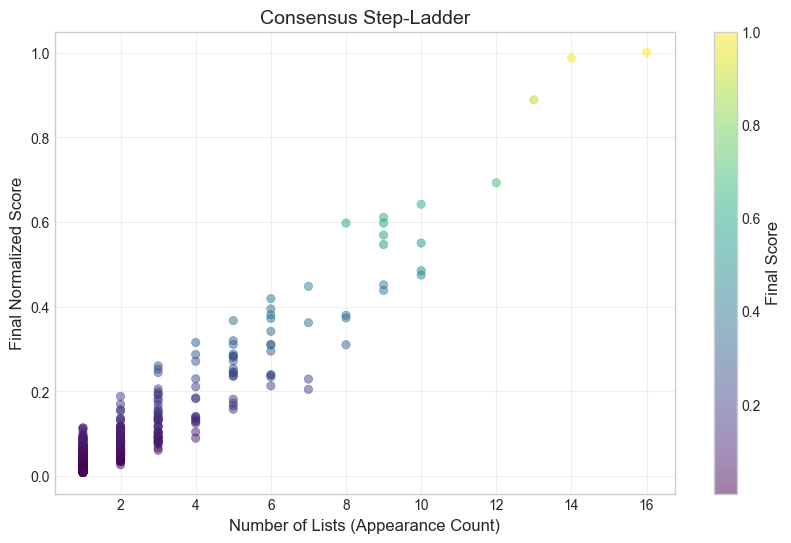

In [231]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
import math


# Use the engine logic from our previous session
def run_viz_engine(
    df,
    mode="consensus",
    p=gem_ranker.P_EXPONENT,
    k=gem_ranker.K_VALUE,
    consensus_boost=gem_ranker.CONSENSUS_BOOST,
    provocation_boost=gem_ranker.PROVOCATION_BOOST,
    cluster_boost=gem_ranker.CLUSTER_BOOST,
    top_bonuses=gem_ranker.TOP_BONUSES_CONSENSUS,
    sources=SOURCES,
):
    df = gem_ranker.compute_rankings_with_configs(
        df,
        sources,
        mode=mode,
        consensus_boost=consensus_boost,
        k_value=k,
        p_exponent=p,
        provocation_boost=provocation_boost,
        cluster_boost=cluster_boost,
        top_bonuses=top_bonuses,
    )

    return df


# --- 1. THE STEP LADDER ---
df_viz = run_viz_engine(pd.read_csv("outputs/data_scored_ytm_quotes.csv"))
plt.figure(figsize=(10, 6))
plt.scatter(
    df_viz["list_count"], df_viz["score"], alpha=0.5, c=df_viz["score"], cmap="viridis"
)
plt.title("Consensus Step-Ladder", fontsize=14)
plt.xlabel("Number of Lists (Appearance Count)", fontsize=12)
plt.ylabel("Final Normalized Score", fontsize=12)
plt.colorbar(label="Final Score")
plt.grid(True, alpha=0.3)
plt.savefig("outputs/consensus_step_ladder.svg", format="svg", bbox_inches="tight")

plt.show()



# --- 3. 3D STABILITY LANDSCAPE (EXPLANATION) ---
# Use your provided code but swap K_VALUES for P_EXPONENTS
# to see how 'Intensity' affects list similarity.

Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


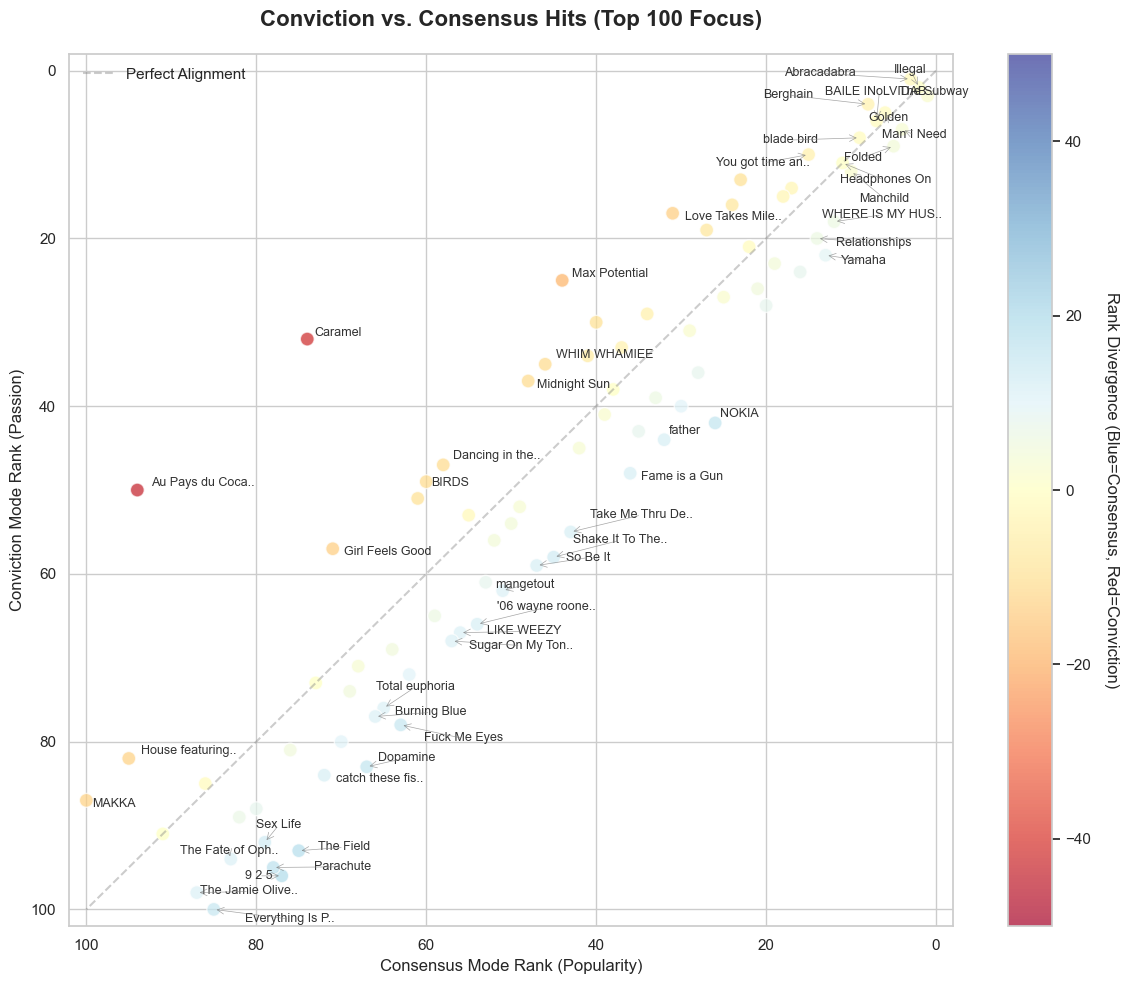

In [232]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text

# Set a clean, professional style for the README
sns.set_theme(style="whitegrid")

# =========================================================
# --- THE FINAL REFINED QUADRANT PLOT ---
# =========================================================

# 1. Generate & Merge Data (Assuming run_viz_engine exists in your notebook)
df_pop = run_viz_engine(pd.read_csv("outputs/data_scored_ytm_quotes.csv"), mode="consensus")
df_pre = run_viz_engine(
    pd.read_csv("outputs/data_scored_ytm_quotes.csv"),
    mode="conviction",
    consensus_boost=0.0,
    cluster_boost=0.0,
    #top_bonuses=gem_ranker.TOP_BONUSES_CONVICTION,
)

df_pop = df_pop.rename(columns={"score": "score_pop", "rank": "rank_pop"})
df_pre = df_pre.rename(columns={"score": "score_pre", "rank": "rank_pre"})

# Merge on standard keys
comparison = pd.merge(
    df_pop, 
    df_pre[["artist", "name", "rank_pre", "score_pre"]], 
    on=["artist", "name"]
)

# 2. Filter for strictly visible points (Top N Focus)
zoom_limit = 100

df_zoom = comparison[
    (comparison["rank_pop"] <= zoom_limit) & 
    (comparison["rank_pre"] <= zoom_limit)
].copy()

# Calculate Divergence for the color scale
df_zoom["divergence"] = df_zoom["rank_pre"] - df_zoom["rank_pop"]

# 3. Setup the Figure
plt.figure(figsize=(12, 10))

# Scatter with color mapping (Red=Mainstream, Blue=Critics Darling)
scatter = plt.scatter(
    df_zoom["rank_pop"],
    df_zoom["rank_pre"],
    c=df_zoom["divergence"],
    cmap="RdYlBu", # Red = Passion, Blue = Consensus
    s=100,
    alpha=0.7,
    edgecolors="w",
    linewidth=1,
    vmin=-50, vmax=50 
)

# Diagonal Alignment Line
plt.plot([0, zoom_limit], [0, zoom_limit], color="gray", linestyle="--", alpha=0.4, label="Perfect Alignment")

# 4. Selective Labeling with String Cleaning
texts = []

# Choose points to label: Top 15 Consensus and major outliers (>35 rank difference)
to_label = pd.concat([
    df_zoom.nsmallest(15, "rank_pop"),
    df_zoom[df_zoom["divergence"].abs() > 10]
]).drop_duplicates(subset=["artist", "name"])

for i, row in to_label.iterrows():
    # CLEANING LOGIC: Split at ' (', take the first part, then truncate to 15 chars
    raw_name = row["name"].split(' (')[0]
    clean_name = raw_name[:15].strip()
    
    # Add ellipsis if we actually cut it off
    if len(raw_name) > 15:
        clean_name += ".."
         
    # Add the text object to our list
    texts.append(plt.text(row["rank_pop"], row["rank_pre"], clean_name, fontsize=9, color='#333333'))

# 5. Visual Refinements & Axis Inversion
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

# Set limits slightly wider than the zoom limit for padding
plt.xlim(zoom_limit + 2, -2)
plt.ylim(zoom_limit + 2, -2)

plt.title(f"Conviction vs. Consensus Hits (Top {zoom_limit} Focus)", fontsize=16, weight='bold', pad=20)
plt.xlabel("Consensus Mode Rank (Popularity)", fontsize=12)
plt.ylabel("Conviction Mode Rank (Passion)", fontsize=12)

# Add Legend and Colorbar
plt.legend(loc='upper left')
cbar = plt.colorbar(scatter)
cbar.set_label('Rank Divergence (Blue=Consensus, Red=Conviction)', rotation=270, labelpad=20)

# Use adjustText to handle overlaps and keep text inside the box
adjust_text(
    texts, 
    arrowprops=dict(arrowstyle="->", color='gray', lw=0.5, alpha=0.7),
    expand_points=(1.5, 1.5),
    force_text=(0.2, 0.5),
    ensure_inside_axes=True
)

plt.tight_layout()
plt.savefig("outputs/consensus_vs_conviction.svg", format="svg", bbox_inches="tight")
plt.show()

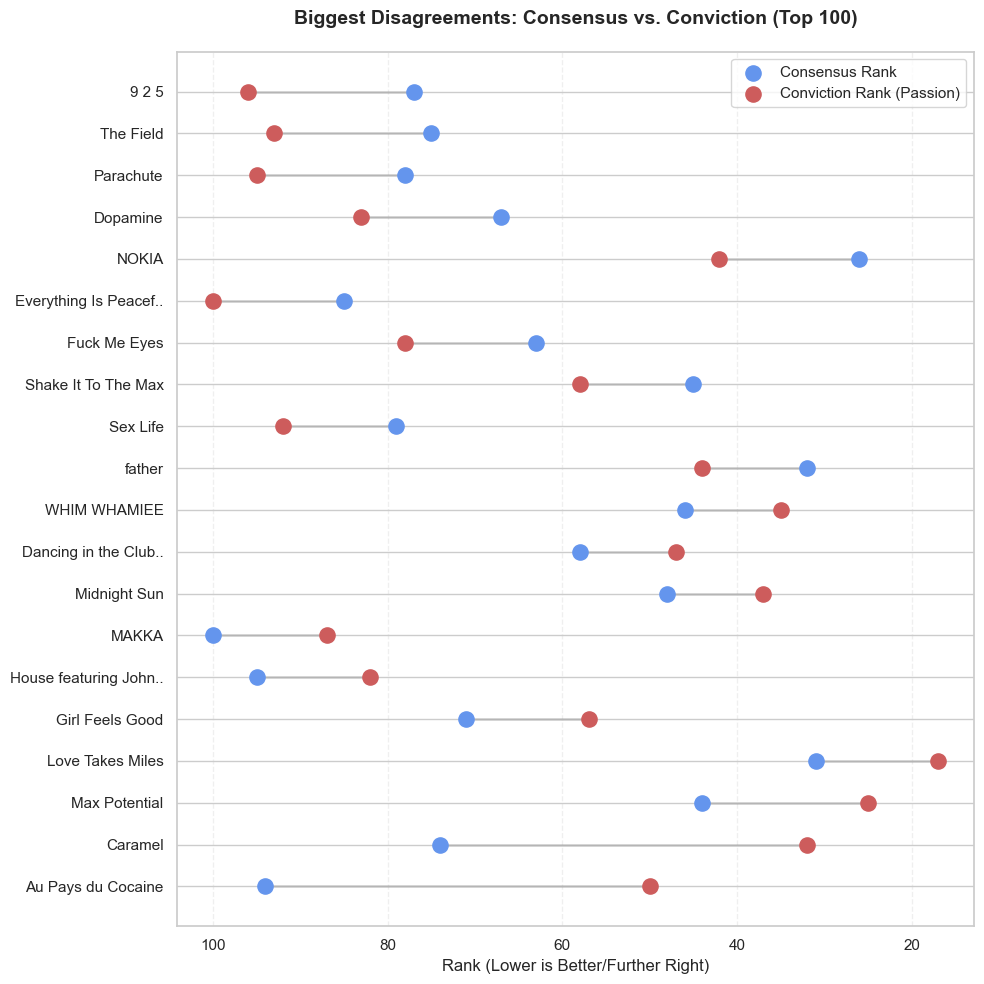

In [233]:
import matplotlib.pyplot as plt
import pandas as pd

# 1. Selection & Data Prep
passion_gems = df_zoom.nsmallest(10, "divergence")
consensus_pillars = df_zoom.nlargest(10, "divergence")
top_divergent = pd.concat([passion_gems, consensus_pillars]).copy()

# 2. Strict String Cleaning
def clean_song_name(name):
    # Split at ' (', take the first part, then truncate to 15 chars
    raw_name = str(name).split(' (')[0]
    clean = raw_name[:20].strip()
    return clean + ".." if len(raw_name) > 20 else clean

# Create the display column
top_divergent['clean_display'] = top_divergent.apply(
    lambda x: f"{clean_song_name(x['name'])}", axis=1
)

# Sort the dataframe so the y-axis order is logical
top_divergent = top_divergent.sort_values("divergence")

# 3. Create a clean Figure and Axis (Single call prevents ghost plots)
fig, ax = plt.subplots(figsize=(10, 10))

# Use numeric range for Y positions to stop Matplotlib from trying to match strings
y_positions = range(len(top_divergent))

# Plot the 'dumbbells' using the numeric y_positions
ax.hlines(
    y=y_positions, 
    xmin=top_divergent['rank_pop'], 
    xmax=top_divergent['rank_pre'], 
    color='grey', 
    alpha=0.3,
    linewidth=2
)

# Blue = Consensus Rank
ax.scatter(
    top_divergent['rank_pop'], 
    y_positions, 
    color='cornflowerblue', 
    label='Consensus Rank', 
    s=120, 
    zorder=3
)

# Red = Passion (Conviction) Rank
ax.scatter(
    top_divergent['rank_pre'], 
    y_positions, 
    color='indianred', 
    label='Conviction Rank (Passion)', 
    s=120, 
    zorder=3
)

# --- THE ABSOLUTE FIX: FORCE TICK LABELS ---
# 1. Tell the axis exactly where the ticks should be
ax.set_yticks(list(y_positions))
# 2. Tell the axis exactly what text to show at those positions
ax.set_yticklabels(top_divergent['clean_display'].tolist())
# --------------------------------------------

# 4. Styling & Final Polish
ax.set_title(f"Biggest Disagreements: Consensus vs. Conviction (Top {zoom_limit})", fontsize=14, weight='bold', pad=20)
ax.set_xlabel("Rank (Lower is Better/Further Right)", fontsize=12)
ax.legend(frameon=True, loc='upper right')

# Invert X-axis so Rank #1 is on the right
ax.invert_xaxis()

ax.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()

# Save and Show
plt.savefig("outputs/rank_divergence_dumbbell.svg", format="svg", bbox_inches="tight")
plt.show()

In [234]:
top_divergent['clean_display'].tolist()

['Au Pays du Cocaine',
 'Caramel',
 'Max Potential',
 'Love Takes Miles',
 'Girl Feels Good',
 'House featuring John..',
 'MAKKA',
 'Midnight Sun',
 'Dancing in the Club..',
 'WHIM WHAMIEE',
 'father',
 'Sex Life',
 'Shake It To The Max',
 'Fuck Me Eyes',
 'Everything Is Peacef..',
 'NOKIA',
 'Dopamine',
 'Parachute',
 'The Field',
 '9 2 5']

In [235]:
df_viz.columns

Index(['rank', 'artist', 'name', 'score', 'list_count', 'sources',
       'consensus_bonus', 'provocation_bonus', 'diversity_bonus', 'raw_score',
       ...
       'quote_model_usatoday', 'quote_variety', 'quote_error_variety',
       'quote_model_variety', 'quote_vulture', 'quote_error_vulture',
       'quote_model_vulture', 'quote_error_nyt_zoladz',
       'quote_model_nyt_zoladz', 'quote_nyt_zoladz'],
      dtype='object', length=203)

/var/folders/jf/lry9g9x122nclq95th6dsb1h0000gn/T/ipykernel_27529/2186207305.py:19: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  songs_in_src = df_viz[df_viz['sources'].str.contains(src)]['id'].unique()


size is 28


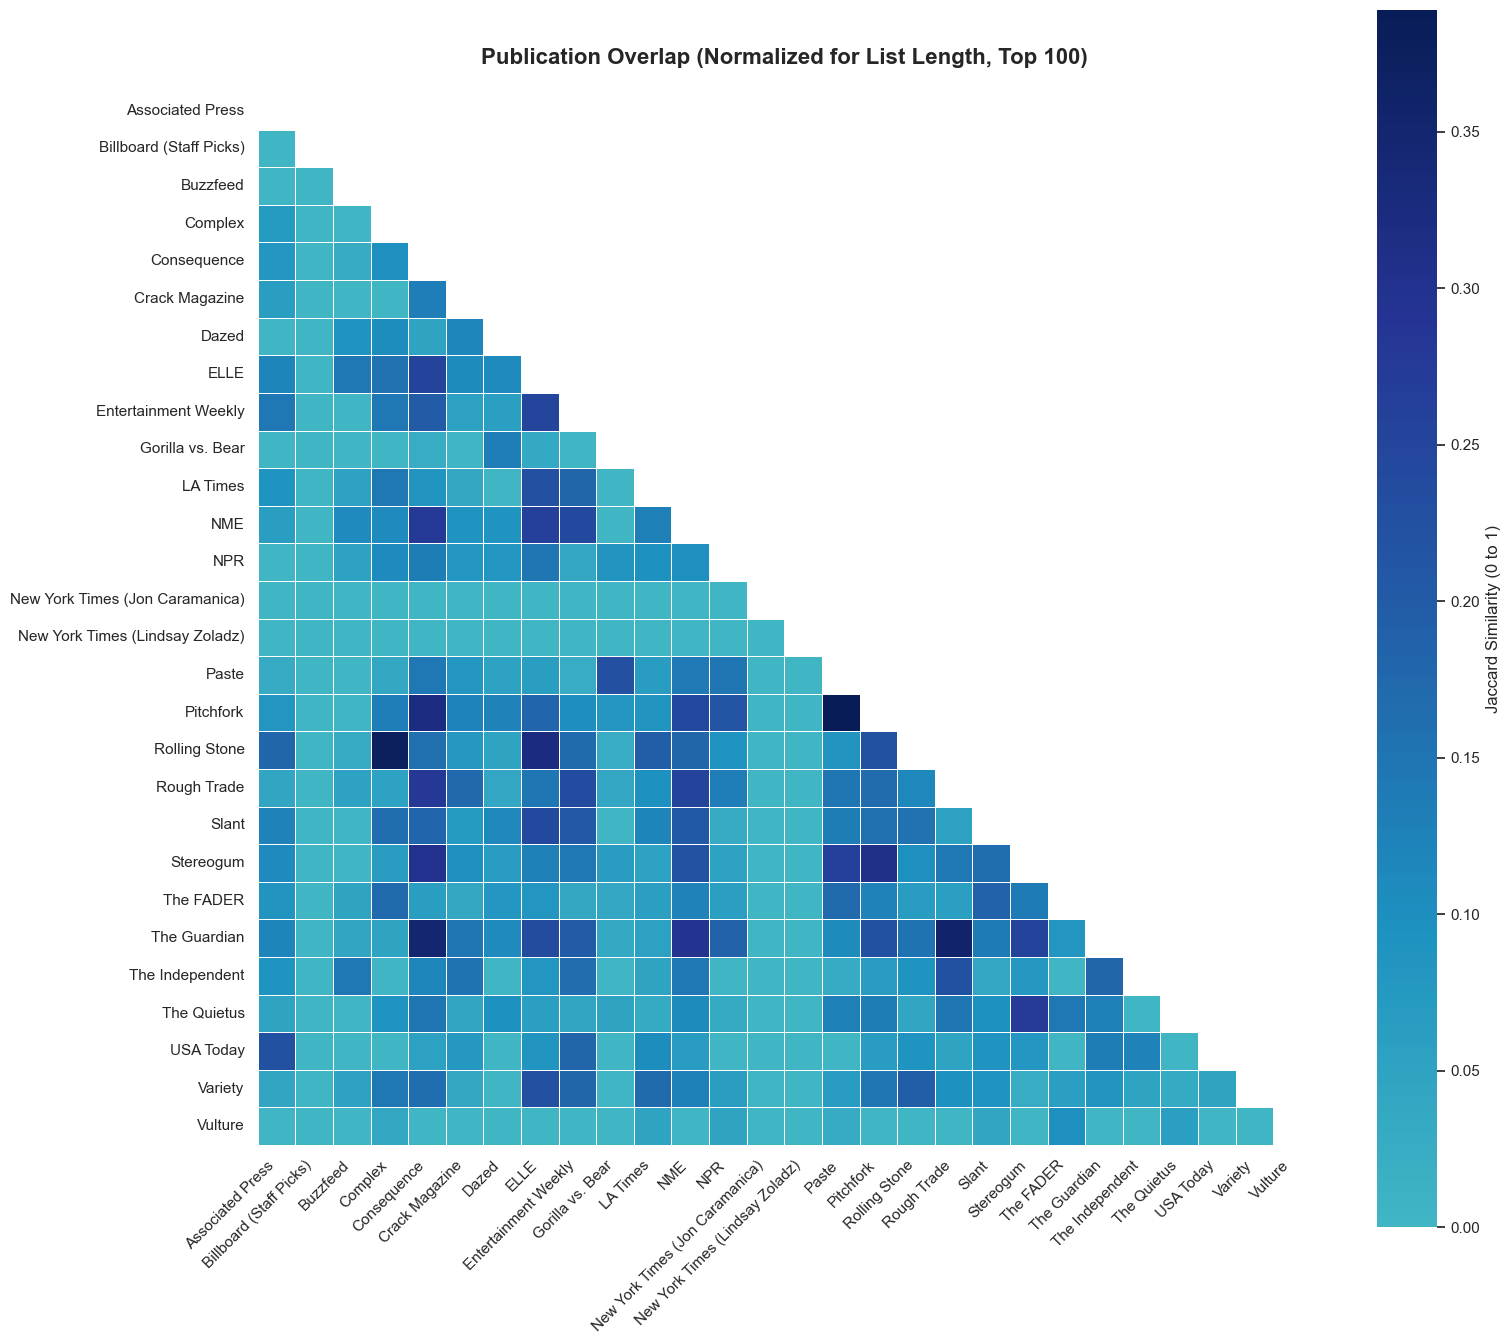

In [236]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


df_viz = run_viz_engine(pd.read_csv("outputs/data_scored_ytm_quotes.csv"), mode="consensus")

pub_overlap_limit_rank = 100

df_viz = df_viz[df_viz["rank"] <= pub_overlap_limit_rank]

# 1. Prepare a Dictionary of Sets (much faster for overlap math)
# Extract just the publication names from your scoring data
pub_sets = {}
for src in SOURCES:
    # Find all songs that appear in this specific source
    # This logic assumes your df_viz has the 'sources' column in "Name#Rank" format
    songs_in_src = df_viz[df_viz['sources'].str.contains(src)]['id'].unique()
    if src.startswith('NPR'):
        src = "NPR"    
    pub_sets[src] = set(songs_in_src)

# 2. Build the Jaccard Similarity Matrix
keys = sorted(list(pub_sets.keys()))

size = len(keys)
print(f"size is {size}")
jaccard_matrix = np.zeros((size, size))

for i, src_a in enumerate(keys):
    for j, src_b in enumerate(keys):
        set_a = pub_sets[src_a]
        set_b = pub_sets[src_b]
        
        intersection = len(set_a.intersection(set_b))
        union = len(set_a.union(set_b))
        
        # Avoid division by zero if a list is empty
        jaccard_matrix[i, j] = intersection / union if union > 0 else 0

# Convert to DataFrame for easier plotting

matrix_df = pd.DataFrame(jaccard_matrix, index=keys, columns=keys)

# 3. Plotting
plt.figure(figsize=(16, 14))
sns.set_theme(style="white")

# Mask the upper triangle for a cleaner "half-matrix" look
mask = np.triu(np.ones_like(matrix_df, dtype=bool))

sns.heatmap(
    matrix_df, 
    mask=mask, 
    cmap="YlGnBu", 
    vmax=matrix_df[matrix_df < 1].max().max(), # Scale color to the highest non-1.0 value
    center=0,
    square=True, 
    linewidths=.5, 
    annot=False, # Set to True if you want the % overlap visible
    cbar_kws={"label": "Jaccard Similarity (0 to 1)"}
)

plt.title(f"Publication Overlap (Normalized for List Length, Top {pub_overlap_limit_rank})", fontsize=16, weight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.savefig("outputs/normalized_overlap_matrix.svg", format="svg")
plt.show()

In [237]:
import pandas as pd
import plotly.graph_objects as go
import plotly.io as pio
import kaleido

# 1. Prepare Data: Map every source to its Cluster
# Assuming SOURCES is your dict: {"Pitchfork": {"cluster": "Critical Authority"}, ...}
source_to_cluster = {name: info['cluster'] for name, info in SOURCES.items()}
unique_clusters = sorted(list(set(source_to_cluster.values())))

# 2. Identify the Top 10 Songs
top_10 = df_viz.head(10).copy()
song_names = top_10['name'].tolist()

# 3. Build Nodes (Categories on the left, Songs on the right)
nodes = unique_clusters + song_names
node_indices = {name: i for i, name in enumerate(nodes)}

# 4. Build Links (Flow from Category -> Song)
sources, targets, values = [], [], []

for _, row in top_10.iterrows():
    song_name = row['name']
    # Parse the 'sources' column which looks like "Pitchfork#1, Rolling Stone#5..."
    for entry in row['sources'].split(', '):
        pub_name, _ = entry.split('#')
        
        if pub_name in source_to_cluster:
            cluster = source_to_cluster[pub_name]
            
            # We add a link from the Cluster to the Song
            # The 'value' here is 1 (one mention) or you can weight it by points
            sources.append(node_indices[cluster])
            targets.append(node_indices[song_name])
            values.append(1) 


# Create a color map for your clusters
cluster_colors = {
    "Critical Authority": "#FFD700", # Gold
    "Tastemakers": "#9370DB",        # Purple
    "Mainstream": "#4682B4",         # SteelBlue
    "Specialists": "#3CB371"          # MediumSeaGreen
}

# Assign colors to links based on the source cluster
link_colors = [cluster_colors.get(unique_clusters[src], "rgba(0,0,0,0.1)") for src in sources]

fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 40,        # INCREASED: More vertical space between boxes
      thickness = 40,  # INCREASED: Makes the song boxes wider/chunkier
      line = dict(color = "black", width = 0.5),
      label = nodes,
      color = "lightgrey"
    ),
    link = dict(
      source = sources,
      target = targets,
      value = values,
      color = link_colors 
  ))])

fig.update_layout(
    title_text="The Influence Flow: Category to Top 10",
    font_size=12,
    title_font_size=22,
    height=1000,       # INCREASED: Stretches the chart vertically
    margin=dict(l=50, r=50, t=80, b=50) # Adds padding around the edges
)

# Export as SVG
pio.write_image(fig, "outputs/category_crossover_sankey.svg")
fig.show()

/var/folders/jf/lry9g9x122nclq95th6dsb1h0000gn/T/ipykernel_27529/3372143025.py:73: DeprecationWarning:


Support for Kaleido versions less than 1.0.0 is deprecated and will be removed after September 2025.
Please upgrade Kaleido to version 1.0.0 or greater (`pip install 'kaleido>=1.0.0'` or `pip install 'plotly[kaleido]'`).




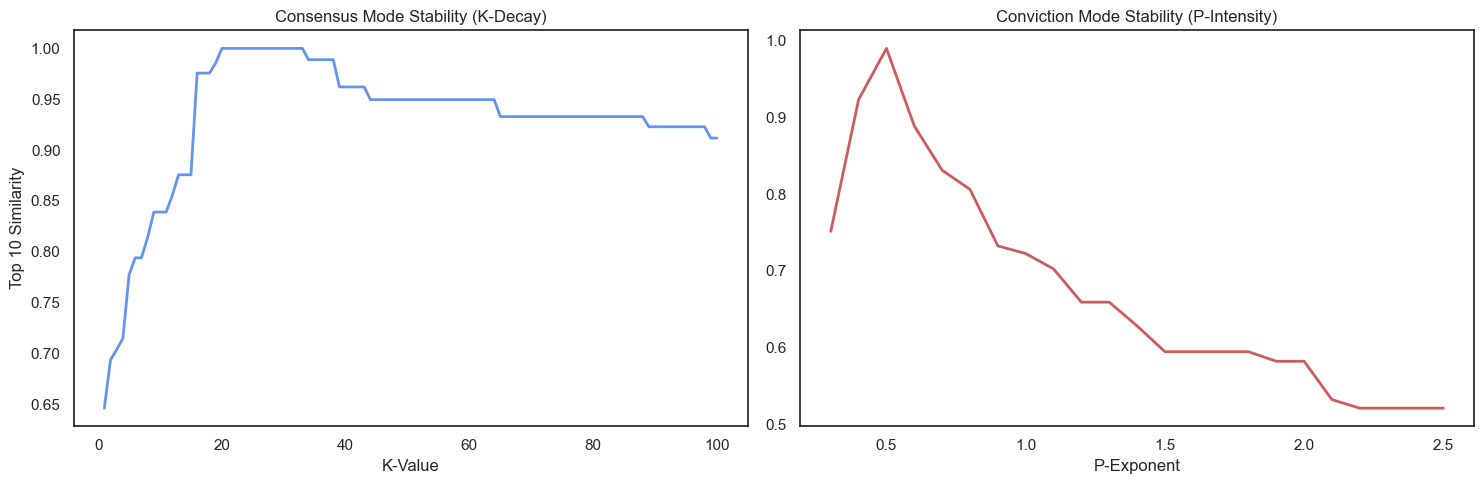

In [238]:
import matplotlib.pyplot as plt

# --- 1. Test Consensus Stability (K-Value) ---
k_range = range(1, 101)
consensus_scores = []
df_base_cons = run_viz_engine(df, mode="consensus", k=gem_ranker.K_VALUE) # Your 'production' setting

for k in k_range:
    df_var = run_viz_engine(df, mode="consensus", k=k)
    consensus_scores.append(calculate_cr_at_k(df_base_cons, df_var, k=10))

# --- 2. Test Conviction Stability (P-Exponent) ---
p_range = [x/10 for x in range(3, 26)] # 0.5 to 2.5
conviction_scores = []
df_base_conv = run_viz_engine(df, mode="conviction", p=gem_ranker.P_EXPONENT) # Your 'production' setting

for p in p_range:
    df_var = run_viz_engine(df, mode="conviction", p=p)
    conviction_scores.append(calculate_cr_at_k(df_base_conv, df_var, k=10))

# --- 3. Plotting Side-by-Side ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(k_range, consensus_scores, color='cornflowerblue', lw=2)
ax1.set_title("Consensus Mode Stability (K-Decay)")
ax1.set_xlabel("K-Value")
ax1.set_ylabel("Top 10 Similarity")

ax2.plot(p_range, conviction_scores, color='indianred', lw=2)
ax2.set_title("Conviction Mode Stability (P-Intensity)")
ax2.set_xlabel("P-Exponent")

plt.tight_layout()
plt.savefig("outputs/model_sensitivity_analysis.svg")

# Other

In [239]:
import pandas as pd
df = pd.read_csv("outputs/data_scored_ytm_quotes.csv")


In [240]:
sources = list()

seen_npr = False
for name, config in SOURCES.items():
    if name.startswith("NPR"):
        if seen_npr:
            continue
        sources.append(("NPR", config["cluster"]))
        seen_npr = True
        continue
    sources.append((name, config["cluster"]))

source_cats_df = pandas.DataFrame(sources).rename(columns={0:"name", 1:"category"})
source_cats_df.sort_values(by=["name"], inplace=True)
source_cats_df.to_csv("outputs/source_cats.csv", index=False, encoding="utf-8")
source_cats_df

,name,category
21,Associated Press,Mainstream
22,Billboard (Staff Picks),Mainstream
23,Buzzfeed,Mainstream
8,Complex,Tastemakers
9,Consequence,Tastemakers
15,Crack Magazine,Specialists
16,Dazed,Specialists
24,ELLE,Mainstream
25,Entertainment Weekly,Mainstream
10,Gorilla vs. Bear,Tastemakers


In [241]:
#artist_results = sp.artists(['7GlBOeep6PqTfFi59PTUUN', '78rUTD7y6Cy67W1RVzYs7t'])
#artist_results